# Micromorphic Matrix Form Derivation

We here derive the matrix form of the micromorphic balance equations.

In [1]:
import sympy
import numpy as np
import itertools

from sympy.utilities.codegen import codegen

sympy.init_printing()

In [2]:
def form_tensor(symbol,shape,isreal=True,isfunction=False,add_open_brace=False,add_close_brace=False,add_braces=False,variables=[]):
    
    if(add_braces):
        add_open_brace = True
        add_close_brace = True
    
    if(add_open_brace):
        symbol += r"{"
    
    if(len(shape)>1):
        return [form_tensor(symbol+str(i+1),shape[1:],\
                            isreal=isreal,isfunction=isfunction,\
                            add_close_brace=add_close_brace,variables=variables)\
                for i in range(shape[0])]
    else:
        
        if add_close_brace:
            cb = r"}"
        else:
            cb = ""
        
        if(isfunction):
            return [sympy.Function(symbol+str(i+1)+cb,real=isreal)(*variables) for i in range(shape[0])]
        else:
            return [sympy.symbols(symbol+str(i+1)+cb,real=isreal) for i in range(shape[0])]
    
def make_symmetric_2(tensor):
    """Make a second order tensor symmetric"""
    for i in range(3):
        for j in range(3):
            tensor[j][i] = tensor[i][j]
            
def make_symmetric_4(tensor,major_symm=False,minor_symm=False):
    """Make a fourth order tensor symmetric"""
    
    if(major_symm):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    for l in range(3):
                        tensor[k][l][i][j] = tensor[i][j][k][l]
                        
    if(minor_symm):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    for l in range(3):
                        tensor[j][i][k][l] = tensor[i][j][k][l]
                        tensor[i][j][l][k] = tensor[i][j][k][l]

def tensor_to_voigt_2(A,issymm=False):
    
    if issymm: n = 6
    else:      n = 9
    
    a = [None for _ in range(n)]
    
    a[0] = A[0][0]
    a[1] = A[1][1]
    a[2] = A[2][2]
    a[3] = A[1][2]
    a[4] = A[0][2]
    a[5] = A[0][1]
    
    if not issymm:
        a[6] = A[2][1]
        a[7] = A[2][0]
        a[8] = A[1][0]
        
    return a

def tensor_to_voigt_3(A,asmatrix=False):
    
    if not asmatrix:
        a = [None for _ in range(27)]
    else:
        a = [[None for _ in range(9)] for __ in range(3)]
    
    for i in range(3):
        
        b = tensor_to_voigt_2(A[i])
        
        if not asmatrix:
            a[0+9*i] = b[0]
            a[1+9*i] = b[1]
            a[2+9*i] = b[2]
            a[3+9*i] = b[3]
            a[4+9*i] = b[4]
            a[5+9*i] = b[5]
            a[6+9*i] = b[6]
            a[7+9*i] = b[7]
            a[8+9*i] = b[8]
        else:
            a[i][0] = b[0]
            a[i][1] = b[1]
            a[i][2] = b[2]
            a[i][3] = b[3]
            a[i][4] = b[4]
            a[i][5] = b[5]
            a[i][6] = b[6]
            a[i][7] = b[7]
            a[i][8] = b[8]
        
    return a

def voigt_to_tensor_2(a):
    
    A = [[None for _ in range(3)] for __ in range(3)]
    
    A[0][0] = a[0]
    A[1][1] = a[1]
    A[2][2] = a[2]
    A[1][2] = a[3]
    A[0][2] = a[4]
    A[0][1] = a[5]
    
    if(len(a)==6):
        A[2][1] = a[3]
        A[2][0] = a[4]
        A[1][0] = a[5]
        
    elif(len(a)==9):
        A[2][1] = a[6]
        A[2][0] = a[7]
        A[1][0] = a[8]
        
    else:
        print("Error: incoming vector of incorrect size.\n"+\
              "       Vector is of length: {0}\n".format(len(a))+\
              "       Must be of length 6 or 9.")
        raise IOError
    return A
        
def get_symm_2(A):
    
    half = sympy.S(1)/sympy.S(2)
    
    if(len(A)!=len(A[0])):
        print("Error: Matrix must be square.")
        raise IOError
        
    for i in range(len(A)):
        if(len(A[0])!=len(A[i])):
            print("Error: Matrix columns are inconsistent in length")
            raise IOError
    
    Asymm = form_tensor("A_symm",[len(A),len(A[0])])
    
    for i in range(3):
        for j in range(3):
            Asymm[i][j] = half*(A[i][j]+A[j][i])
            
    return Asymm
            
def get_skew_2(A):
    
    half = sympy.S(1)/sympy.S(2)
    
    if(len(A)!=len(A[0])):
        print("Error: Matrix must be square.")
        raise IOError
        
    for i in range(len(A)):
        if(len(A[0])!=len(A[i])):
            print("Error: Matrix columns are inconsistent in length")
            raise IOError
    
    Askew = form_tensor("A_skew",[len(A),len(A[0])])
    
    for i in range(3):
        for j in range(3):
            Askew = half*(A[i][j]-A[j][i])
            
    return Askew

def pseudo_inverse(A,isright=True):
    
    M = sympy.Matrix(A)
    
    if(isright):
        return M.H * (M * M.H) ** -1
    else:
        return (M.H * M) ** -1 * M.H

In [3]:
"Test the form_tensor function"
A = form_tensor(r'A_',[3,3],add_braces=True)
print(A)
make_symmetric_2(A)
print(A)
B = form_tensor('B',[3,3,3])
print(B)
C = form_tensor('C',[3,3,3,3])
print(C)
make_symmetric_4(C,major_symm=True)
print(C)
print(C[1][2][2][1])
print(C[2][1][1][2])

[[A_{11}, A_{12}, A_{13}], [A_{21}, A_{22}, A_{23}], [A_{31}, A_{32}, A_{33}]]
[[A_{11}, A_{12}, A_{13}], [A_{12}, A_{22}, A_{23}], [A_{13}, A_{23}, A_{33}]]
[[[B111, B112, B113], [B121, B122, B123], [B131, B132, B133]], [[B211, B212, B213], [B221, B222, B223], [B231, B232, B233]], [[B311, B312, B313], [B321, B322, B323], [B331, B332, B333]]]
[[[[C1111, C1112, C1113], [C1121, C1122, C1123], [C1131, C1132, C1133]], [[C1211, C1212, C1213], [C1221, C1222, C1223], [C1231, C1232, C1233]], [[C1311, C1312, C1313], [C1321, C1322, C1323], [C1331, C1332, C1333]]], [[[C2111, C2112, C2113], [C2121, C2122, C2123], [C2131, C2132, C2133]], [[C2211, C2212, C2213], [C2221, C2222, C2223], [C2231, C2232, C2233]], [[C2311, C2312, C2313], [C2321, C2322, C2323], [C2331, C2332, C2333]]], [[[C3111, C3112, C3113], [C3121, C3122, C3123], [C3131, C3132, C3133]], [[C3211, C3212, C3213], [C3221, C3222, C3223], [C3231, C3232, C3233]], [[C3311, C3312, C3313], [C3321, C3322, C3323], [C3331, C3332, C3333]]]]
[[[[C1111

Generate constant values that we need.

In [4]:
zero  = sympy.S(0)
one   = sympy.S(1)
two   = sympy.S(2)
three = sympy.S(3)

half = one/two

#Form the identity tensor|
eye  = [[zero for _ in range(3)] for __ in range(3)]
eye[0][0] = one
eye[1][1] = one
eye[2][2] = one

Now lets test the symmetry functions by computing the stiffness matrix for a linear elastic material

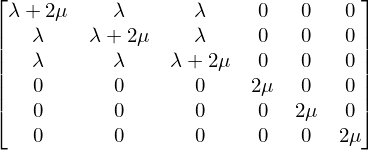

In [5]:
E = form_tensor('E',[3,3])
lamb,mu = sympy.symbols('lambda mu',real=True,positive=True)
make_symmetric_2(E)

sigma = form_tensor('sigma',[3,3])

for I in range(3):
    for J in range(3):
        sigma[I][J] = lamb*eye[I][J]*(E[0][0]+E[1][1]+E[2][2]) + two*mu*E[I][J]

sympy.Matrix(tensor_to_voigt_2(sigma,issymm=True)).jacobian(tensor_to_voigt_2(E,issymm=True))

In [6]:
tensor_to_voigt_3(form_tensor('D',[3,3,3]))

Form the terms which exist in our balance equations

In [7]:
u    = sympy.symbols('u_1 u_2 u_3',real=True)                      #Displacements
v    = sympy.symbols('\dot{u}_1 \dot{u}_2 \dot{u}_3',real=True)    #Velocity
a    = sympy.symbols('\ddot{u}_1 \ddot{u}_2 \ddot{u}_3',real=True) #Accelerations
F    = form_tensor('F',[3,3],isfunction=False,variables=[u])       #Deformation Gradient
rho0 = sympy.symbols('rho0',real=True,positive=True)               #Density in the reference configuration
X    = sympy.symbols('X_1 X_2 X_3')

S    = form_tensor('S',[3,3],isfunction=False,variables=[u])        #PK2 stress
make_symmetric_2(S)
N    = sympy.symbols('N^n',real=True)                              #The shape function
dNdX = form_tensor(r'\frac{dN^{n}}{dX}_',[3],add_braces=True)      #The derivative of the shape function w.r.t. X
Jac  = sympy.symbols('J',real=True,positive=True)                  #Jacobian of transformation
Jhat = sympy.symbols(r'\hat{J}',real=True,positive=True)           #Jacobian of transformation to master coordinates
b    = sympy.symbols('b_1 b_2 b_3',real=True)                      #Body force

## Deformation Measures

Define the deformation measures

In [8]:
RCG    = form_tensor(r"C_",      [3,3],   isreal=True,add_braces=True)
RCGinv = form_tensor(r"C^{-1}_", [3,3],   isreal=True,add_braces=True)
Psi    = form_tensor(r"\Psi_",   [3,3],   isreal=True,add_braces=True)
Gamma  = form_tensor(r"\Gamma_", [3,3,3], isreal=True,add_braces=True)


E     = form_tensor(r"E_", [3,3], isreal=True, add_braces=True)
#make_symmetric_2(E)
e     = form_tensor(r"\mathcal{E}_", [3,3],   isreal=True, add_braces=True)

#for I in range(3):
#    for J in range(3):
#        E[I][J] = half*(RCG[I][J] - eye[I][J])
#        e[I][J] = Psi[I][J] - eye[I][J]

## Linear Isotropic Elasticity Stress Measures

Compute the stress measures

In [9]:
lamb,mu,eta,tau,kappa,nu,sigma = sympy.symbols('lambda mu eta tau kappa nu sigma',real=True)
tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11 = sympy.symbols('tau1 tau2 tau3 tau4 tau5 tau6 tau7 tau8 tau9 tau10 tau11',real=True)

A = form_tensor(r'\mathcal{A}',[3,3,3,3],     isreal=True)
B = form_tensor(r'\mathcal{B}',[3,3,3,3],     isreal=True)
C = form_tensor(r'\mathcal{C}',[3,3,3,3,3,3], isreal=True)
D = form_tensor(r'\mathcal{D}',[3,3,3,3],     isreal=True)

In [10]:
for k in range(3):
    for l in range(3):
        for m in range(3):
            for n in range(3):
                A[k][l][m][n] = lamb*eye[k][l]*eye[m][n] + mu*(eye[k][m]*eye[l][n] + eye[k][n]*eye[l][m])
                B[k][l][m][n] = (eta-tau)*eye[k][l]*eye[m][n] + kappa*eye[k][m]*eye[l][n] + nu*eye[k][n]*eye[l][m]\
                                - sigma*(eye[k][m]*eye[l][n] + eye[k][n]*eye[l][m])
                    
                for p in range(3):
                    for q in range(3):
                        C[k][l][m][n][p][q] =  tau1*(eye[k][l]*eye[m][n]*eye[p][q] + eye[k][q]*eye[l][m]*eye[n][p])\
                                              +tau2*(eye[k][l]*eye[m][p]*eye[n][q] + eye[k][m]*eye[l][q]*eye[n][p])\
                                              +tau3*eye[k][l]*eye[m][q]*eye[n][p]  + tau4*eye[k][n]*eye[l][m]*eye[p][q]\
                                              +tau5*(eye[k][m]*eye[l][n]*eye[p][q] + eye[k][p]*eye[l][m]*eye[n][q])\
                                              +tau6*eye[k][m]*eye[l][p]*eye[n][q]  + tau7*eye[k][n]*eye[l][p]*eye[m][q]\
                                              +tau8*(eye[k][p]*eye[l][q]*eye[m][n] + eye[k][q]*eye[l][n]*eye[m][p])\
                                              +tau9*eye[k][n]*eye[l][q]*eye[m][p]  + tau10*eye[k][p]*eye[l][n]*eye[m][q]\
                                              +tau11*eye[k][q]*eye[l][p]*eye[m][n]
                                            
                D[k][l][m][n] = tau*eye[k][l]*eye[m][n] + sigma*(eye[k][m]*eye[l][n]+eye[k][n]*eye[l][m])

In [11]:
def find_dimension(T,store=[]):
    store.append(len(T))
    if(type(T[0])==list):
        return find_dimension(T[0],store=store)
    else:
        return store

def print_tensor_info(T,symb,nspaces=0,params={}):
    
    dim = len(find_dimension(T,store=[]))
    
    indices = itertools.product(range(3),repeat=dim)
    
    for indx in indices:
        
        temp = T
        
        for i in indx:
            temp = temp[i]
            
        if(not temp == zero):
            string = ' '*nspaces
            print(string+symb+"{0} = {1};".format(indx,temp.subs(params)))


            
print_tensor_info(A,"A",8)

        A(0, 0, 0, 0) = lambda + 2*mu;
        A(0, 0, 1, 1) = lambda;
        A(0, 0, 2, 2) = lambda;
        A(0, 1, 0, 1) = mu;
        A(0, 1, 1, 0) = mu;
        A(0, 2, 0, 2) = mu;
        A(0, 2, 2, 0) = mu;
        A(1, 0, 0, 1) = mu;
        A(1, 0, 1, 0) = mu;
        A(1, 1, 0, 0) = lambda;
        A(1, 1, 1, 1) = lambda + 2*mu;
        A(1, 1, 2, 2) = lambda;
        A(1, 2, 1, 2) = mu;
        A(1, 2, 2, 1) = mu;
        A(2, 0, 0, 2) = mu;
        A(2, 0, 2, 0) = mu;
        A(2, 1, 1, 2) = mu;
        A(2, 1, 2, 1) = mu;
        A(2, 2, 0, 0) = lambda;
        A(2, 2, 1, 1) = lambda;
        A(2, 2, 2, 2) = lambda + 2*mu;


In [12]:
print_tensor_info(B,"B",8)

        B(0, 0, 0, 0) = eta + kappa + nu - 2*sigma - tau;
        B(0, 0, 1, 1) = eta - tau;
        B(0, 0, 2, 2) = eta - tau;
        B(0, 1, 0, 1) = kappa - sigma;
        B(0, 1, 1, 0) = nu - sigma;
        B(0, 2, 0, 2) = kappa - sigma;
        B(0, 2, 2, 0) = nu - sigma;
        B(1, 0, 0, 1) = nu - sigma;
        B(1, 0, 1, 0) = kappa - sigma;
        B(1, 1, 0, 0) = eta - tau;
        B(1, 1, 1, 1) = eta + kappa + nu - 2*sigma - tau;
        B(1, 1, 2, 2) = eta - tau;
        B(1, 2, 1, 2) = kappa - sigma;
        B(1, 2, 2, 1) = nu - sigma;
        B(2, 0, 0, 2) = nu - sigma;
        B(2, 0, 2, 0) = kappa - sigma;
        B(2, 1, 1, 2) = nu - sigma;
        B(2, 1, 2, 1) = kappa - sigma;
        B(2, 2, 0, 0) = eta - tau;
        B(2, 2, 1, 1) = eta - tau;
        B(2, 2, 2, 2) = eta + kappa + nu - 2*sigma - tau;


In [13]:
print_tensor_info(C,"C",8)

        C(0, 0, 0, 0, 0, 0) = 2*tau1 + tau10 + tau11 + 2*tau2 + tau3 + tau4 + 2*tau5 + tau6 + tau7 + 2*tau8 + tau9;
        C(0, 0, 0, 0, 1, 1) = tau1 + tau4 + tau5;
        C(0, 0, 0, 0, 2, 2) = tau1 + tau4 + tau5;
        C(0, 0, 0, 1, 0, 1) = tau2 + tau5 + tau6;
        C(0, 0, 0, 1, 1, 0) = tau1 + tau2 + tau3;
        C(0, 0, 0, 2, 0, 2) = tau2 + tau5 + tau6;
        C(0, 0, 0, 2, 2, 0) = tau1 + tau2 + tau3;
        C(0, 0, 1, 0, 0, 1) = tau10 + tau3 + tau7;
        C(0, 0, 1, 0, 1, 0) = tau2 + tau8 + tau9;
        C(0, 0, 1, 1, 0, 0) = tau1 + tau11 + tau8;
        C(0, 0, 1, 1, 1, 1) = tau1 + tau2 + tau3;
        C(0, 0, 1, 1, 2, 2) = tau1;
        C(0, 0, 1, 2, 1, 2) = tau2;
        C(0, 0, 1, 2, 2, 1) = tau3;
        C(0, 0, 2, 0, 0, 2) = tau10 + tau3 + tau7;
        C(0, 0, 2, 0, 2, 0) = tau2 + tau8 + tau9;
        C(0, 0, 2, 1, 1, 2) = tau3;
        C(0, 0, 2, 1, 2, 1) = tau2;
        C(0, 0, 2, 2, 0, 0) = tau1 + tau11 + tau8;
        C(0, 0, 2, 2, 1, 1) = tau1;
        C(0, 0

In [14]:
print_tensor_info(D,"D",8)

        D(0, 0, 0, 0) = 2*sigma + tau;
        D(0, 0, 1, 1) = tau;
        D(0, 0, 2, 2) = tau;
        D(0, 1, 0, 1) = sigma;
        D(0, 1, 1, 0) = sigma;
        D(0, 2, 0, 2) = sigma;
        D(0, 2, 2, 0) = sigma;
        D(1, 0, 0, 1) = sigma;
        D(1, 0, 1, 0) = sigma;
        D(1, 1, 0, 0) = tau;
        D(1, 1, 1, 1) = 2*sigma + tau;
        D(1, 1, 2, 2) = tau;
        D(1, 2, 1, 2) = sigma;
        D(1, 2, 2, 1) = sigma;
        D(2, 0, 0, 2) = sigma;
        D(2, 0, 2, 0) = sigma;
        D(2, 1, 1, 2) = sigma;
        D(2, 1, 2, 1) = sigma;
        D(2, 2, 0, 0) = tau;
        D(2, 2, 1, 1) = tau;
        D(2, 2, 2, 2) = 2*sigma + tau;


### PK2 Stress tensor

Form a matrix-multiplication form of the PK2 stress tensor

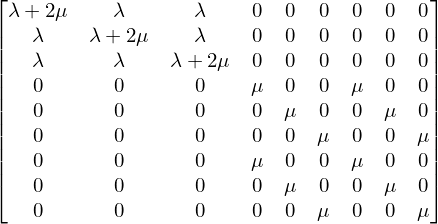

In [15]:
term1  = form_tensor('term1',  [3,3], isreal=True)
term2  = form_tensor('term2',  [3,3], isreal=True)
term3  = form_tensor('term4',  [3,3], isreal=True)
term4  = form_tensor('term4',  [3,3], isreal=True)
term5  = form_tensor('term5',  [3,3], isreal=True)

temp1  = form_tensor('temp1', [3,3],   isreal=True)
temp2  = form_tensor('temp2', [3,3],   isreal=True)
temp3  = form_tensor('temp3', [3,3],   isreal=True)
temp4  = form_tensor('temp4', [3,3,3], isreal=True)
temp5  = form_tensor('temp5', [3,3,3], isreal=True)

T3     = form_tensor(r"T_",           [3,3],   isreal=True, add_braces=True)
T4     = form_tensor(r"\mathcal{T}_", [3,3,3], isreal=True, add_braces=True)

for i in range(3):
    for j in range(3):
        
        term1[i][j]  = zero
        term2[i][j]  = zero
        temp1[i][j] = zero
        temp2[i][j] = zero
        
        for k in range(3):
            for l in range(3):
                term1[i][j] += A[i][j][k][l]*E[k][l]
                term2[i][j] += D[i][j][k][l]*e[k][l]
                temp1[i][j] += B[i][j][k][l]*e[k][l]
                temp2[i][j] += D[i][j][k][l]*E[k][l]
                
for j in range(3):
    for q in range(3):
        
        temp3[j][q] = zero
        
        for t in range(3):
            temp3[j][q] += RCGinv[t][j]*Psi[t][q]

for j in range(3):
    for q in range(3):
        for r in range(3):
            temp4[j][q][r] = zero
            
            for s in range(3):
                temp4[j][q][r] += RCGinv[j][s]*Gamma[s][q][r]
            
for i in range(3):
    for j in range(3):
        
        term3[i][j] = zero
        term4[i][j] = zero
        
        for q in range(3):
            for r in range(3):
                term3[i][j] += temp1[i][q]*T3[j][q]
                term4[i][j] += temp2[i][q]*T3[j][q]
            
for i in range(3):
    for q in range(3):
        for r in range(3):
            temp5[i][q][r] = zero
            
            for l in range(3):
                for m in range(3):
                    for n in range(3):
                        temp5[i][q][r] += C[i][q][r][l][m][n]*Gamma[l][m][n]
                        
for i in range(3):
    for j in range(3):
        term5[i][j] = zero
        
        for q in range(3):
            for r in range(3):
                term5[i][j] += temp5[i][q][r]*T4[j][q][r]
                        
                
            
E_voigt      = tensor_to_voigt_2(E,        issymm=False)
e_voigt      = tensor_to_voigt_2(e,        issymm=False)
temp3_voigt  = tensor_to_voigt_2(temp3,    issymm=False)
T3_voigt     = tensor_to_voigt_2(T3,       issymm=False)
T4_voigt     = tensor_to_voigt_3(T4)
RCGinv_voigt = tensor_to_voigt_2(RCGinv,   issymm=False)
Gamma_voigt  = tensor_to_voigt_3(Gamma)
            
term1_matrix = sympy.Matrix(tensor_to_voigt_2(term1,issymm=False)).jacobian(E_voigt)
term2_matrix = sympy.Matrix(tensor_to_voigt_2(term2,issymm=False)).jacobian(e_voigt)
term3_matrix = sympy.Matrix(tensor_to_voigt_2(term3,issymm=False)).jacobian(e_voigt)
term4_matrix = sympy.Matrix(tensor_to_voigt_2(term4,issymm=False)).jacobian(E_voigt)
term5_matrix = sympy.Matrix(tensor_to_voigt_2(term5,issymm=False)).jacobian(Gamma_voigt)
B_voigt = sympy.Matrix(tensor_to_voigt_2(temp1)).jacobian(e_voigt)
C_voigt = sympy.Matrix(tensor_to_voigt_3(temp5)).jacobian(Gamma_voigt)
D_voigt = sympy.Matrix(tensor_to_voigt_2(temp2)).jacobian(E_voigt)
#C_voigt
#Print the A stiffness tensor in voigt notation
A_voigt = term1_matrix
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_A_voigt", A_voigt), "C", "test", header=False, empty=False)
#print(c_header)
#print(c_code)
#Print the B stiffness tensor in voigt notation
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_B_voigt", B_voigt), "C", "test", header=False, empty=False)
#print(c_header)
#print(c_code)
#Print the C stiffness tensor in voigt notation
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_C_voigt", C_voigt), "C", "test", header=False, empty=False)
#print(c_header)
#print(c_code)
#Print the D stiffness tensor in voigt notation
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_D_voigt", D_voigt), "C", "test", header=False, empty=False)
#print(c_header)
#print(c_code)

#term1_matrix.dot(E_voigt)
term1_matrix
#E_voigt
#sympy.Matrix(tensor_to_voigt_2(term3,issymm=False)).jacobian(tensor_to_voigt_2(tensor_to_voigt_2(e,issymm=True)))

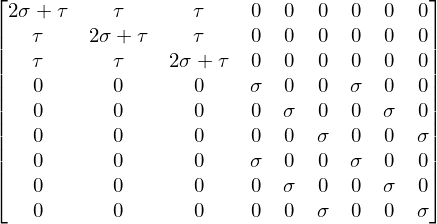

In [16]:
#tensor_to_voigt_2(term1,issymm=False)
term2_matrix

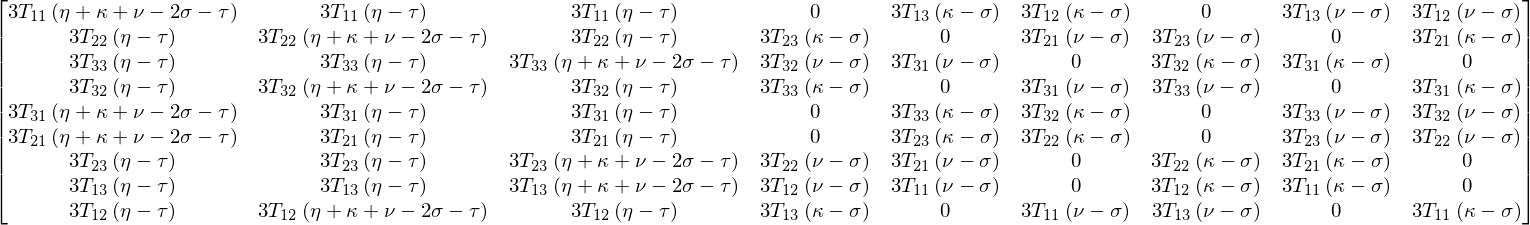

In [17]:
term3_matrix

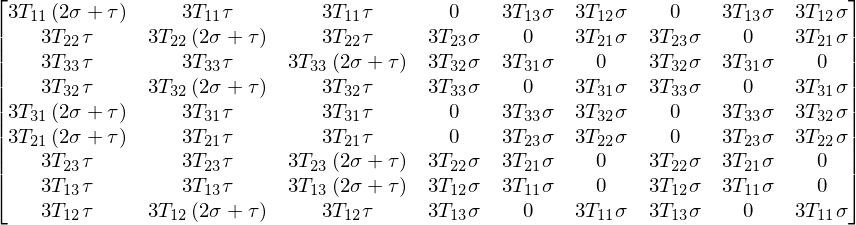

In [18]:
term4_matrix

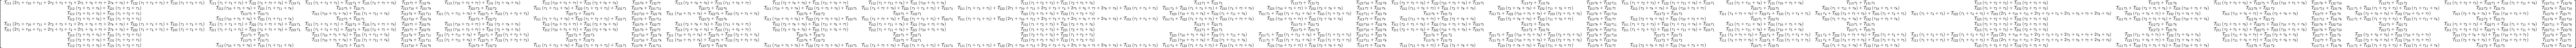

In [19]:
term5_matrix

## Symmetric Stress

The formulation of the symmetric stress tensor is identical to the Cauchy stress except we only take the symmetric parts of terms 3, 4, and 5.

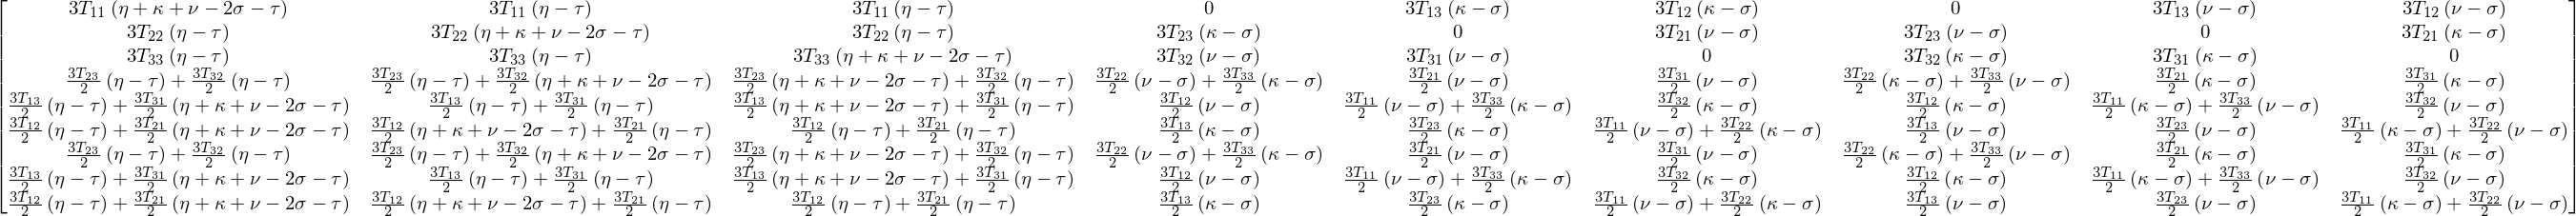

In [20]:
term3_symm = get_symm_2(term3)
term4_symm = get_symm_2(term4)
term5_symm = get_symm_2(term5)

term3_symm_matrix = sympy.Matrix(tensor_to_voigt_2(term3_symm,issymm=False)).jacobian(e_voigt)
term4_symm_matrix = sympy.Matrix(tensor_to_voigt_2(term4_symm,issymm=False)).jacobian(E_voigt)
term5_symm_matrix = sympy.Matrix(tensor_to_voigt_2(term5_symm,issymm=False)).jacobian(Gamma_voigt)
term3_symm_matrix

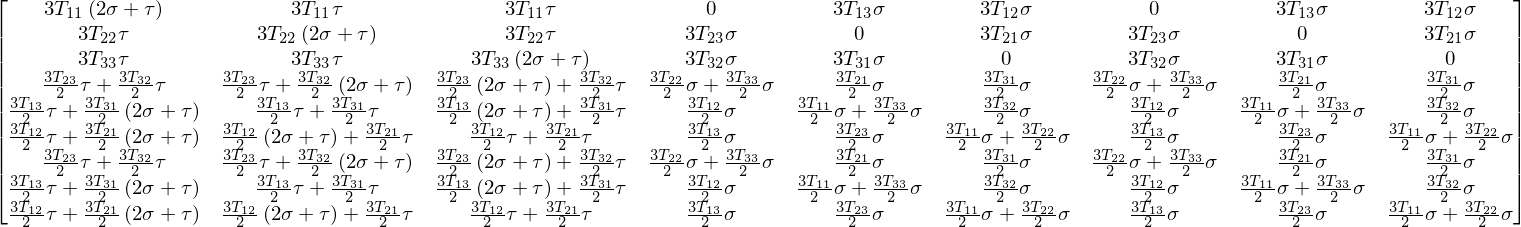

In [21]:
term4_symm_matrix

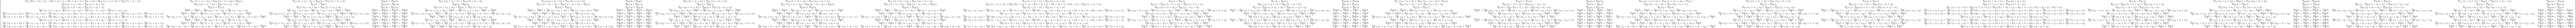

In [22]:
term5_symm_matrix

## Balance of Linear Momentum

Put the balance of linear momentum and its gradient into matrix form

In [23]:
fint = [zero for _ in range(3)]
for j in range(3):
    for I in range(3):
        for J in range(3):
            fint[j] += S[I][J]*Jhat*dNdX[I]*F[j][J]
        
fext = [zero for _ in range(3)]

for j in range(3):
    for I in range(3):
        for J in range(3):
            fext[j] += N*F[j][J]*S[I][J]*Jhat*dNdX[I]+N*rho0*b[j]*Jhat
            
fkin = [zero for _ in range(3)]

for j in range(3):
    fkin[j] += N*rho0*a[j]*Jhat

In [24]:
tmp1 = sympy.Matrix(fint).jacobian(tensor_to_voigt_2(F,issymm=False))
tmp1
[sympy.Matrix([v]).jacobian(dNdX) for v in tmp1]

In [25]:
from sympy.utilities.codegen import codegen
t = sympy.symbols('t')
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_C_voigt", ['a',C_voigt]), "C", "test", header=False, empty=False)
print(c_header)
print(c_code)

#ifndef PROJECT__TEST__H
#define PROJECT__TEST__H
double compute_C_voigt(double a, double tau1, double tau10, double tau11, double tau2, double tau3, double tau4, double tau5, double tau6, double tau7, double tau8, double tau9, double *out_109335653);
#endif

#include "test.h"
#include <math.h>
double compute_C_voigt(double a, double tau1, double tau10, double tau11, double tau2, double tau3, double tau4, double tau5, double tau6, double tau7, double tau8, double tau9, double *out_109335653) {
   out_109335653[0] = 2*tau1 + tau10 + tau11 + 2*tau2 + tau3 + tau4 + 2*tau5 + tau6 + tau7 + 2*tau8 + tau9;
   out_109335653[1] = tau1 + tau4 + tau5;
   out_109335653[2] = tau1 + tau4 + tau5;
   out_109335653[3] = 0;
   out_109335653[4] = 0;
   out_109335653[5] = 0;
   out_109335653[6] = 0;
   out_109335653[7] = 0;
   out_109335653[8] = 0;
   out_109335653[9] = 0;
   out_109335653[10] = 0;
   out_109335653[11] = 0;
   out_109335653[12] = 0;
   out_109335653[13] = 0;
   out_109335653[14] = tau2 + 

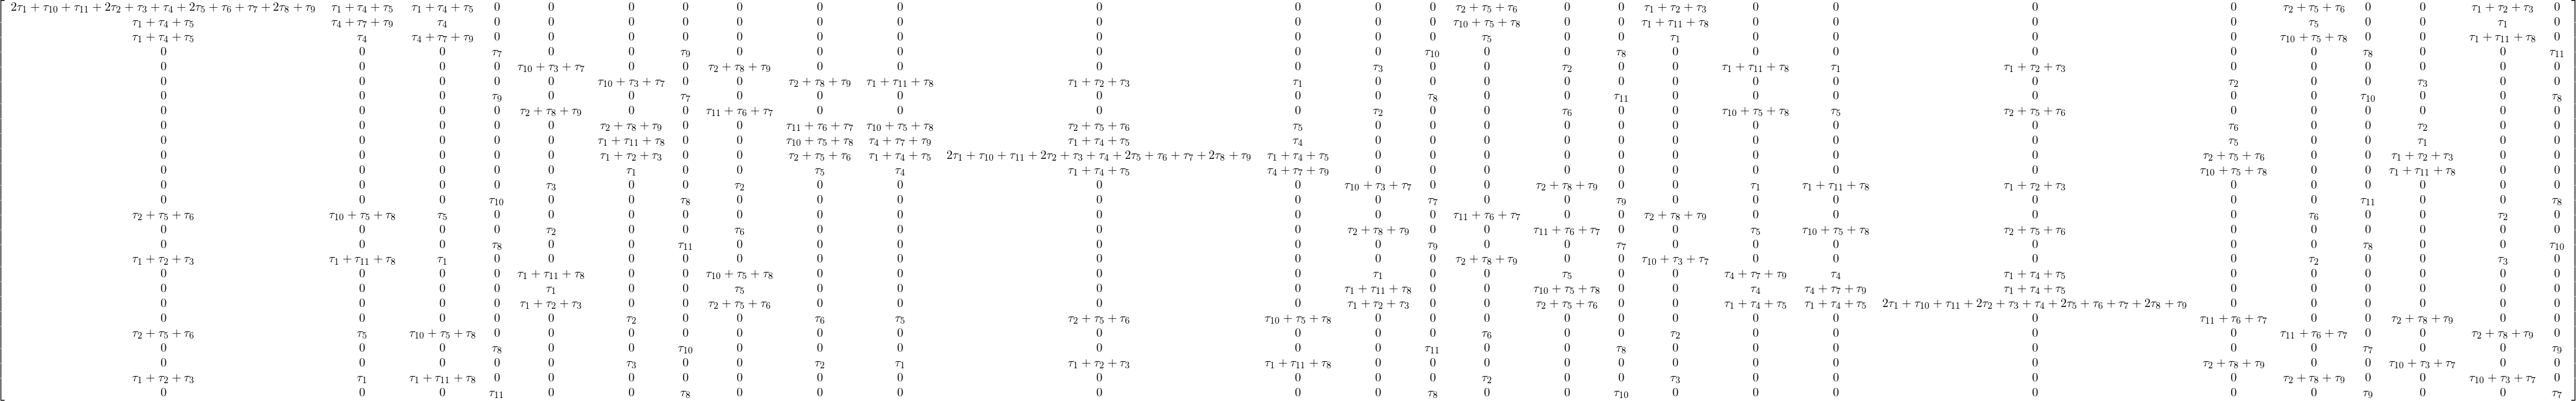

In [26]:
C_voigt

## Balance of the First Moment of Momentum

Put the balance of the first moment of momentum in matrix form.

Now we will define the gradients of the deformation measures

In [27]:
Gamma_mat = form_tensor(r'\Gamma_',[3,3,3],add_braces=True)
grad_chi  = form_tensor(r'\frac{\partial\chi}{\partial\ X}_',[3,3,3],add_braces=True)

for icap in range(3):
    for l in range(3):
        for j in range(3):
            Gamma_mat[icap][l][j] = zero
            for i in range(3):
                Gamma_mat[icap][l][j] += F[i][icap]*grad_chi[i][l][j]
Gamma_voigt = tensor_to_voigt_3(Gamma_mat)

temp_mat = [None for _ in range(3)]

for i in range(3):
    temp_mat[i] = [v for v in tensor_to_voigt_2(grad_chi[i])]
    
Alt_gamma = [[None for __ in range(9)] for _ in range(3)]
for i in range(3):
    for j in range(9):
        tmp = zero
        
        for k in range(3):
            tmp += F[k][i]*temp_mat[k][j]
            
        Alt_gamma[i][j] = tmp
tmp_Gamma = [Gamma_voigt[(i*9):(i+1)*9] for i in range(3)]
[[tmp_Gamma[i][j] - Alt_gamma[i][j] for j in range(9)] for i in range(3)]

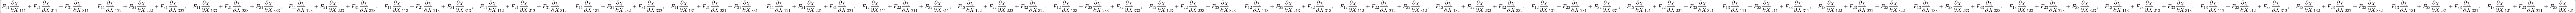

In [28]:
Gamma_voigt

In [29]:
np.random.seed(123)
grad_u = np.array([np.random.rand(3) for _ in range(3)])

print(grad_u)

Ftest_inv = (np.eye(3) - grad_u)
Ftest     = np.linalg.inv(Ftest_inv)
print(Ftest)

[[ 0.69646919  0.28613933  0.22685145]
 [ 0.55131477  0.71946897  0.42310646]
 [ 0.9807642   0.68482974  0.4809319 ]]
[[ 0.36729636 -0.77433925 -0.47066315]
 [-1.78661838  0.16546451 -0.64594197]
 [-1.6631696  -1.24478696  0.18500493]]


In [30]:
grad_u.flatten()

array([ 0.69646919,  0.28613933,  0.22685145,  0.55131477,  0.71946897,
        0.42310646,  0.9807642 ,  0.68482974,  0.4809319 ])

In [31]:
phi = np.random.rand(9)
grad_phi = np.array([[np.random.rand(3) for _ in range(3)] for __ in range(3)])
print(phi.flatten())

phi_ten = np.array(voigt_to_tensor_2(phi))
print(phi_ten)
chi = phi_ten + np.eye(3)
print(chi.flatten())

[ 0.39211752  0.34317802  0.72904971  0.43857224  0.0596779   0.39804426
  0.73799541  0.18249173  0.17545176]
[[ 0.39211752  0.39804426  0.0596779 ]
 [ 0.17545176  0.34317802  0.43857224]
 [ 0.18249173  0.73799541  0.72904971]]
[ 1.39211752  0.39804426  0.0596779   0.17545176  1.34317802  0.43857224
  0.18249173  0.73799541  1.72904971]


In [32]:
grad_phi

array([[[ 0.53155137,  0.53182759,  0.63440096],
        [ 0.84943179,  0.72445532,  0.61102351],
        [ 0.72244338,  0.32295891,  0.36178866]],

       [[ 0.22826323,  0.29371405,  0.63097612],
        [ 0.09210494,  0.43370117,  0.43086276],
        [ 0.4936851 ,  0.42583029,  0.31226122]],

       [[ 0.42635131,  0.89338916,  0.94416002],
        [ 0.50183668,  0.62395295,  0.1156184 ],
        [ 0.31728548,  0.41482621,  0.86630916]]])

In [33]:
grad_phi_map = np.zeros([3,3,3])

for i in range(3):
    for I in range(3):
        for J in range(3):
            
            for j in range(3):
                grad_phi_map[i][I][J] += grad_phi[i][I][j] * Ftest[j][J]

temp_mat = np.array([tensor_to_voigt_2(v) for v in grad_phi_map])

In [34]:
temp_mat.flatten()

array([-1.81005245, -1.29847083, -0.48170751, -0.75470999, -0.4763441 ,
       -1.11329654, -0.95632783, -0.9133694 , -1.99856773, -1.49033497,
       -0.53589066, -0.44965118, -0.24378446, -0.18042363, -0.91358478,
       -0.70051865, -1.09881086, -1.45762653, -3.00984646, -0.42927004,
       -0.25701678, -0.61784346, -0.60307115, -1.35759442, -1.25541793,
       -2.06541739, -1.12273603])

In [35]:
string_out = r"{"
for i in range(3):
    string_out += r"{"
    for I in range(3):
        string_out += r"{"
        for J in range(3):
            string_out += str(grad_phi_map[i][I][J])
            if(J<2):
                string_out += ","
        string_out += r"}"
        if(I<2):
            string_out += r","
    string_out += r"}"
    if(i<2):
        string_out += r","
string_out += r"}"
print(string_out)

{{{-1.81005244893,-1.11329653925,-0.476344104007},{-1.99856772504,-1.29847082963,-0.754709989333},{-0.913369403122,-0.956327829649,-0.481707514974}},{{-1.49033496922,-0.913584776496,-0.180423630897},{-1.45762652888,-0.535890664431,-0.243784458924},{-1.09881085987,-0.700518645554,-0.449651178371}},{{-3.0098464602,-1.35759442451,-0.603071154689},{-1.12273603044,-0.429270035631,-0.617843461246},{-2.06541739031,-1.25541792534,-0.257016784648}}}


In [36]:
temp_mat.shape

In [37]:
np.array([grad_phi[0,0],grad_phi[1,1],grad_phi[2,2],grad_phi[1,2],grad_phi[0,2],grad_phi[0,1],grad_phi[2,1],grad_phi[2,0],grad_phi[1,0]]).flatten()

array([ 0.53155137,  0.53182759,  0.63440096,  0.09210494,  0.43370117,
        0.43086276,  0.31728548,  0.41482621,  0.86630916,  0.4936851 ,
        0.42583029,  0.31226122,  0.72244338,  0.32295891,  0.36178866,
        0.84943179,  0.72445532,  0.61102351,  0.50183668,  0.62395295,
        0.1156184 ,  0.42635131,  0.89338916,  0.94416002,  0.22826323,
        0.29371405,  0.63097612])

In [38]:
#Print code for A_voigt
n = 0
for i in range(A_voigt.shape[0]):
    for j in range(A_voigt.shape[1]):
        if A_voigt[i,j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,A_voigt[i,j]))
            n += 1
print(n)

        tripletList.push_back(T(0,0,lambda + 2*mu));
        tripletList.push_back(T(0,1,lambda));
        tripletList.push_back(T(0,2,lambda));
        tripletList.push_back(T(1,0,lambda));
        tripletList.push_back(T(1,1,lambda + 2*mu));
        tripletList.push_back(T(1,2,lambda));
        tripletList.push_back(T(2,0,lambda));
        tripletList.push_back(T(2,1,lambda));
        tripletList.push_back(T(2,2,lambda + 2*mu));
        tripletList.push_back(T(3,3,mu));
        tripletList.push_back(T(3,6,mu));
        tripletList.push_back(T(4,4,mu));
        tripletList.push_back(T(4,7,mu));
        tripletList.push_back(T(5,5,mu));
        tripletList.push_back(T(5,8,mu));
        tripletList.push_back(T(6,3,mu));
        tripletList.push_back(T(6,6,mu));
        tripletList.push_back(T(7,4,mu));
        tripletList.push_back(T(7,7,mu));
        tripletList.push_back(T(8,5,mu));
        tripletList.push_back(T(8,8,mu));
21


In [39]:
#Print code for B_voigt
n = 0
for i in range(B_voigt.shape[0]):
    for j in range(B_voigt.shape[1]):
        if B_voigt[i,j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,B_voigt[i,j]))
            n += 1
print(n)

        tripletList.push_back(T(0,0,eta + kappa + nu - 2*sigma - tau));
        tripletList.push_back(T(0,1,eta - tau));
        tripletList.push_back(T(0,2,eta - tau));
        tripletList.push_back(T(1,0,eta - tau));
        tripletList.push_back(T(1,1,eta + kappa + nu - 2*sigma - tau));
        tripletList.push_back(T(1,2,eta - tau));
        tripletList.push_back(T(2,0,eta - tau));
        tripletList.push_back(T(2,1,eta - tau));
        tripletList.push_back(T(2,2,eta + kappa + nu - 2*sigma - tau));
        tripletList.push_back(T(3,3,kappa - sigma));
        tripletList.push_back(T(3,6,nu - sigma));
        tripletList.push_back(T(4,4,kappa - sigma));
        tripletList.push_back(T(4,7,nu - sigma));
        tripletList.push_back(T(5,5,kappa - sigma));
        tripletList.push_back(T(5,8,nu - sigma));
        tripletList.push_back(T(6,3,nu - sigma));
        tripletList.push_back(T(6,6,kappa - sigma));
        tripletList.push_back(T(7,4,nu - sigma));
        tripletList.push_bac

In [40]:
#Print code for C_voigt
n = 0
for i in range(C_voigt.shape[0]):
    for j in range(C_voigt.shape[1]):
        if C_voigt[i,j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,C_voigt[i,j]))
            n += 1
print(n)

        tripletList.push_back(T(0,0,2*tau1 + tau10 + tau11 + 2*tau2 + tau3 + tau4 + 2*tau5 + tau6 + tau7 + 2*tau8 + tau9));
        tripletList.push_back(T(0,1,tau1 + tau4 + tau5));
        tripletList.push_back(T(0,2,tau1 + tau4 + tau5));
        tripletList.push_back(T(0,14,tau2 + tau5 + tau6));
        tripletList.push_back(T(0,17,tau1 + tau2 + tau3));
        tripletList.push_back(T(0,22,tau2 + tau5 + tau6));
        tripletList.push_back(T(0,25,tau1 + tau2 + tau3));
        tripletList.push_back(T(1,0,tau1 + tau4 + tau5));
        tripletList.push_back(T(1,1,tau4 + tau7 + tau9));
        tripletList.push_back(T(1,2,tau4));
        tripletList.push_back(T(1,14,tau10 + tau5 + tau8));
        tripletList.push_back(T(1,17,tau1 + tau11 + tau8));
        tripletList.push_back(T(1,22,tau5));
        tripletList.push_back(T(1,25,tau1));
        tripletList.push_back(T(2,0,tau1 + tau4 + tau5));
        tripletList.push_back(T(2,1,tau4));
        tripletList.push_back(T(2,2,tau4 + tau7 + ta

        tripletList.push_back(T(22,2,tau10 + tau5 + tau8));
        tripletList.push_back(T(22,14,tau6));
        tripletList.push_back(T(22,17,tau2));
        tripletList.push_back(T(22,22,tau11 + tau6 + tau7));
        tripletList.push_back(T(22,25,tau2 + tau8 + tau9));
        tripletList.push_back(T(23,3,tau8));
        tripletList.push_back(T(23,6,tau10));
        tripletList.push_back(T(23,13,tau11));
        tripletList.push_back(T(23,16,tau8));
        tripletList.push_back(T(23,23,tau7));
        tripletList.push_back(T(23,26,tau9));
        tripletList.push_back(T(24,5,tau3));
        tripletList.push_back(T(24,8,tau2));
        tripletList.push_back(T(24,9,tau1));
        tripletList.push_back(T(24,10,tau1 + tau2 + tau3));
        tripletList.push_back(T(24,11,tau1 + tau11 + tau8));
        tripletList.push_back(T(24,21,tau2 + tau8 + tau9));
        tripletList.push_back(T(24,24,tau10 + tau3 + tau7));
        tripletList.push_back(T(25,0,tau1 + tau2 + tau3));
        triplet

In [41]:
#Print code for D_voigt
n = 0
for i in range(D_voigt.shape[0]):
    for j in range(D_voigt.shape[1]):
        if D_voigt[i,j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,D_voigt[i,j]))
            n += 1
print(n)

        tripletList.push_back(T(0,0,2*sigma + tau));
        tripletList.push_back(T(0,1,tau));
        tripletList.push_back(T(0,2,tau));
        tripletList.push_back(T(1,0,tau));
        tripletList.push_back(T(1,1,2*sigma + tau));
        tripletList.push_back(T(1,2,tau));
        tripletList.push_back(T(2,0,tau));
        tripletList.push_back(T(2,1,tau));
        tripletList.push_back(T(2,2,2*sigma + tau));
        tripletList.push_back(T(3,3,sigma));
        tripletList.push_back(T(3,6,sigma));
        tripletList.push_back(T(4,4,sigma));
        tripletList.push_back(T(4,7,sigma));
        tripletList.push_back(T(5,5,sigma));
        tripletList.push_back(T(5,8,sigma));
        tripletList.push_back(T(6,3,sigma));
        tripletList.push_back(T(6,6,sigma));
        tripletList.push_back(T(7,4,sigma));
        tripletList.push_back(T(7,7,sigma));
        tripletList.push_back(T(8,5,sigma));
        tripletList.push_back(T(8,8,sigma));
21


In [42]:
temp3

In [43]:
tmp = np.array(range(27)).reshape([3,3,3])

swap = np.zeros([3,3,3]).astype(int)

for i in range(3):
    for j in range(3):
        for k in range(3):
            swap[j,k,i] = tmp[i,j,k]
print(tensor_to_voigt_3(tmp))
print(tensor_to_voigt_3(swap))

[0, 4, 8, 5, 2, 1, 7, 6, 3, 9, 13, 17, 14, 11, 10, 16, 15, 12, 18, 22, 26, 23, 20, 19, 25, 24, 21]
[0, 10, 20, 19, 18, 9, 11, 2, 1, 3, 13, 23, 22, 21, 12, 14, 5, 4, 6, 16, 26, 25, 24, 15, 17, 8, 7]


In [44]:
np.random.seed(1234)
params = np.random.rand(18)

_lambda,_mu,_eta,_tau,_kappa,_nu,_sigma,_tau1,_tau2,_tau3,_tau4,_tau5,_tau6,_tau7,_tau8,_tau9,_tau10,_tau11 = params

params_dict = dict(zip([lamb,mu,eta,tau,kappa,nu,sigma,tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11],params))

In [45]:
print_tensor_info(A,"A",nspaces=4,params=params_dict)

    A(0, 0, 0, 0) = 1.43573699245856;
    A(0, 0, 1, 1) = 0.191519450378892;
    A(0, 0, 2, 2) = 0.191519450378892;
    A(0, 1, 0, 1) = 0.622108771039832;
    A(0, 1, 1, 0) = 0.622108771039832;
    A(0, 2, 0, 2) = 0.622108771039832;
    A(0, 2, 2, 0) = 0.622108771039832;
    A(1, 0, 0, 1) = 0.622108771039832;
    A(1, 0, 1, 0) = 0.622108771039832;
    A(1, 1, 0, 0) = 0.191519450378892;
    A(1, 1, 1, 1) = 1.43573699245856;
    A(1, 1, 2, 2) = 0.191519450378892;
    A(1, 2, 1, 2) = 0.622108771039832;
    A(1, 2, 2, 1) = 0.622108771039832;
    A(2, 0, 0, 2) = 0.622108771039832;
    A(2, 0, 2, 0) = 0.622108771039832;
    A(2, 1, 1, 2) = 0.622108771039832;
    A(2, 1, 2, 1) = 0.622108771039832;
    A(2, 2, 0, 0) = 0.191519450378892;
    A(2, 2, 1, 1) = 0.191519450378892;
    A(2, 2, 2, 2) = 1.43573699245856;


In [46]:
print_tensor_info(B,"B",nspaces=4,params=params_dict)

    B(0, 0, 0, 0) = 0.152009058408597;
    B(0, 0, 1, 1) = -0.347630844706655;
    B(0, 0, 2, 2) = -0.347630844706655;
    B(0, 1, 0, 1) = 0.503511552975707;
    B(0, 1, 1, 0) = -0.00387164986045507;
    B(0, 2, 0, 2) = 0.503511552975707;
    B(0, 2, 2, 0) = -0.00387164986045507;
    B(1, 0, 0, 1) = -0.00387164986045507;
    B(1, 0, 1, 0) = 0.503511552975707;
    B(1, 1, 0, 0) = -0.347630844706655;
    B(1, 1, 1, 1) = 0.152009058408597;
    B(1, 1, 2, 2) = -0.347630844706655;
    B(1, 2, 1, 2) = 0.503511552975707;
    B(1, 2, 2, 1) = -0.00387164986045507;
    B(2, 0, 0, 2) = -0.00387164986045507;
    B(2, 0, 2, 0) = 0.503511552975707;
    B(2, 1, 1, 2) = -0.00387164986045507;
    B(2, 1, 2, 1) = 0.503511552975707;
    B(2, 2, 0, 0) = -0.347630844706655;
    B(2, 2, 1, 1) = -0.347630844706655;
    B(2, 2, 2, 2) = 0.152009058408597;


In [47]:
print_tensor_info(C,"C",nspaces=4,params=params_dict)

    C(0, 0, 0, 0, 0, 0) = 8.97047749088427;
    C(0, 0, 0, 0, 1, 1) = 1.66068457301634;
    C(0, 0, 0, 0, 2, 2) = 1.66068457301634;
    C(0, 0, 0, 1, 0, 1) = 2.14259741437930;
    C(0, 0, 0, 1, 1, 0) = 2.63594416596082;
    C(0, 0, 0, 2, 0, 2) = 2.14259741437930;
    C(0, 0, 0, 2, 2, 0) = 2.63594416596082;
    C(0, 0, 1, 0, 0, 1) = 2.09171782703280;
    C(0, 0, 1, 0, 1, 0) = 1.88958629453973;
    C(0, 0, 1, 1, 0, 0) = 1.18589138191610;
    C(0, 0, 1, 1, 1, 1) = 2.63594416596082;
    C(0, 0, 1, 1, 2, 2) = 0.801872177535019;
    C(0, 0, 1, 2, 1, 2) = 0.958139353683705;
    C(0, 0, 1, 2, 2, 1) = 0.875932634742095;
    C(0, 0, 2, 0, 0, 2) = 2.09171782703280;
    C(0, 0, 2, 0, 2, 0) = 1.88958629453973;
    C(0, 0, 2, 1, 1, 2) = 0.875932634742095;
    C(0, 0, 2, 1, 2, 1) = 0.958139353683705;
    C(0, 0, 2, 2, 0, 0) = 1.18589138191610;
    C(0, 0, 2, 2, 1, 1) = 0.801872177535019;
    C(0, 0, 2, 2, 2, 2) = 2.63594416596082;
    C(0, 1, 0, 0, 0, 1) = 1.88958629453973;
    C(0, 1, 0, 0, 1, 0) = 

In [48]:
print_tensor_info(D,"D",nspaces=4,params=params_dict)

    D(0, 0, 0, 0) = 1.33828709399996;
    D(0, 0, 1, 1) = 0.785358583713769;
    D(0, 0, 2, 2) = 0.785358583713769;
    D(0, 1, 0, 1) = 0.276464255143097;
    D(0, 1, 1, 0) = 0.276464255143097;
    D(0, 2, 0, 2) = 0.276464255143097;
    D(0, 2, 2, 0) = 0.276464255143097;
    D(1, 0, 0, 1) = 0.276464255143097;
    D(1, 0, 1, 0) = 0.276464255143097;
    D(1, 1, 0, 0) = 0.785358583713769;
    D(1, 1, 1, 1) = 1.33828709399996;
    D(1, 1, 2, 2) = 0.785358583713769;
    D(1, 2, 1, 2) = 0.276464255143097;
    D(1, 2, 2, 1) = 0.276464255143097;
    D(2, 0, 0, 2) = 0.276464255143097;
    D(2, 0, 2, 0) = 0.276464255143097;
    D(2, 1, 1, 2) = 0.276464255143097;
    D(2, 1, 2, 1) = 0.276464255143097;
    D(2, 2, 0, 0) = 0.785358583713769;
    D(2, 2, 1, 1) = 0.785358583713769;
    D(2, 2, 2, 2) = 1.33828709399996;


In [49]:
A_num = A_voigt.subs({lamb:_lambda,mu:_mu})
print("lambda {0}\nmu {1}".format(_lambda,_mu))
#Print code for A_voigt
n = 0
for i in range(A_voigt.shape[0]):
    for j in range(A_voigt.shape[1]):
        if A_num[i,j] != zero:
            print(r"    tripletList.push_back(T({0},{1},{2}));".format(i,j,A_num[i,j]))
            n += 1
print(n)

lambda 0.191519450379
mu 0.62210877104
    tripletList.push_back(T(0,0,1.43573699245856));
    tripletList.push_back(T(0,1,0.191519450378892));
    tripletList.push_back(T(0,2,0.191519450378892));
    tripletList.push_back(T(1,0,0.191519450378892));
    tripletList.push_back(T(1,1,1.43573699245856));
    tripletList.push_back(T(1,2,0.191519450378892));
    tripletList.push_back(T(2,0,0.191519450378892));
    tripletList.push_back(T(2,1,0.191519450378892));
    tripletList.push_back(T(2,2,1.43573699245856));
    tripletList.push_back(T(3,3,0.622108771039832));
    tripletList.push_back(T(3,6,0.622108771039832));
    tripletList.push_back(T(4,4,0.622108771039832));
    tripletList.push_back(T(4,7,0.622108771039832));
    tripletList.push_back(T(5,5,0.622108771039832));
    tripletList.push_back(T(5,8,0.622108771039832));
    tripletList.push_back(T(6,3,0.622108771039832));
    tripletList.push_back(T(6,6,0.622108771039832));
    tripletList.push_back(T(7,4,0.622108771039832));
    triple

In [50]:
B_num = B_voigt.subs({eta:_eta,tau:_tau,kappa:_kappa,sigma:_sigma,nu:_nu})
for i in range(B_voigt.shape[0]):
    for j in range(B_voigt.shape[1]):
        if B_num[i,j] != zero:
            print(r"    tripletList.push_back(T({0},{1},{2}));".format(i,j,B_num[i,j]))
            n += 1

    tripletList.push_back(T(0,0,0.152009058408597));
    tripletList.push_back(T(0,1,-0.347630844706655));
    tripletList.push_back(T(0,2,-0.347630844706655));
    tripletList.push_back(T(1,0,-0.347630844706655));
    tripletList.push_back(T(1,1,0.152009058408597));
    tripletList.push_back(T(1,2,-0.347630844706655));
    tripletList.push_back(T(2,0,-0.347630844706655));
    tripletList.push_back(T(2,1,-0.347630844706655));
    tripletList.push_back(T(2,2,0.152009058408597));
    tripletList.push_back(T(3,3,0.503511552975707));
    tripletList.push_back(T(3,6,-0.00387164986045507));
    tripletList.push_back(T(4,4,0.503511552975707));
    tripletList.push_back(T(4,7,-0.00387164986045507));
    tripletList.push_back(T(5,5,0.503511552975707));
    tripletList.push_back(T(5,8,-0.00387164986045507));
    tripletList.push_back(T(6,3,-0.00387164986045507));
    tripletList.push_back(T(6,6,0.503511552975707));
    tripletList.push_back(T(7,4,-0.00387164986045507));
    tripletList.push_back

In [51]:
print(_eta, _kappa, _nu, _sigma, _tau)

(0.43772773900711448, 0.77997580811880352, 0.27259260528264162, 0.27646425514309669, 0.78535858371376921)


In [52]:
print(_tau1,_tau2,_tau3,_tau4,_tau5,_tau6,_tau7,_tau8,_tau9,_tau10,_tau11)

(0.80187217753501927, 0.95813935368370517, 0.87593263474209471, 0.35781726995786667, 0.50099512552345871, 0.6834629351721363, 0.71270202698290019, 0.37025075479039493, 0.56119618606562494, 0.50308316530780972, 0.013768449590682241)


In [53]:
C_num = C_voigt.subs({tau1:_tau1,tau2:_tau2,tau3:_tau3,tau4:_tau4,\
                      tau5:_tau5,tau6:_tau6,tau7:_tau7,tau8:_tau8,\
                      tau9:_tau9,tau10:_tau10,tau11:_tau11})
n = 0
for i in range(C_voigt.shape[0]):
    for j in range(C_voigt.shape[1]):
        if C_voigt[i,j] != zero:
            print(r"    tripletList.push_back(T({0},{1},{2}));".format(i,j,C_num[i,j]))
            n += 1

    tripletList.push_back(T(0,0,8.97047749088427));
    tripletList.push_back(T(0,1,1.66068457301634));
    tripletList.push_back(T(0,2,1.66068457301634));
    tripletList.push_back(T(0,14,2.14259741437930));
    tripletList.push_back(T(0,17,2.63594416596082));
    tripletList.push_back(T(0,22,2.14259741437930));
    tripletList.push_back(T(0,25,2.63594416596082));
    tripletList.push_back(T(1,0,1.66068457301634));
    tripletList.push_back(T(1,1,1.63171548300639));
    tripletList.push_back(T(1,2,0.357817269957867));
    tripletList.push_back(T(1,14,1.37432904562166));
    tripletList.push_back(T(1,17,1.18589138191610));
    tripletList.push_back(T(1,22,0.500995125523459));
    tripletList.push_back(T(1,25,0.801872177535019));
    tripletList.push_back(T(2,0,1.66068457301634));
    tripletList.push_back(T(2,1,0.357817269957867));
    tripletList.push_back(T(2,2,1.63171548300639));
    tripletList.push_back(T(2,14,0.500995125523459));
    tripletList.push_back(T(2,17,0.801872177535019

In [54]:
D_num = D_voigt.subs({sigma:_sigma,tau:_tau})
#Print code for D_voigt
n = 0
for i in range(D_voigt.shape[0]):
    for j in range(D_voigt.shape[1]):
        if D_voigt[i,j] != zero:
            print(r"    tripletList.push_back(T({0},{1},{2}));".format(i,j,D_num[i,j]))
            n += 1

    tripletList.push_back(T(0,0,1.33828709399996));
    tripletList.push_back(T(0,1,0.785358583713769));
    tripletList.push_back(T(0,2,0.785358583713769));
    tripletList.push_back(T(1,0,0.785358583713769));
    tripletList.push_back(T(1,1,1.33828709399996));
    tripletList.push_back(T(1,2,0.785358583713769));
    tripletList.push_back(T(2,0,0.785358583713769));
    tripletList.push_back(T(2,1,0.785358583713769));
    tripletList.push_back(T(2,2,1.33828709399996));
    tripletList.push_back(T(3,3,0.276464255143097));
    tripletList.push_back(T(3,6,0.276464255143097));
    tripletList.push_back(T(4,4,0.276464255143097));
    tripletList.push_back(T(4,7,0.276464255143097));
    tripletList.push_back(T(5,5,0.276464255143097));
    tripletList.push_back(T(5,8,0.276464255143097));
    tripletList.push_back(T(6,3,0.276464255143097));
    tripletList.push_back(T(6,6,0.276464255143097));
    tripletList.push_back(T(7,4,0.276464255143097));
    tripletList.push_back(T(7,7,0.276464255143097

In [55]:
print(_sigma,_tau)

(0.27646425514309669, 0.78535858371376921)


In [56]:
for i,v in enumerate(params):
    print("     params[{0}] = {1};".format(i,v))

     params[0] = 0.191519450379;
     params[1] = 0.62210877104;
     params[2] = 0.437727739007;
     params[3] = 0.785358583714;
     params[4] = 0.779975808119;
     params[5] = 0.272592605283;
     params[6] = 0.276464255143;
     params[7] = 0.801872177535;
     params[8] = 0.958139353684;
     params[9] = 0.875932634742;
     params[10] = 0.357817269958;
     params[11] = 0.500995125523;
     params[12] = 0.683462935172;
     params[13] = 0.712702026983;
     params[14] = 0.37025075479;
     params[15] = 0.561196186066;
     params[16] = 0.503083165308;
     params[17] = 0.0137684495907;


In [57]:
RCGinvtest = np.linalg.inv(np.dot(Ftest.T,Ftest))
RCGinvtest

array([[ 0.22546826, -0.15162967, -0.21948678],
       [-0.15162967,  0.56166471,  0.12897273],
       [-0.21948678,  0.12897273,  1.70032187]])

In [58]:
Etest = 0.5*(np.dot(Ftest.T,Ftest) - np.eye(3))
Etest

array([[ 2.54652249,  0.74512895,  0.33674219],
       [ 0.74512895,  0.58823718,  0.01364038],
       [ 0.33674219,  0.01364038, -0.16350417]])

In [59]:
Psitest = np.dot(Ftest.transpose(),chi) - np.eye(3)
Psitest

array([[-1.10566034, -3.48095785, -3.63734467],
       [-1.27610353, -2.00462005, -2.12594132],
       [-0.73478821, -0.91842704, -0.99149769]])

In [60]:
np.dot(Ftest.transpose(),chi)

array([[-0.10566034, -3.48095785, -3.63734467],
       [-1.27610353, -1.00462005, -2.12594132],
       [-0.73478821, -0.91842704,  0.00850231]])

In [61]:
phitest = np.array(tensor_to_voigt_2(chi-np.eye(3))).reshape([3,3])
chitest = phitest + np.eye(3)
phitest

array([[ 0.39211752,  0.34317802,  0.72904971],
       [ 0.43857224,  0.0596779 ,  0.39804426],
       [ 0.73799541,  0.18249173,  0.17545176]])

In [62]:
chitest

array([[ 1.39211752,  0.34317802,  0.72904971],
       [ 0.43857224,  1.0596779 ,  0.39804426],
       [ 0.73799541,  0.18249173,  1.17545176]])

In [63]:
Psitest = np.dot(Ftest.T,chitest)
Psitest

array([[-1.49965306, -2.07070667, -2.39835151],
       [-1.92405015, -0.31756045, -1.96185662],
       [-0.80197786, -0.81224981, -0.38278596]])

In [64]:
etest = Psitest - np.eye(3)
etest

array([[-2.49965306, -2.07070667, -2.39835151],
       [-1.92405015, -1.31756045, -1.96185662],
       [-0.80197786, -0.81224981, -1.38278596]])

In [65]:
Gammatest = np.zeros([3,3,3])

grad_phi_ref = np.zeros([3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                grad_phi_ref[i,j,k] += grad_phi[i,j,l]*Ftest[l,k]
        
for i in range(3):
    for j in range(3):
        for k in range(3):
            
            for l in range(3):
                Gammatest[i,j,k] += Ftest[l,i]*grad_phi_ref[l,j,k]
Gammatest

array([[[ 7.00371932,  3.48122737,  1.15039833],
        [ 3.73745614,  1.19445738,  1.18592603],
        [ 5.06281784,  2.98827669,  1.05388815]],

       [[ 4.90161472,  2.40081918,  1.08969334],
        [ 2.70395114,  1.45113579,  1.31314737],
        [ 3.0964482 ,  2.18733906,  0.61853487]],

       [[ 1.25775848,  0.86294876,  0.22916968],
        [ 1.67448265,  0.87787958,  0.39838071],
        [ 0.75754498,  0.67034417,  0.46962118]]])

In [66]:
np.dot(np.array(A_num),tensor_to_voigt_2(Etest))

array([3.73748117409367, 1.30094823241065, 0.365618464350026,
       0.0169715997966814, 0.418980535143162, 0.927102507351979,
       0.0169715997966814, 0.418980535143162, 0.927102507351979], dtype=object)

In [67]:
Atest = np.zeros([3,3,3,3])
Btest = np.zeros([3,3,3,3])
Ctest = np.zeros([3,3,3,3,3,3])
Dtest = np.zeros([3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                Atest[i][j][k][l] = A[i][j][k][l].subs({lamb:_lambda,mu:_mu})
                Btest[i][j][k][l] = B[i][j][k][l].subs({eta:_eta, kappa:_kappa, nu:_nu, sigma:_sigma, tau:_tau})
                for m in range(3):
                    for n in range(3):
                        Ctest[i][j][k][l][m][n] = C[i][j][k][l][m][n].subs({tau1:_tau1,tau2:_tau2,tau3:_tau3,tau4:_tau4,\
                      tau5:_tau5,tau6:_tau6,tau7:_tau7,tau8:_tau8,\
                      tau9:_tau9,tau10:_tau10,tau11:_tau11})
                Dtest[i][j][k][l] = D[i][j][k][l].subs({sigma:_sigma,tau:_tau})

In [68]:
term1  = np.zeros([3,3])
term2  = np.zeros([3,3])
term3  = np.zeros([3,3])
term4  = np.zeros([3,3])
term5  = np.zeros([3,3])

temp1  = np.zeros([3,3])
temp2  = np.zeros([3,3])
temp3  = np.zeros([3,3])
temp4  = np.zeros([3,3,3])
temp5  = np.zeros([3,3,3])

T3     = np.zeros([3,3])
T4     = np.zeros([3,3,3])

for i in range(3):
    for j in range(3):
        
        term1[i][j] = 0.
        term2[i][j] = 0.
        temp1[i][j] = 0.
        temp2[i][j] = 0.
        
        for k in range(3):
            for l in range(3):
                term1[i][j] += Atest[i][j][k][l]*Etest[k][l]
                term2[i][j] += Dtest[i][j][k][l]*etest[k][l]
                temp1[i][j] += Btest[i][j][k][l]*etest[k][l]
                temp2[i][j] += Dtest[i][j][k][l]*Etest[k][l]
                
for j in range(3):
    for q in range(3):
        
        temp3[j][q] = zero
        
        for t in range(3):
            temp3[j][q] += RCGinvtest[t][j]*Psitest[t][q]

for j in range(3):
    for q in range(3):
        for r in range(3):
            temp4[j][q][r] = zero
            
            for s in range(3):
                temp4[j][q][r] += RCGinvtest[j][s]*Gammatest[s][q][r]
            
for i in range(3):
    for j in range(3):
        
        term3[i][j] = zero
        term4[i][j] = zero
        
        for q in range(3):
            term3[i][j] += temp1[i][q]*temp3[j][q]
            term4[i][j] += temp2[i][q]*temp3[j][q]
            
for i in range(3):
    for q in range(3):
        for r in range(3):
            temp5[i][q][r] = zero
            
            for l in range(3):
                for m in range(3):
                    for n in range(3):
                        temp5[i][q][r] += Ctest[i][q][r][l][m][n]*Gammatest[l][m][n]
                        
for i in range(3):
    for j in range(3):
        term5[i][j] = zero
        
        for q in range(3):
            for r in range(3):
                term5[i][j] += temp5[i][q][r]*temp4[j][q][r]

In [69]:
tensor_to_voigt_2(term3+term4)

In [70]:
test = np.dot(np.array(A_voigt.subs({lamb:_lambda,mu:_mu})).astype(float),tensor_to_voigt_2(Etest))
test

array([ 3.73748117,  1.30094823,  0.36561846,  0.0169716 ,  0.41898054,
        0.92710251,  0.0169716 ,  0.41898054,  0.92710251])

In [71]:
print(Etest)

[[ 2.54652249  0.74512895  0.33674219]
 [ 0.74512895  0.58823718  0.01364038]
 [ 0.33674219  0.01364038 -0.16350417]]


In [72]:
print(etest)

[[-2.49965306 -2.07070667 -2.39835151]
 [-1.92405015 -1.31756045 -1.96185662]
 [-0.80197786 -0.81224981 -1.38278596]]


In [73]:
np.dot(np.array(B_voigt.subs({eta:_eta,kappa:_kappa,nu:_nu,sigma:_sigma,tau:_tau})).astype(float),tensor_to_voigt_2(etest))

array([ 0.55875379,  1.14937443,  1.11678517, -0.98467273, -1.20449272,
       -1.03517548, -0.40138154, -0.39451954, -0.96076443])

In [74]:
np.array(tensor_to_voigt_2(term1)).astype(float) + np.array(tensor_to_voigt_2(term2)).astype(float) + np.array(tensor_to_voigt_2(term3)).astype(float) + np.array(tensor_to_voigt_2(term4)).astype(float) + np.array(tensor_to_voigt_2(term5))

array([  59.03427247,  160.14321551,  105.82494785,  214.53178439,
        237.37311424,  249.55639324,  110.81529   ,   25.70187797,
         17.88329254])

In [75]:
temp1+temp2

array([[ 4.30029969, -0.62317245, -1.01829836],
       [-0.54876139,  3.80812855, -0.97713057],
       [-0.20832518, -0.39383939,  3.35988006]])

In [76]:
term1

array([[ 3.73748117,  0.92710251,  0.41898054],
       [ 0.92710251,  1.30094823,  0.0169716 ],
       [ 0.41898054,  0.0169716 ,  0.36561846]])

In [77]:
term2

array([[-5.46599366, -1.10440747, -0.88477667],
       [-1.10440747, -4.81238095, -0.76694127],
       [-0.88477667, -0.76694127, -4.848446  ]])

In [78]:
term3+term4

array([[ 0.8695168 , -3.33135597, -4.52829855],
       [-0.83118543,  1.41212675, -2.61185827],
       [-0.46740405, -2.45913293, -0.62002317]])

In [79]:
print(term4)

[[ 0.35634422 -3.71351828 -5.26788636]
 [-0.58708268 -0.3180596  -3.10376646]
 [-0.33491012 -1.94459316 -1.09283432]]


In [80]:
print(term5)

[[  59.89326816  253.06505417  242.36720893]
 [  18.89178293  162.24252149  217.89361233]
 [  26.63507815  114.0243926   110.92779856]]


In [81]:
print(term1+term2+term3+term4+term5)

[[  59.03427247  249.55639324  237.37311424]
 [  17.88329254  160.14321551  214.53178439]
 [  25.70187797  110.81529     105.82494785]]


In [82]:
symm_part = term3 + term4 + term5
symm_part += symm_part.T
print(tensor_to_voigt_2(term1 + term2 + symm_part))
print(term1+term2+symm_part)

[119.79705742647148, 323.79786374117901, 216.13272323537967, 326.09704405452692, 263.54078834196645, 267.61699074207667, 326.09704405452692, 263.54078834196645, 267.61699074207667]
[[ 119.79705743  267.61699074  263.54078834]
 [ 267.61699074  323.79786374  326.09704405]
 [ 263.54078834  326.09704405  216.13272324]]


In [83]:
M_num = np.zeros([3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
        
            for l in range(3):
                for m in range(3):
                    for n in range(3):
                        M_num[i,j,k] += Ctest[j][k][i][l][m][n]*Gammatest[l,m,n]
print(tensor_to_voigt_3(M_num))
print(M_num)

[81.319817064872794, 31.798586060251196, 27.355416705438898, 4.4605220584734777, 15.239752824275831, 22.917719613671593, 4.7616615344445723, 13.617364734132281, 20.631211107480645, 25.446753288061672, 41.989352291441641, 17.274366600902034, 12.970633348345523, 4.2954945456241571, 21.185457632363427, 10.684683278867412, 4.6586459786087913, 26.552528036554317, 18.652351528895451, 16.025982693606071, 29.787283731069451, 11.179442364112674, 18.362354222680963, 4.5594524813999673, 14.133232412473214, 23.039150848588068, 4.849232622884017]
[[[ 81.31981706  22.91771961  15.23975282]
  [ 20.63121111  31.79858606   4.46052206]
  [ 13.61736473   4.76166153  27.35541671]]

 [[ 25.44675329  21.18545763   4.29549455]
  [ 26.55252804  41.98935229  12.97063335]
  [  4.65864598  10.68468328  17.2743666 ]]

 [[ 18.65235153   4.55945248  18.36235422]
  [  4.84923262  16.02598269  11.17944236]
  [ 23.03915085  14.13323241  29.78728373]]]


In [84]:
Jac_num = np.linalg.det(Ftest)
cauchy  = np.zeros([3,3])
PK2_num = term1+term2+term3+term4+term5

for i in range(3):
    for j in range(3):
        
        for I in range(3):
            for J in range(3):
                cauchy[i,j] += Ftest[i,I]*PK2_num[I,J]*Ftest[j,J]/Jac_num
print(tensor_to_voigt_2(cauchy))
print(cauchy)

[-48.843293148136098, -167.47094085138676, -318.99997557253624, -284.39612665242475, -34.713215450729834, -30.136059986911285, -205.35807451733302, -282.42756314420473, -216.42140582053761]
[[ -48.84329315  -30.13605999  -34.71321545]
 [-216.42140582 -167.47094085 -284.39612665]
 [-282.42756314 -205.35807452 -318.99997557]]


In [85]:
Jac_num = np.linalg.det(Ftest)
s       = np.zeros([3,3])
SIGMA_num = term1+term2+symm_part

for i in range(3):
    for j in range(3):
        
        for I in range(3):
            for J in range(3):
                s[i,j] += Ftest[i,I]*SIGMA_num[I,J]*Ftest[j,J]/Jac_num
print(tensor_to_voigt_2(s))
print(s)

[-99.105822068356929, -338.19674161378447, -642.11182251751961, -491.79299236304314, -318.24505273925809, -246.80573906238055, -491.7929923630432, -318.24505273925814, -246.80573906238055]
[[ -99.10582207 -246.80573906 -318.24505274]
 [-246.80573906 -338.19674161 -491.79299236]
 [-318.24505274 -491.79299236 -642.11182252]]


In [86]:
Jac_num = np.linalg.det(Ftest)
m       = np.zeros([3,3,3])

print(Jac_num)

string = r"{"
for i in range(3):
    for j in range(3):
        for k in range(3):
            for I in range(3):
                for J in range(3):
                    for K in range(3):
                        m[i,j,k] += Ftest[i,I]*Ftest[j,J]*chitest[k,K]*M_num[I,J,K]/Jac_num
            string += str(m[i,j,k]) + r", "
string += r"}"
print(string)
print(tensor_to_voigt_3(m))
print(m)
#tensor_to_voigt_3(M_num)
tmp = tensor_to_voigt_3(M_num)
np.array([tmp[i*9:(i+1)*9] for i in range(3)])
tensor_to_voigt_3(M_num)

-2.54817091741
{-17.1532653924, -15.6197899736, -14.1790720652, -9.37069422182, -12.480771017, -11.2662874651, -21.8470827864, -27.0688866912, -19.1472252454, -7.1496916495, -18.6798372466, -12.0714792605, -200.623133375, -97.4279956287, -139.983617438, -197.655799765, -118.738663561, -125.865189737, -20.3962546043, -32.8650191127, -21.8369236411, -201.040912361, -109.58264685, -132.896569764, -239.606569249, -165.24571159, -145.890979683, }
[-17.153265392410479, -12.480771016951504, -19.147225245448585, -11.266287465129828, -14.179072065222963, -15.619789973641112, -27.068886691230073, -21.847082786416419, -9.3706942218191571, -7.1496916494968481, -97.427995628681003, -125.86518973715341, -139.98361743799688, -12.071479260463592, -18.679837246649885, -118.73866356078584, -197.65579976538379, -200.62313337544697, -20.396254604325666, -109.5826468499386, -145.89097968348054, -132.89656976443464, -21.836923641098753, -32.865019112732554, -165.2457115903091, -239.60656924947352, -201.0409

In [87]:
Jac_num = np.linalg.det(Ftest)
m       = np.zeros([3,3,3])

print(Jac_num)

string = r"{"
for i in range(3):
    for j in range(3):
        for k in range(3):
            for I in range(3):
                for J in range(3):
                    for K in range(3):
                        m[i,j,k] += Ftest[i,I]*Ftest[j,J]*chitest[k,K]*M_num[I,J,K]#/Jac_num
print(m)

-2.54817091741
[[[  43.70945201   39.80189455   36.13069907]
  [  23.87813049   31.80313773   28.70842607]
  [  55.67010099   68.97614983   48.79040252]]

 [[  18.21863633   47.59941801   30.76019238]
  [ 511.22203383  248.263185    356.70218287]
  [ 503.66076062  302.56640926  320.726016  ]]

 [[  51.97314281   83.7456859    55.64421375]
  [ 512.28660609  279.23531376  338.6431741 ]
  [ 610.55849138  421.0743165   371.75515154]]]


Derive a right positive cycle of Gamma

In [88]:
Atot = form_tensor('A',[3,3,3])
Atot_cycle = form_tensor('_A',[3,3,3])
indices       = form_tensor('dummy',[3,3,3])
indices_cycle = form_tensor('dummy',[3,3,3])

n = 0
for i in range(3):
    for j in range(3):
        for k in range(3):
            Atot_cycle[j][k][i] = Atot[i][j][k]
            indices[i][j][k]       = (i,j,k)
            indices_cycle[j][k][i] = (i,j,k)
            n += 1
Atot_cycle_voigt = tensor_to_voigt_3(Atot_cycle)
indices_voigt          = tensor_to_voigt_3(indices)
indices_cycle_voigt    = tensor_to_voigt_3(indices_cycle)

print(Atot_cycle_voigt)
indices_cycle_voigt

for i,(iv,icv) in enumerate(zip(indices_voigt,indices_cycle_voigt)):
    j = indices_voigt.index(icv)
    print("        swap[{0}] = A[{1}];".format(i,j))

[A111, A212, A313, A312, A311, A211, A213, A113, A112, A121, A222, A323, A322, A321, A221, A223, A123, A122, A131, A232, A333, A332, A331, A231, A233, A133, A132]
        swap[0] = A[0];
        swap[1] = A[14];
        swap[2] = A[22];
        swap[3] = A[23];
        swap[4] = A[18];
        swap[5] = A[9];
        swap[6] = A[13];
        swap[7] = A[4];
        swap[8] = A[5];
        swap[9] = A[8];
        swap[10] = A[10];
        swap[11] = A[21];
        swap[12] = A[19];
        swap[13] = A[26];
        swap[14] = A[17];
        swap[15] = A[12];
        swap[16] = A[3];
        swap[17] = A[1];
        swap[18] = A[7];
        swap[19] = A[15];
        swap[20] = A[20];
        swap[21] = A[24];
        swap[22] = A[25];
        swap[23] = A[16];
        swap[24] = A[11];
        swap[25] = A[2];
        swap[26] = A[6];


In [89]:
Atot = form_tensor('A',[3,3,3])
Atot_cycle = form_tensor('_A',[3,3,3])
indices       = form_tensor('dummy',[3,3,3])
indices_cycle = form_tensor('dummy',[3,3,3])

n = 0
for i in range(3):
    for j in range(3):
        for k in range(3):
            Atot_cycle[j][k][i] = Atot[i][j][k]
            indices[i][j][k]       = (i,j,k)
            indices_cycle[j][k][i] = (i,j,k)
            n += 1
Atot_cycle_voigt = tensor_to_voigt_3(Atot_cycle)
indices_voigt          = tensor_to_voigt_3(indices)
indices_cycle_voigt    = tensor_to_voigt_3(indices_cycle)

print(Atot_cycle_voigt)
indices_cycle_voigt

for i,(iv,icv) in enumerate(zip(indices_voigt,indices_cycle_voigt)):
    j = indices_voigt.index(icv)
    print("        swap[{0}] = A[{1}];".format(i,j))

[A111, A212, A313, A312, A311, A211, A213, A113, A112, A121, A222, A323, A322, A321, A221, A223, A123, A122, A131, A232, A333, A332, A331, A231, A233, A133, A132]
        swap[0] = A[0];
        swap[1] = A[14];
        swap[2] = A[22];
        swap[3] = A[23];
        swap[4] = A[18];
        swap[5] = A[9];
        swap[6] = A[13];
        swap[7] = A[4];
        swap[8] = A[5];
        swap[9] = A[8];
        swap[10] = A[10];
        swap[11] = A[21];
        swap[12] = A[19];
        swap[13] = A[26];
        swap[14] = A[17];
        swap[15] = A[12];
        swap[16] = A[3];
        swap[17] = A[1];
        swap[18] = A[7];
        swap[19] = A[15];
        swap[20] = A[20];
        swap[21] = A[24];
        swap[22] = A[25];
        swap[23] = A[16];
        swap[24] = A[11];
        swap[25] = A[2];
        swap[26] = A[6];


Perform a left positive cycle of Gamma

In [90]:
Atot = form_tensor('A',[3,3,3])
Atot_cycle = form_tensor('_A',[3,3,3])
indices       = form_tensor('dummy',[3,3,3])
indices_cycle = form_tensor('dummy',[3,3,3])

n = 0
for i in range(3):
    for j in range(3):
        for k in range(3):
            Atot_cycle[k][i][j] = Atot[i][j][k]
            indices[i][j][k]       = (i,j,k)
            indices_cycle[k][i][j] = (i,j,k)
            n += 1
Atot_cycle_voigt = tensor_to_voigt_3(Atot_cycle)
indices_voigt          = tensor_to_voigt_3(indices)
indices_cycle_voigt    = tensor_to_voigt_3(indices_cycle)

print(Atot_cycle_voigt)
indices_cycle_voigt

for i,(iv,icv) in enumerate(zip(indices_voigt,indices_cycle_voigt)):
    j = indices_voigt.index(icv)
    print("        swap[{0}] = A[{1}];".format(i,j))

[A111, A221, A331, A231, A131, A121, A321, A311, A211, A112, A222, A332, A232, A132, A122, A322, A312, A212, A113, A223, A333, A233, A133, A123, A323, A313, A213]
        swap[0] = A[0];
        swap[1] = A[17];
        swap[2] = A[25];
        swap[3] = A[16];
        swap[4] = A[7];
        swap[5] = A[8];
        swap[6] = A[26];
        swap[7] = A[18];
        swap[8] = A[9];
        swap[9] = A[5];
        swap[10] = A[10];
        swap[11] = A[24];
        swap[12] = A[15];
        swap[13] = A[6];
        swap[14] = A[1];
        swap[15] = A[19];
        swap[16] = A[23];
        swap[17] = A[14];
        swap[18] = A[4];
        swap[19] = A[12];
        swap[20] = A[20];
        swap[21] = A[11];
        swap[22] = A[2];
        swap[23] = A[3];
        swap[24] = A[21];
        swap[25] = A[22];
        swap[26] = A[13];


In [91]:
Atot    = form_tensor('dummy',[3,3,3])
_Atot   = form_tensor('dummy',[3,3,3])

n = 0;
for i in range(3):
    for j in range(3):
        for k in range(3):
            _Atot[i][j][k] = n
            Atot[k][i][j]  = n
            n+=1
print(tensor_to_voigt_3(Atot))
print(tensor_to_voigt_3(_Atot))

[0, 12, 24, 15, 6, 3, 21, 18, 9, 1, 13, 25, 16, 7, 4, 22, 19, 10, 2, 14, 26, 17, 8, 5, 23, 20, 11]
[0, 4, 8, 5, 2, 1, 7, 6, 3, 9, 13, 17, 14, 11, 10, 16, 15, 12, 18, 22, 26, 23, 20, 19, 25, 24, 21]


In [92]:
cauchy = form_tensor('cauchy',[3,3])
PK2    = form_tensor('PK2',[3,3])

for i in range(3):
    for j in range(3):
        cauchy[i][j] = zero
        
        for I in range(3):
            for J in range(3):
                cauchy[i][j] += F[i][I]*PK2[I][J]*F[j][J]/Jac
cauchy_voigt = tensor_to_voigt_2(cauchy)

print "        //Extract the values of the deformation gradient"
for i in range(3):
    for I in range(3):
        print("        double F{0}{1} = F({2},{3});".format(i+1,I+1,i,I))

print "\n        //Extract the values of the PK2 Stress"
for i in range(3):
    for I in range(3):
        print("        double PK2{0}{1} = PK2({0},{1})".format(i+1,I+1,i,I))
        
print "\n        //Compute the cauchy stress"
for i in range(9):
    print "        cauchy[{0}] = {1}".format(i,cauchy_voigt[i])

        //Extract the values of the deformation gradient
        double F11 = F(0,0);
        double F12 = F(0,1);
        double F13 = F(0,2);
        double F21 = F(1,0);
        double F22 = F(1,1);
        double F23 = F(1,2);
        double F31 = F(2,0);
        double F32 = F(2,1);
        double F33 = F(2,2);

        //Extract the values of the PK2 Stress
        double PK211 = PK2(1,1)
        double PK212 = PK2(1,2)
        double PK213 = PK2(1,3)
        double PK221 = PK2(2,1)
        double PK222 = PK2(2,2)
        double PK223 = PK2(2,3)
        double PK231 = PK2(3,1)
        double PK232 = PK2(3,2)
        double PK233 = PK2(3,3)

        //Compute the cauchy stress
        cauchy[0] = F11**2*PK211/J + F11*F12*PK212/J + F11*F12*PK221/J + F11*F13*PK213/J + F11*F13*PK231/J + F12**2*PK222/J + F12*F13*PK223/J + F12*F13*PK232/J + F13**2*PK233/J
        cauchy[1] = F21**2*PK211/J + F21*F22*PK212/J + F21*F22*PK221/J + F21*F23*PK213/J + F21*F23*PK231/J + F22**2*PK222/J + F22*F2

In [93]:
Atot = form_tensor('Atot',[3,3,3])
Bsot = form_tensor('Bsot',[3,3])
temp = form_tensor('temp',[3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
            temp[i][j][k] = zero
            
            
            for I in range(3):
                temp[i][j][k] += F[i][I]*Atot[I][j][k]

temp_voigt = tensor_to_voigt_3(temp)
for i in range(len(temp_voigt)):
    print("        m[{0}] = {1};".format(i,temp_voigt[i]))

        m[0] = Atot111*F11 + Atot211*F12 + Atot311*F13;
        m[1] = Atot122*F11 + Atot222*F12 + Atot322*F13;
        m[2] = Atot133*F11 + Atot233*F12 + Atot333*F13;
        m[3] = Atot123*F11 + Atot223*F12 + Atot323*F13;
        m[4] = Atot113*F11 + Atot213*F12 + Atot313*F13;
        m[5] = Atot112*F11 + Atot212*F12 + Atot312*F13;
        m[6] = Atot132*F11 + Atot232*F12 + Atot332*F13;
        m[7] = Atot131*F11 + Atot231*F12 + Atot331*F13;
        m[8] = Atot121*F11 + Atot221*F12 + Atot321*F13;
        m[9] = Atot111*F21 + Atot211*F22 + Atot311*F23;
        m[10] = Atot122*F21 + Atot222*F22 + Atot322*F23;
        m[11] = Atot133*F21 + Atot233*F22 + Atot333*F23;
        m[12] = Atot123*F21 + Atot223*F22 + Atot323*F23;
        m[13] = Atot113*F21 + Atot213*F22 + Atot313*F23;
        m[14] = Atot112*F21 + Atot212*F22 + Atot312*F23;
        m[15] = Atot132*F21 + Atot232*F22 + Atot332*F23;
        m[16] = Atot131*F21 + Atot231*F22 + Atot331*F23;
        m[17] = Atot121*F21 + Atot221*F22

In [94]:
T1  = form_tensor('T1',[3,3])
eye = sympy.Matrix([[one,zero,zero],[zero,one,zero],[zero,zero,one]])

term2 = form_tensor('term2',[3,3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                term2[i][j][k][K] = eye[i,k]*T1[K][j]
term2

In [95]:
indices = [(0,0),(1,1),(2,2),(1,2),(0,2),(0,1),(2,1),(2,0),(1,0)]
def map_fot_to_voigt(A):
    Amat = [[None for __ in range(9)] for _ in range(9)]
    
    for m,Ihat in enumerate(indices):
        for n,Jhat in enumerate(indices):
            i,j = Ihat
            k,l = Jhat
            Amat[m][n] = A[i][j][k][l]
    return Amat
term2_voigt = map_fot_to_voigt(term2)

for m in range(9):
    for n in range(9):
        if(term2_voigt[m][n] != zero):
            print("        term2({0},{1}) = {2}".format(m,n,term2_voigt[m][n]))

        term2(0,0) = T111
        term2(0,4) = T131
        term2(0,5) = T121
        term2(1,1) = T122
        term2(1,3) = T132
        term2(1,8) = T112
        term2(2,2) = T133
        term2(2,6) = T123
        term2(2,7) = T113
        term2(3,1) = T123
        term2(3,3) = T133
        term2(3,8) = T113
        term2(4,0) = T113
        term2(4,4) = T133
        term2(4,5) = T123
        term2(5,0) = T112
        term2(5,4) = T132
        term2(5,5) = T122
        term2(6,2) = T132
        term2(6,6) = T122
        term2(6,7) = T112
        term2(7,2) = T131
        term2(7,6) = T121
        term2(7,7) = T111
        term2(8,1) = T121
        term2(8,3) = T131
        term2(8,8) = T111


In [96]:
dcauchydF = form_tensor('dcauchydF',[3,3,3,3])
dSdfot = form_tensor('dSdfot',[3,3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                
                dcauchydF[i][j][k][K] = zero
                
                for I in range(3):
                    for J in range(3):
                        dcauchydF[i][j][k][K] += F[i][I]*dSdfot[I][J][k][K]*F[j][J]

In [97]:
dcauchydF_voigt = map_fot_to_voigt(dcauchydF)

In [98]:
print("        //Extract the deformation gradient")
for i in range(3):
    for j in range(3):
        print("        double F{0}{1} = F({2},{3});".format(i+1,j+1,i,j))
print("")
print("        //Extract the jacobian of the PK2 stress")
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                I1 = indices.index((i,j))
                I2 = indices.index((k,l))
                print("        double dSdfot{0}{1}{2}{3} = dSdfot({4},{5});".format(i+1,j+1,k+1,l+1,I1,I2))
print("")
print("        //Compute term3")
for m in range(9):
    for n in range(9):
        if(dcauchydF_voigt[m][n] != zero):
            print("        term({0},{1}) = {2};".format(m,n,dcauchydF_voigt[m][n]))

        //Extract the deformation gradient
        double F11 = F(0,0);
        double F12 = F(0,1);
        double F13 = F(0,2);
        double F21 = F(1,0);
        double F22 = F(1,1);
        double F23 = F(1,2);
        double F31 = F(2,0);
        double F32 = F(2,1);
        double F33 = F(2,2);

        //Extract the jacobian of the PK2 stress
        double dSdfot1111 = dSdfot(0,0);
        double dSdfot1112 = dSdfot(0,5);
        double dSdfot1113 = dSdfot(0,4);
        double dSdfot1121 = dSdfot(0,8);
        double dSdfot1122 = dSdfot(0,1);
        double dSdfot1123 = dSdfot(0,3);
        double dSdfot1131 = dSdfot(0,7);
        double dSdfot1132 = dSdfot(0,6);
        double dSdfot1133 = dSdfot(0,2);
        double dSdfot1211 = dSdfot(5,0);
        double dSdfot1212 = dSdfot(5,5);
        double dSdfot1213 = dSdfot(5,4);
        double dSdfot1221 = dSdfot(5,8);
        double dSdfot1222 = dSdfot(5,1);
        double dSdfot1223 = dSdfot(5,3);
        double dSdfot1231 = dSd

        term(7,0) = F11*F31*dSdfot1111 + F11*F32*dSdfot2111 + F11*F33*dSdfot3111 + F12*F31*dSdfot1211 + F12*F32*dSdfot2211 + F12*F33*dSdfot3211 + F13*F31*dSdfot1311 + F13*F32*dSdfot2311 + F13*F33*dSdfot3311;
        term(7,1) = F11*F31*dSdfot1122 + F11*F32*dSdfot2122 + F11*F33*dSdfot3122 + F12*F31*dSdfot1222 + F12*F32*dSdfot2222 + F12*F33*dSdfot3222 + F13*F31*dSdfot1322 + F13*F32*dSdfot2322 + F13*F33*dSdfot3322;
        term(7,2) = F11*F31*dSdfot1133 + F11*F32*dSdfot2133 + F11*F33*dSdfot3133 + F12*F31*dSdfot1233 + F12*F32*dSdfot2233 + F12*F33*dSdfot3233 + F13*F31*dSdfot1333 + F13*F32*dSdfot2333 + F13*F33*dSdfot3333;
        term(7,3) = F11*F31*dSdfot1123 + F11*F32*dSdfot2123 + F11*F33*dSdfot3123 + F12*F31*dSdfot1223 + F12*F32*dSdfot2223 + F12*F33*dSdfot3223 + F13*F31*dSdfot1323 + F13*F32*dSdfot2323 + F13*F33*dSdfot3323;
        term(7,4) = F11*F31*dSdfot1113 + F11*F32*dSdfot2113 + F11*F33*dSdfot3113 + F12*F31*dSdfot1213 + F12*F32*dSdfot2213 + F12*F33*dSdfot3213 + F13*F31*dSdfot1313 + F

In [99]:
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_dSdfot", sympy.Matrix(dcauchydF_voigt)), "C", "test", header=False, empty=False)
print(c_code)

#include "test.h"
#include <math.h>
void compute_dSdfot(double F11, double F12, double F13, double F21, double F22, double F23, double F31, double F32, double F33, double dSdfot1111, double dSdfot1112, double dSdfot1113, double dSdfot1121, double dSdfot1122, double dSdfot1123, double dSdfot1131, double dSdfot1132, double dSdfot1133, double dSdfot1211, double dSdfot1212, double dSdfot1213, double dSdfot1221, double dSdfot1222, double dSdfot1223, double dSdfot1231, double dSdfot1232, double dSdfot1233, double dSdfot1311, double dSdfot1312, double dSdfot1313, double dSdfot1321, double dSdfot1322, double dSdfot1323, double dSdfot1331, double dSdfot1332, double dSdfot1333, double dSdfot2111, double dSdfot2112, double dSdfot2113, double dSdfot2121, double dSdfot2122, double dSdfot2123, double dSdfot2131, double dSdfot2132, double dSdfot2133, double dSdfot2211, double dSdfot2212, double dSdfot2213, double dSdfot2221, double dSdfot2222, double dSdfot2223, double dSdfot2231, double dSdfot2232, 

In [100]:
T1  = form_tensor('T1',[3,3])
eye = sympy.Matrix([[one,zero,zero],[zero,one,zero],[zero,zero,one]])

term3 = form_tensor('term3',[3,3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                term3[i][j][k][K] = T1[i][K]*eye[j,k]
term3

In [101]:
def map_fot_to_voigt(A):
    Amat = [[None for __ in range(9)] for _ in range(9)]
    indices = [(0,0),(1,1),(2,2),(1,2),(0,2),(0,1),(2,1),(2,0),(1,0)]
    
    for m,Ihat in enumerate(indices):
        for n,Jhat in enumerate(indices):
            i,j = Ihat
            k,l = Jhat
            Amat[m][n] = A[i][j][k][l]
    return Amat
term3_voigt = map_fot_to_voigt(term3)

for m in range(9):
    for n in range(9):
        if(term3_voigt[m][n] != zero):
            print("        term3({0},{1}) = {2};".format(m,n,term3_voigt[m][n]))

        term3(0,0) = T111;
        term3(0,4) = T113;
        term3(0,5) = T112;
        term3(1,1) = T122;
        term3(1,3) = T123;
        term3(1,8) = T121;
        term3(2,2) = T133;
        term3(2,6) = T132;
        term3(2,7) = T131;
        term3(3,2) = T123;
        term3(3,6) = T122;
        term3(3,7) = T121;
        term3(4,2) = T113;
        term3(4,6) = T112;
        term3(4,7) = T111;
        term3(5,1) = T112;
        term3(5,3) = T113;
        term3(5,8) = T111;
        term3(6,1) = T132;
        term3(6,3) = T133;
        term3(6,8) = T131;
        term3(7,0) = T131;
        term3(7,4) = T133;
        term3(7,5) = T132;
        term3(8,0) = T121;
        term3(8,4) = T123;
        term3(8,5) = T122;


In [102]:
dcauchydgrad_chi = form_tensor('dcauchydgrad_chi',[3,3,3,3,3])
dSdgrad_chi = form_tensor('dSdtot',[3,3,3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                for L in range(3):
                
                    dcauchydgrad_chi[i][j][k][K][L] = zero
                
                    for I in range(3):
                        for J in range(3):
                            dcauchydgrad_chi[i][j][k][K][L] += F[i][I]*dSdgrad_chi[I][J][k][K][L]*F[j][J]

In [103]:
tmp = [[[None for ___ in range(3)] for __ in range(3)] for _ in range(3)]

for i in range(3):
    for j in range(3):
        for k in range(3):
            tmp[i][j][k] = (i,j,k)
indices_tot = tensor_to_voigt_3(tmp)

In [104]:
def map_fifthot_to_voigt(A):
    Amat = [[None for __ in range(27)] for _ in range(9)]
    indices = [(0,0),(1,1),(2,2),(1,2),(0,2),(0,1),(2,1),(2,0),(1,0)]
    
    for mi,Ihat in enumerate(indices):
        for ni,Jhat in enumerate(indices_tot):
            i,j = Ihat
            k,l,m = Jhat
            Amat[mi][ni] = A[i][j][k][l][m]
    return Amat

In [105]:
dcdgrad_chi_voigt = map_fifthot_to_voigt(dcauchydgrad_chi)

print("        //Extract the deformation gradient")
for i in range(3):
    for j in range(3):
        print("        double {0} = F({1},{2});".format(F[i][j],i,j))
        
print("")
print("        //Extract the gradient of the stress in the reference configuration")
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for m in range(3):
                    I1 = indices.index((i,j))
                    I2 = indices_tot.index((k,l,m))
                    print("        double {0} = dSdtot({1},{2});".format(dSdgrad_chi[i][j][k][l][m],I1,I2))

print("")
print("        //Map the stress gradient w.r.t. the gradient of chi")
for i in range(9):
    for j in range(27):
        print("        term({0},{1}) = {2};".format(i,j,dcdgrad_chi_voigt[i][j]))

        //Extract the deformation gradient
        double F11 = F(0,0);
        double F12 = F(0,1);
        double F13 = F(0,2);
        double F21 = F(1,0);
        double F22 = F(1,1);
        double F23 = F(1,2);
        double F31 = F(2,0);
        double F32 = F(2,1);
        double F33 = F(2,2);

        //Extract the gradient of the stress in the reference configuration
        double dSdtot11111 = dSdtot(0,0);
        double dSdtot11112 = dSdtot(0,5);
        double dSdtot11113 = dSdtot(0,4);
        double dSdtot11121 = dSdtot(0,8);
        double dSdtot11122 = dSdtot(0,1);
        double dSdtot11123 = dSdtot(0,3);
        double dSdtot11131 = dSdtot(0,7);
        double dSdtot11132 = dSdtot(0,6);
        double dSdtot11133 = dSdtot(0,2);
        double dSdtot11211 = dSdtot(0,9);
        double dSdtot11212 = dSdtot(0,14);
        double dSdtot11213 = dSdtot(0,13);
        double dSdtot11221 = dSdtot(0,17);
        double dSdtot11222 = dSdtot(0,10);
        double dSdtot11223 

        term(2,5) = F31**2*dSdtot11112 + F31*F32*dSdtot12112 + F31*F32*dSdtot21112 + F31*F33*dSdtot13112 + F31*F33*dSdtot31112 + F32**2*dSdtot22112 + F32*F33*dSdtot23112 + F32*F33*dSdtot32112 + F33**2*dSdtot33112;
        term(2,6) = F31**2*dSdtot11132 + F31*F32*dSdtot12132 + F31*F32*dSdtot21132 + F31*F33*dSdtot13132 + F31*F33*dSdtot31132 + F32**2*dSdtot22132 + F32*F33*dSdtot23132 + F32*F33*dSdtot32132 + F33**2*dSdtot33132;
        term(2,7) = F31**2*dSdtot11131 + F31*F32*dSdtot12131 + F31*F32*dSdtot21131 + F31*F33*dSdtot13131 + F31*F33*dSdtot31131 + F32**2*dSdtot22131 + F32*F33*dSdtot23131 + F32*F33*dSdtot32131 + F33**2*dSdtot33131;
        term(2,8) = F31**2*dSdtot11121 + F31*F32*dSdtot12121 + F31*F32*dSdtot21121 + F31*F33*dSdtot13121 + F31*F33*dSdtot31121 + F32**2*dSdtot22121 + F32*F33*dSdtot23121 + F32*F33*dSdtot32121 + F33**2*dSdtot33121;
        term(2,9) = F31**2*dSdtot11211 + F31*F32*dSdtot12211 + F31*F32*dSdtot21211 + F31*F33*dSdtot13211 + F31*F33*dSdtot31211 + F32**2*dSdtot22

        term(4,24) = F11*F31*dSdtot11332 + F11*F32*dSdtot12332 + F11*F33*dSdtot13332 + F12*F31*dSdtot21332 + F12*F32*dSdtot22332 + F12*F33*dSdtot23332 + F13*F31*dSdtot31332 + F13*F32*dSdtot32332 + F13*F33*dSdtot33332;
        term(4,25) = F11*F31*dSdtot11331 + F11*F32*dSdtot12331 + F11*F33*dSdtot13331 + F12*F31*dSdtot21331 + F12*F32*dSdtot22331 + F12*F33*dSdtot23331 + F13*F31*dSdtot31331 + F13*F32*dSdtot32331 + F13*F33*dSdtot33331;
        term(4,26) = F11*F31*dSdtot11321 + F11*F32*dSdtot12321 + F11*F33*dSdtot13321 + F12*F31*dSdtot21321 + F12*F32*dSdtot22321 + F12*F33*dSdtot23321 + F13*F31*dSdtot31321 + F13*F32*dSdtot32321 + F13*F33*dSdtot33321;
        term(5,0) = F11*F21*dSdtot11111 + F11*F22*dSdtot12111 + F11*F23*dSdtot13111 + F12*F21*dSdtot21111 + F12*F22*dSdtot22111 + F12*F23*dSdtot23111 + F13*F21*dSdtot31111 + F13*F22*dSdtot32111 + F13*F23*dSdtot33111;
        term(5,1) = F11*F21*dSdtot11122 + F11*F22*dSdtot12122 + F11*F23*dSdtot13122 + F12*F21*dSdtot21122 + F12*F22*dSdtot22122 +

        term(7,8) = F11*F31*dSdtot11121 + F11*F32*dSdtot21121 + F11*F33*dSdtot31121 + F12*F31*dSdtot12121 + F12*F32*dSdtot22121 + F12*F33*dSdtot32121 + F13*F31*dSdtot13121 + F13*F32*dSdtot23121 + F13*F33*dSdtot33121;
        term(7,9) = F11*F31*dSdtot11211 + F11*F32*dSdtot21211 + F11*F33*dSdtot31211 + F12*F31*dSdtot12211 + F12*F32*dSdtot22211 + F12*F33*dSdtot32211 + F13*F31*dSdtot13211 + F13*F32*dSdtot23211 + F13*F33*dSdtot33211;
        term(7,10) = F11*F31*dSdtot11222 + F11*F32*dSdtot21222 + F11*F33*dSdtot31222 + F12*F31*dSdtot12222 + F12*F32*dSdtot22222 + F12*F33*dSdtot32222 + F13*F31*dSdtot13222 + F13*F32*dSdtot23222 + F13*F33*dSdtot33222;
        term(7,11) = F11*F31*dSdtot11233 + F11*F32*dSdtot21233 + F11*F33*dSdtot31233 + F12*F31*dSdtot12233 + F12*F32*dSdtot22233 + F12*F33*dSdtot32233 + F13*F31*dSdtot13233 + F13*F32*dSdtot23233 + F13*F33*dSdtot33233;
        term(7,12) = F11*F31*dSdtot11223 + F11*F32*dSdtot21223 + F11*F33*dSdtot31223 + F12*F31*dSdtot12223 + F12*F32*dSdtot22223 +

In [106]:
[(c_name, c_code), (h_name, c_header)] = codegen(("compute_dSdfot", sympy.Matrix(dcdgrad_chi_voigt)), "C", "test", header=False, empty=False)
print(c_code)

#include "test.h"
#include <math.h>
void compute_dSdfot(double F11, double F12, double F13, double F21, double F22, double F23, double F31, double F32, double F33, double dSdtot11111, double dSdtot11112, double dSdtot11113, double dSdtot11121, double dSdtot11122, double dSdtot11123, double dSdtot11131, double dSdtot11132, double dSdtot11133, double dSdtot11211, double dSdtot11212, double dSdtot11213, double dSdtot11221, double dSdtot11222, double dSdtot11223, double dSdtot11231, double dSdtot11232, double dSdtot11233, double dSdtot11311, double dSdtot11312, double dSdtot11313, double dSdtot11321, double dSdtot11322, double dSdtot11323, double dSdtot11331, double dSdtot11332, double dSdtot11333, double dSdtot12111, double dSdtot12112, double dSdtot12113, double dSdtot12121, double dSdtot12122, double dSdtot12123, double dSdtot12131, double dSdtot12132, double dSdtot12133, double dSdtot12211, double dSdtot12212, double dSdtot12213, double dSdtot12221, double dSdtot12222, double dSdtot122

Compute dot products of second order tensors with different indices of a fourth order tensor

In [107]:
FOT = form_tensor('fot',[3,3,3,3])
SOT = form_tensor('sot',[3,3])

result1 = form_tensor('tmp',[3,3,3,3])
result2 = form_tensor('tmp',[3,3,3,3])
result3 = form_tensor('tmp',[3,3,3,3])
result4 = form_tensor('tmp',[3,3,3,3])

#Compute the different dot products

for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                
                result1[i][j][k][l] = zero
                result2[i][j][k][l] = zero
                result3[i][j][k][l] = zero
                result4[i][j][k][l] = zero
                
                for m in range(3):
                    result1[i][j][k][l] += SOT[i][m]*FOT[m][j][k][l]
                    result2[i][j][k][l] += SOT[i][m]*FOT[j][m][k][l]
                    result3[i][j][k][l] += SOT[i][m]*FOT[j][k][m][l]
                    result4[i][j][k][l] += SOT[i][m]*FOT[j][k][l][m]

r1_voigt = map_fot_to_voigt(result1)
r2_voigt = map_fot_to_voigt(result2)
r3_voigt = map_fot_to_voigt(result3)
r4_voigt = map_fot_to_voigt(result4)

results = [r1_voigt, r2_voigt, r3_voigt, r4_voigt]

Print the results:

In [108]:
print("        //Extract the second order tensor")
for i in range(3):
    for j in range(3):
        print("        double sot{0}{1} = sot({2},{3});".format(i+1,j+1,i,j))
print("")
print("        //Extract the fourth order tensor")
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                I1 = indices.index((i,j))
                I2 = indices.index((k,l))
                print("        double fot{0}{1}{2}{3} = fot({4},{5});".format(i+1,j+1,k+1,l+1,I1,I2))
print("")
print("        //Compute the dot product")
for i in range(4):
    if(i==0):
        print(r"        if (i==0){")
    else:
        print(r"        else if(i=={0})".format(i)+r"{")
    for m in range(9):
        for n in range(9):
            if(results[i][m][n] != zero):
                print("             result({0},{1}) = {2};".format(m,n,results[i][m][n]))
    print(r"        }")
print("        else std::cout << \"Error: Index out of range\";\n        std::assert(1==0);")
print("        return;")

        //Extract the second order tensor
        double sot11 = sot(0,0);
        double sot12 = sot(0,1);
        double sot13 = sot(0,2);
        double sot21 = sot(1,0);
        double sot22 = sot(1,1);
        double sot23 = sot(1,2);
        double sot31 = sot(2,0);
        double sot32 = sot(2,1);
        double sot33 = sot(2,2);

        //Extract the fourth order tensor
        double fot1111 = fot(0,0);
        double fot1112 = fot(0,5);
        double fot1113 = fot(0,4);
        double fot1121 = fot(0,8);
        double fot1122 = fot(0,1);
        double fot1123 = fot(0,3);
        double fot1131 = fot(0,7);
        double fot1132 = fot(0,6);
        double fot1133 = fot(0,2);
        double fot1211 = fot(5,0);
        double fot1212 = fot(5,5);
        double fot1213 = fot(5,4);
        double fot1221 = fot(5,8);
        double fot1222 = fot(5,1);
        double fot1223 = fot(5,3);
        double fot1231 = fot(5,7);
        double fot1232 = fot(5,6);
        double fot1233 

             result(4,2) = fot3313*sot11 + fot3323*sot12 + fot3333*sot13;
             result(4,3) = fot3213*sot11 + fot3223*sot12 + fot3233*sot13;
             result(4,4) = fot3113*sot11 + fot3123*sot12 + fot3133*sot13;
             result(4,5) = fot3112*sot11 + fot3122*sot12 + fot3132*sot13;
             result(4,6) = fot3312*sot11 + fot3322*sot12 + fot3332*sot13;
             result(4,7) = fot3311*sot11 + fot3321*sot12 + fot3331*sot13;
             result(4,8) = fot3211*sot11 + fot3221*sot12 + fot3231*sot13;
             result(5,0) = fot2111*sot11 + fot2121*sot12 + fot2131*sot13;
             result(5,1) = fot2212*sot11 + fot2222*sot12 + fot2232*sot13;
             result(5,2) = fot2313*sot11 + fot2323*sot12 + fot2333*sot13;
             result(5,3) = fot2213*sot11 + fot2223*sot12 + fot2233*sot13;
             result(5,4) = fot2113*sot11 + fot2123*sot12 + fot2133*sot13;
             result(5,5) = fot2112*sot11 + fot2122*sot12 + fot2132*sot13;
             result(5,6) = fot2312*sot

             result(8,3) = fot1231*sot21 + fot1232*sot22 + fot1233*sot23;
             result(8,4) = fot1131*sot21 + fot1132*sot22 + fot1133*sot23;
             result(8,5) = fot1121*sot21 + fot1122*sot22 + fot1123*sot23;
             result(8,6) = fot1321*sot21 + fot1322*sot22 + fot1323*sot23;
             result(8,7) = fot1311*sot21 + fot1312*sot22 + fot1313*sot23;
             result(8,8) = fot1211*sot21 + fot1212*sot22 + fot1213*sot23;
        }
        else std::cout << "Error: Index out of range";
        std::assert(1==0);
        return;


Compute the dot product of a second order tensor and a fifth order tensor

In [109]:
def map_5ot_to_voigt(A,mode=1):
    if(mode==1):
        Amat = [[None for __ in range(27)] for _ in range(9)]
    elif(mode==2):
        Amat = [[None for __ in range(9)] for _ in range(27)]
    indices = [(0,0),(1,1),(2,2),(1,2),(0,2),(0,1),(2,1),(2,0),(1,0)]
    
    if(mode==1):
        for mi,Ihat in enumerate(indices):
            for ni,Jhat in enumerate(indices_tot):
                i,j = Ihat
                k,l,m = Jhat
                Amat[mi][ni] = A[i][j][k][l][m]
    elif(mode==2):
        for mi,Ihat in enumerate(indices_tot):
            for ni,Jhat in enumerate(indices):
                i,j,k = Ihat
                l,m   = Jhat
                Amat[mi][ni] = A[i][j][k][l][m]
    return Amat

In [110]:
FOT = form_tensor('fot',[3,3,3,3,3])
SOT = form_tensor('sot',[3,3])

result1 = form_tensor('tmp',[3,3,3,3,3])
result2 = form_tensor('tmp',[3,3,3,3,3])
result3 = form_tensor('tmp',[3,3,3,3,3])
result4 = form_tensor('tmp',[3,3,3,3,3])
result5 = form_tensor('tmp',[3,3,3,3,3])

#Compute the different dot products

for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for m in range(3):
                
                    result1[i][j][k][l][m] = zero
                    result2[i][j][k][l][m] = zero
                    result3[i][j][k][l][m] = zero
                    result4[i][j][k][l][m] = zero
                    result5[i][j][k][l][m] = zero
                
                    for n in range(3):
                        result1[i][j][k][l][m] += SOT[i][n]*FOT[n][j][k][l][m]
                        result2[i][j][k][l][m] += SOT[i][n]*FOT[j][n][k][l][m]
                        result3[i][j][k][l][m] += SOT[i][n]*FOT[j][k][n][l][m]
                        result4[i][j][k][l][m] += SOT[i][n]*FOT[j][k][l][n][m]
                        result5[i][j][k][l][m] += SOT[i][n]*FOT[j][k][l][m][n]

r1_voigt_mode1 = map_5ot_to_voigt(result1,mode=1)
r2_voigt_mode1 = map_5ot_to_voigt(result2,mode=1)
r3_voigt_mode1 = map_5ot_to_voigt(result3,mode=1)
r4_voigt_mode1 = map_5ot_to_voigt(result4,mode=1)
r5_voigt_mode1 = map_5ot_to_voigt(result5,mode=1)

r1_voigt_mode2 = map_5ot_to_voigt(result1,mode=2)
r2_voigt_mode2 = map_5ot_to_voigt(result2,mode=2)
r3_voigt_mode2 = map_5ot_to_voigt(result3,mode=2)
r4_voigt_mode2 = map_5ot_to_voigt(result4,mode=2)
r5_voigt_mode2 = map_5ot_to_voigt(result5,mode=2)

results_mode1 = [r1_voigt_mode1, r2_voigt_mode1, r3_voigt_mode1, r4_voigt_mode1, r5_voigt_mode1]
results_mode2 = [r1_voigt_mode2, r2_voigt_mode2, r3_voigt_mode2, r4_voigt_mode2, r5_voigt_mode2]

Print the results:

In [111]:
print("        //Extract the second order tensor")
for i in range(3):
    for j in range(3):
        print("        double sot{0}{1} = sot({2},{3});".format(i+1,j+1,i,j))
print("")
print("        //Extract the fifth order tensor")
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for m in range(3):
                    I1 = indices.index((i,j))
                    I2 = indices_tot.index((k,l,m))
                    print("        double fot{0}{1}{2}{3}{4} = fot({5},{6});".format(i+1,j+1,k+1,l+1,m+1,I1,I2))
print("")
print("        //Compute the dot product")
for i in range(5):
    if(i==0):
        print(r"        if (i==0){")
    else:
        print(r"        else if(i=={0})".format(i)+r"{")
    for m in range(9):
        for n in range(27):
            if(results_mode1[i][m][n] != zero):
                print("                result({0},{1}) = {2};".format(m,n,results_mode1[i][m][n]))
    print(r"        }")
print("        else std::cout << \"Error: Index out of range\";\n        assert(1==0);")
print("        return;")

        //Extract the second order tensor
        double sot11 = sot(0,0);
        double sot12 = sot(0,1);
        double sot13 = sot(0,2);
        double sot21 = sot(1,0);
        double sot22 = sot(1,1);
        double sot23 = sot(1,2);
        double sot31 = sot(2,0);
        double sot32 = sot(2,1);
        double sot33 = sot(2,2);

        //Extract the fifth order tensor
        double fot11111 = fot(0,0);
        double fot11112 = fot(0,5);
        double fot11113 = fot(0,4);
        double fot11121 = fot(0,8);
        double fot11122 = fot(0,1);
        double fot11123 = fot(0,3);
        double fot11131 = fot(0,7);
        double fot11132 = fot(0,6);
        double fot11133 = fot(0,2);
        double fot11211 = fot(0,9);
        double fot11212 = fot(0,14);
        double fot11213 = fot(0,13);
        double fot11221 = fot(0,17);
        double fot11222 = fot(0,10);
        double fot11223 = fot(0,12);
        double fot11231 = fot(0,16);
        double fot11232 = fot(0,15);


                result(2,26) = fot13321*sot31 + fot23321*sot32 + fot33321*sot33;
                result(3,0) = fot13111*sot21 + fot23111*sot22 + fot33111*sot23;
                result(3,1) = fot13122*sot21 + fot23122*sot22 + fot33122*sot23;
                result(3,2) = fot13133*sot21 + fot23133*sot22 + fot33133*sot23;
                result(3,3) = fot13123*sot21 + fot23123*sot22 + fot33123*sot23;
                result(3,4) = fot13113*sot21 + fot23113*sot22 + fot33113*sot23;
                result(3,5) = fot13112*sot21 + fot23112*sot22 + fot33112*sot23;
                result(3,6) = fot13132*sot21 + fot23132*sot22 + fot33132*sot23;
                result(3,7) = fot13131*sot21 + fot23131*sot22 + fot33131*sot23;
                result(3,8) = fot13121*sot21 + fot23121*sot22 + fot33121*sot23;
                result(3,9) = fot13211*sot21 + fot23211*sot22 + fot33211*sot23;
                result(3,10) = fot13222*sot21 + fot23222*sot22 + fot33222*sot23;
                result(3,11) = fot1323

                result(8,5) = fot11112*sot21 + fot21112*sot22 + fot31112*sot23;
                result(8,6) = fot11132*sot21 + fot21132*sot22 + fot31132*sot23;
                result(8,7) = fot11131*sot21 + fot21131*sot22 + fot31131*sot23;
                result(8,8) = fot11121*sot21 + fot21121*sot22 + fot31121*sot23;
                result(8,9) = fot11211*sot21 + fot21211*sot22 + fot31211*sot23;
                result(8,10) = fot11222*sot21 + fot21222*sot22 + fot31222*sot23;
                result(8,11) = fot11233*sot21 + fot21233*sot22 + fot31233*sot23;
                result(8,12) = fot11223*sot21 + fot21223*sot22 + fot31223*sot23;
                result(8,13) = fot11213*sot21 + fot21213*sot22 + fot31213*sot23;
                result(8,14) = fot11212*sot21 + fot21212*sot22 + fot31212*sot23;
                result(8,15) = fot11232*sot21 + fot21232*sot22 + fot31232*sot23;
                result(8,16) = fot11231*sot21 + fot21231*sot22 + fot31231*sot23;
                result(8,17) = fo

                result(4,0) = fot31111*sot11 + fot32111*sot12 + fot33111*sot13;
                result(4,1) = fot31122*sot11 + fot32122*sot12 + fot33122*sot13;
                result(4,2) = fot31133*sot11 + fot32133*sot12 + fot33133*sot13;
                result(4,3) = fot31123*sot11 + fot32123*sot12 + fot33123*sot13;
                result(4,4) = fot31113*sot11 + fot32113*sot12 + fot33113*sot13;
                result(4,5) = fot31112*sot11 + fot32112*sot12 + fot33112*sot13;
                result(4,6) = fot31132*sot11 + fot32132*sot12 + fot33132*sot13;
                result(4,7) = fot31131*sot11 + fot32131*sot12 + fot33131*sot13;
                result(4,8) = fot31121*sot11 + fot32121*sot12 + fot33121*sot13;
                result(4,9) = fot31211*sot11 + fot32211*sot12 + fot33211*sot13;
                result(4,10) = fot31222*sot11 + fot32222*sot12 + fot33222*sot13;
                result(4,11) = fot31233*sot11 + fot32233*sot12 + fot33233*sot13;
                result(4,12) = fot3122

                result(8,17) = fot11221*sot21 + fot12221*sot22 + fot13221*sot23;
                result(8,18) = fot11311*sot21 + fot12311*sot22 + fot13311*sot23;
                result(8,19) = fot11322*sot21 + fot12322*sot22 + fot13322*sot23;
                result(8,20) = fot11333*sot21 + fot12333*sot22 + fot13333*sot23;
                result(8,21) = fot11323*sot21 + fot12323*sot22 + fot13323*sot23;
                result(8,22) = fot11313*sot21 + fot12313*sot22 + fot13313*sot23;
                result(8,23) = fot11312*sot21 + fot12312*sot22 + fot13312*sot23;
                result(8,24) = fot11332*sot21 + fot12332*sot22 + fot13332*sot23;
                result(8,25) = fot11331*sot21 + fot12331*sot22 + fot13331*sot23;
                result(8,26) = fot11321*sot21 + fot12321*sot22 + fot13321*sot23;
        }
        else if(i==2){
                result(0,0) = fot11111*sot11 + fot11211*sot12 + fot11311*sot13;
                result(0,1) = fot11122*sot11 + fot11222*sot12 + fot11322*sot1

                result(4,6) = fot31132*sot11 + fot31232*sot12 + fot31332*sot13;
                result(4,7) = fot31131*sot11 + fot31231*sot12 + fot31331*sot13;
                result(4,8) = fot31121*sot11 + fot31221*sot12 + fot31321*sot13;
                result(4,9) = fot32111*sot11 + fot32211*sot12 + fot32311*sot13;
                result(4,10) = fot32122*sot11 + fot32222*sot12 + fot32322*sot13;
                result(4,11) = fot32133*sot11 + fot32233*sot12 + fot32333*sot13;
                result(4,12) = fot32123*sot11 + fot32223*sot12 + fot32323*sot13;
                result(4,13) = fot32113*sot11 + fot32213*sot12 + fot32313*sot13;
                result(4,14) = fot32112*sot11 + fot32212*sot12 + fot32312*sot13;
                result(4,15) = fot32132*sot11 + fot32232*sot12 + fot32332*sot13;
                result(4,16) = fot32131*sot11 + fot32231*sot12 + fot32331*sot13;
                result(4,17) = fot32121*sot11 + fot32221*sot12 + fot32321*sot13;
                result(4,18) = f

                result(8,21) = fot13123*sot21 + fot13223*sot22 + fot13323*sot23;
                result(8,22) = fot13113*sot21 + fot13213*sot22 + fot13313*sot23;
                result(8,23) = fot13112*sot21 + fot13212*sot22 + fot13312*sot23;
                result(8,24) = fot13132*sot21 + fot13232*sot22 + fot13332*sot23;
                result(8,25) = fot13131*sot21 + fot13231*sot22 + fot13331*sot23;
                result(8,26) = fot13121*sot21 + fot13221*sot22 + fot13321*sot23;
        }
        else if(i==3){
                result(0,0) = fot11111*sot11 + fot11121*sot12 + fot11131*sot13;
                result(0,1) = fot11212*sot11 + fot11222*sot12 + fot11232*sot13;
                result(0,2) = fot11313*sot11 + fot11323*sot12 + fot11333*sot13;
                result(0,3) = fot11213*sot11 + fot11223*sot12 + fot11233*sot13;
                result(0,4) = fot11113*sot11 + fot11123*sot12 + fot11133*sot13;
                result(0,5) = fot11112*sot11 + fot11122*sot12 + fot11132*sot13;
 

                result(3,26) = fot33211*sot21 + fot33221*sot22 + fot33231*sot23;
                result(4,0) = fot31111*sot11 + fot31121*sot12 + fot31131*sot13;
                result(4,1) = fot31212*sot11 + fot31222*sot12 + fot31232*sot13;
                result(4,2) = fot31313*sot11 + fot31323*sot12 + fot31333*sot13;
                result(4,3) = fot31213*sot11 + fot31223*sot12 + fot31233*sot13;
                result(4,4) = fot31113*sot11 + fot31123*sot12 + fot31133*sot13;
                result(4,5) = fot31112*sot11 + fot31122*sot12 + fot31132*sot13;
                result(4,6) = fot31312*sot11 + fot31322*sot12 + fot31332*sot13;
                result(4,7) = fot31311*sot11 + fot31321*sot12 + fot31331*sot13;
                result(4,8) = fot31211*sot11 + fot31221*sot12 + fot31231*sot13;
                result(4,9) = fot32111*sot11 + fot32121*sot12 + fot32131*sot13;
                result(4,10) = fot32212*sot11 + fot32222*sot12 + fot32232*sot13;
                result(4,11) = fot3231

                result(8,14) = fot12112*sot21 + fot12122*sot22 + fot12132*sot23;
                result(8,15) = fot12312*sot21 + fot12322*sot22 + fot12332*sot23;
                result(8,16) = fot12311*sot21 + fot12321*sot22 + fot12331*sot23;
                result(8,17) = fot12211*sot21 + fot12221*sot22 + fot12231*sot23;
                result(8,18) = fot13111*sot21 + fot13121*sot22 + fot13131*sot23;
                result(8,19) = fot13212*sot21 + fot13222*sot22 + fot13232*sot23;
                result(8,20) = fot13313*sot21 + fot13323*sot22 + fot13333*sot23;
                result(8,21) = fot13213*sot21 + fot13223*sot22 + fot13233*sot23;
                result(8,22) = fot13113*sot21 + fot13123*sot22 + fot13133*sot23;
                result(8,23) = fot13112*sot21 + fot13122*sot22 + fot13132*sot23;
                result(8,24) = fot13312*sot21 + fot13322*sot22 + fot13332*sot23;
                result(8,25) = fot13311*sot21 + fot13321*sot22 + fot13331*sot23;
                result(8,26)

                result(4,0) = fot31111*sot11 + fot31112*sot12 + fot31113*sot13;
                result(4,1) = fot31221*sot11 + fot31222*sot12 + fot31223*sot13;
                result(4,2) = fot31331*sot11 + fot31332*sot12 + fot31333*sot13;
                result(4,3) = fot31231*sot11 + fot31232*sot12 + fot31233*sot13;
                result(4,4) = fot31131*sot11 + fot31132*sot12 + fot31133*sot13;
                result(4,5) = fot31121*sot11 + fot31122*sot12 + fot31123*sot13;
                result(4,6) = fot31321*sot11 + fot31322*sot12 + fot31323*sot13;
                result(4,7) = fot31311*sot11 + fot31312*sot12 + fot31313*sot13;
                result(4,8) = fot31211*sot11 + fot31212*sot12 + fot31213*sot13;
                result(4,9) = fot32111*sot11 + fot32112*sot12 + fot32113*sot13;
                result(4,10) = fot32221*sot11 + fot32222*sot12 + fot32223*sot13;
                result(4,11) = fot32331*sot11 + fot32332*sot12 + fot32333*sot13;
                result(4,12) = fot3223

                result(8,4) = fot11131*sot21 + fot11132*sot22 + fot11133*sot23;
                result(8,5) = fot11121*sot21 + fot11122*sot22 + fot11123*sot23;
                result(8,6) = fot11321*sot21 + fot11322*sot22 + fot11323*sot23;
                result(8,7) = fot11311*sot21 + fot11312*sot22 + fot11313*sot23;
                result(8,8) = fot11211*sot21 + fot11212*sot22 + fot11213*sot23;
                result(8,9) = fot12111*sot21 + fot12112*sot22 + fot12113*sot23;
                result(8,10) = fot12221*sot21 + fot12222*sot22 + fot12223*sot23;
                result(8,11) = fot12331*sot21 + fot12332*sot22 + fot12333*sot23;
                result(8,12) = fot12231*sot21 + fot12232*sot22 + fot12233*sot23;
                result(8,13) = fot12131*sot21 + fot12132*sot22 + fot12133*sot23;
                result(8,14) = fot12121*sot21 + fot12122*sot22 + fot12123*sot23;
                result(8,15) = fot12321*sot21 + fot12322*sot22 + fot12323*sot23;
                result(8,16) = fot

In [112]:
print("        //Extract the second order tensor")
for i in range(3):
    for j in range(3):
        print("        double sot{0}{1} = sot({2},{3});".format(i+1,j+1,i,j))
print("")
print("        //Extract the fifth order tensor")
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for m in range(3):
                    I1 = indices_tot.index((i,j,k))
                    I2 = indices.index((l,m))
                    print("        double fot{0}{1}{2}{3}{4} = fot({5},{6});".format(i+1,j+1,k+1,l+1,m+1,I1,I2))
print("")
print("        //Compute the dot product")
for i in range(5):
    if(i==0):
        print(r"        if (i==0){")
    else:
        print(r"        else if(i=={0})".format(i)+r"{")
    for m in range(27):
        for n in range(9):
            if(results_mode2[i][m][n] != zero):
                print("                result({0},{1}) = {2};".format(m,n,results_mode2[i][m][n]))
    print(r"        }")
print("        else std::cout << \"Error: Index out of range\";\n        assert(1==0);")
print("        return;")

        //Extract the second order tensor
        double sot11 = sot(0,0);
        double sot12 = sot(0,1);
        double sot13 = sot(0,2);
        double sot21 = sot(1,0);
        double sot22 = sot(1,1);
        double sot23 = sot(1,2);
        double sot31 = sot(2,0);
        double sot32 = sot(2,1);
        double sot33 = sot(2,2);

        //Extract the fifth order tensor
        double fot11111 = fot(0,0);
        double fot11112 = fot(0,5);
        double fot11113 = fot(0,4);
        double fot11121 = fot(0,8);
        double fot11122 = fot(0,1);
        double fot11123 = fot(0,3);
        double fot11131 = fot(0,7);
        double fot11132 = fot(0,6);
        double fot11133 = fot(0,2);
        double fot11211 = fot(5,0);
        double fot11212 = fot(5,5);
        double fot11213 = fot(5,4);
        double fot11221 = fot(5,8);
        double fot11222 = fot(5,1);
        double fot11223 = fot(5,3);
        double fot11231 = fot(5,7);
        double fot11232 = fot(5,6);
       

                result(2,5) = fot13312*sot11 + fot23312*sot12 + fot33312*sot13;
                result(2,6) = fot13332*sot11 + fot23332*sot12 + fot33332*sot13;
                result(2,7) = fot13331*sot11 + fot23331*sot12 + fot33331*sot13;
                result(2,8) = fot13321*sot11 + fot23321*sot12 + fot33321*sot13;
                result(3,0) = fot12311*sot11 + fot22311*sot12 + fot32311*sot13;
                result(3,1) = fot12322*sot11 + fot22322*sot12 + fot32322*sot13;
                result(3,2) = fot12333*sot11 + fot22333*sot12 + fot32333*sot13;
                result(3,3) = fot12323*sot11 + fot22323*sot12 + fot32323*sot13;
                result(3,4) = fot12313*sot11 + fot22313*sot12 + fot32313*sot13;
                result(3,5) = fot12312*sot11 + fot22312*sot12 + fot32312*sot13;
                result(3,6) = fot12332*sot11 + fot22332*sot12 + fot32332*sot13;
                result(3,7) = fot12331*sot11 + fot22331*sot12 + fot32331*sot13;
                result(3,8) = fot12321*s

                result(16,5) = fot13112*sot21 + fot23112*sot22 + fot33112*sot23;
                result(16,6) = fot13132*sot21 + fot23132*sot22 + fot33132*sot23;
                result(16,7) = fot13131*sot21 + fot23131*sot22 + fot33131*sot23;
                result(16,8) = fot13121*sot21 + fot23121*sot22 + fot33121*sot23;
                result(17,0) = fot12111*sot21 + fot22111*sot22 + fot32111*sot23;
                result(17,1) = fot12122*sot21 + fot22122*sot22 + fot32122*sot23;
                result(17,2) = fot12133*sot21 + fot22133*sot22 + fot32133*sot23;
                result(17,3) = fot12123*sot21 + fot22123*sot22 + fot32123*sot23;
                result(17,4) = fot12113*sot21 + fot22113*sot22 + fot32113*sot23;
                result(17,5) = fot12112*sot21 + fot22112*sot22 + fot32112*sot23;
                result(17,6) = fot12132*sot21 + fot22132*sot22 + fot32132*sot23;
                result(17,7) = fot12131*sot21 + fot22131*sot22 + fot32131*sot23;
                result(17,8)

                result(6,0) = fot31211*sot11 + fot32211*sot12 + fot33211*sot13;
                result(6,1) = fot31222*sot11 + fot32222*sot12 + fot33222*sot13;
                result(6,2) = fot31233*sot11 + fot32233*sot12 + fot33233*sot13;
                result(6,3) = fot31223*sot11 + fot32223*sot12 + fot33223*sot13;
                result(6,4) = fot31213*sot11 + fot32213*sot12 + fot33213*sot13;
                result(6,5) = fot31212*sot11 + fot32212*sot12 + fot33212*sot13;
                result(6,6) = fot31232*sot11 + fot32232*sot12 + fot33232*sot13;
                result(6,7) = fot31231*sot11 + fot32231*sot12 + fot33231*sot13;
                result(6,8) = fot31221*sot11 + fot32221*sot12 + fot33221*sot13;
                result(7,0) = fot31111*sot11 + fot32111*sot12 + fot33111*sot13;
                result(7,1) = fot31122*sot11 + fot32122*sot12 + fot33122*sot13;
                result(7,2) = fot31133*sot11 + fot32133*sot12 + fot33133*sot13;
                result(7,3) = fot31123*s

                result(19,4) = fot21213*sot31 + fot22213*sot32 + fot23213*sot33;
                result(19,5) = fot21212*sot31 + fot22212*sot32 + fot23212*sot33;
                result(19,6) = fot21232*sot31 + fot22232*sot32 + fot23232*sot33;
                result(19,7) = fot21231*sot31 + fot22231*sot32 + fot23231*sot33;
                result(19,8) = fot21221*sot31 + fot22221*sot32 + fot23221*sot33;
                result(20,0) = fot31311*sot31 + fot32311*sot32 + fot33311*sot33;
                result(20,1) = fot31322*sot31 + fot32322*sot32 + fot33322*sot33;
                result(20,2) = fot31333*sot31 + fot32333*sot32 + fot33333*sot33;
                result(20,3) = fot31323*sot31 + fot32323*sot32 + fot33323*sot33;
                result(20,4) = fot31313*sot31 + fot32313*sot32 + fot33313*sot33;
                result(20,5) = fot31312*sot31 + fot32312*sot32 + fot33312*sot33;
                result(20,6) = fot31332*sot31 + fot32332*sot32 + fot33332*sot33;
                result(20,7)

                result(4,1) = fot13122*sot11 + fot13222*sot12 + fot13322*sot13;
                result(4,2) = fot13133*sot11 + fot13233*sot12 + fot13333*sot13;
                result(4,3) = fot13123*sot11 + fot13223*sot12 + fot13323*sot13;
                result(4,4) = fot13113*sot11 + fot13213*sot12 + fot13313*sot13;
                result(4,5) = fot13112*sot11 + fot13212*sot12 + fot13312*sot13;
                result(4,6) = fot13132*sot11 + fot13232*sot12 + fot13332*sot13;
                result(4,7) = fot13131*sot11 + fot13231*sot12 + fot13331*sot13;
                result(4,8) = fot13121*sot11 + fot13221*sot12 + fot13321*sot13;
                result(5,0) = fot12111*sot11 + fot12211*sot12 + fot12311*sot13;
                result(5,1) = fot12122*sot11 + fot12222*sot12 + fot12322*sot13;
                result(5,2) = fot12133*sot11 + fot12233*sot12 + fot12333*sot13;
                result(5,3) = fot12123*sot11 + fot12223*sot12 + fot12323*sot13;
                result(5,4) = fot12113*s

                result(16,0) = fot31111*sot21 + fot31211*sot22 + fot31311*sot23;
                result(16,1) = fot31122*sot21 + fot31222*sot22 + fot31322*sot23;
                result(16,2) = fot31133*sot21 + fot31233*sot22 + fot31333*sot23;
                result(16,3) = fot31123*sot21 + fot31223*sot22 + fot31323*sot23;
                result(16,4) = fot31113*sot21 + fot31213*sot22 + fot31313*sot23;
                result(16,5) = fot31112*sot21 + fot31212*sot22 + fot31312*sot23;
                result(16,6) = fot31132*sot21 + fot31232*sot22 + fot31332*sot23;
                result(16,7) = fot31131*sot21 + fot31231*sot22 + fot31331*sot23;
                result(16,8) = fot31121*sot21 + fot31221*sot22 + fot31321*sot23;
                result(17,0) = fot21111*sot21 + fot21211*sot22 + fot21311*sot23;
                result(17,1) = fot21122*sot21 + fot21222*sot22 + fot21322*sot23;
                result(17,2) = fot21133*sot21 + fot21233*sot22 + fot21333*sot23;
                result(17,3)

                result(1,4) = fot22113*sot11 + fot22123*sot12 + fot22133*sot13;
                result(1,5) = fot22112*sot11 + fot22122*sot12 + fot22132*sot13;
                result(1,6) = fot22312*sot11 + fot22322*sot12 + fot22332*sot13;
                result(1,7) = fot22311*sot11 + fot22321*sot12 + fot22331*sot13;
                result(1,8) = fot22211*sot11 + fot22221*sot12 + fot22231*sot13;
                result(2,0) = fot33111*sot11 + fot33121*sot12 + fot33131*sot13;
                result(2,1) = fot33212*sot11 + fot33222*sot12 + fot33232*sot13;
                result(2,2) = fot33313*sot11 + fot33323*sot12 + fot33333*sot13;
                result(2,3) = fot33213*sot11 + fot33223*sot12 + fot33233*sot13;
                result(2,4) = fot33113*sot11 + fot33123*sot12 + fot33133*sot13;
                result(2,5) = fot33112*sot11 + fot33122*sot12 + fot33132*sot13;
                result(2,6) = fot33312*sot11 + fot33322*sot12 + fot33332*sot13;
                result(2,7) = fot33311*s

                result(14,0) = fot12111*sot21 + fot12121*sot22 + fot12131*sot23;
                result(14,1) = fot12212*sot21 + fot12222*sot22 + fot12232*sot23;
                result(14,2) = fot12313*sot21 + fot12323*sot22 + fot12333*sot23;
                result(14,3) = fot12213*sot21 + fot12223*sot22 + fot12233*sot23;
                result(14,4) = fot12113*sot21 + fot12123*sot22 + fot12133*sot23;
                result(14,5) = fot12112*sot21 + fot12122*sot22 + fot12132*sot23;
                result(14,6) = fot12312*sot21 + fot12322*sot22 + fot12332*sot23;
                result(14,7) = fot12311*sot21 + fot12321*sot22 + fot12331*sot23;
                result(14,8) = fot12211*sot21 + fot12221*sot22 + fot12231*sot23;
                result(15,0) = fot32111*sot21 + fot32121*sot22 + fot32131*sot23;
                result(15,1) = fot32212*sot21 + fot32222*sot22 + fot32232*sot23;
                result(15,2) = fot32313*sot21 + fot32323*sot22 + fot32333*sot23;
                result(15,3)

                result(26,2) = fot21313*sot31 + fot21323*sot32 + fot21333*sot33;
                result(26,3) = fot21213*sot31 + fot21223*sot32 + fot21233*sot33;
                result(26,4) = fot21113*sot31 + fot21123*sot32 + fot21133*sot33;
                result(26,5) = fot21112*sot31 + fot21122*sot32 + fot21132*sot33;
                result(26,6) = fot21312*sot31 + fot21322*sot32 + fot21332*sot33;
                result(26,7) = fot21311*sot31 + fot21321*sot32 + fot21331*sot33;
                result(26,8) = fot21211*sot31 + fot21221*sot32 + fot21231*sot33;
        }
        else if(i==4){
                result(0,0) = fot11111*sot11 + fot11112*sot12 + fot11113*sot13;
                result(0,1) = fot11221*sot11 + fot11222*sot12 + fot11223*sot13;
                result(0,2) = fot11331*sot11 + fot11332*sot12 + fot11333*sot13;
                result(0,3) = fot11231*sot11 + fot11232*sot12 + fot11233*sot13;
                result(0,4) = fot11131*sot11 + fot11132*sot12 + fot11133*sot13;


                result(11,0) = fot33111*sot21 + fot33112*sot22 + fot33113*sot23;
                result(11,1) = fot33221*sot21 + fot33222*sot22 + fot33223*sot23;
                result(11,2) = fot33331*sot21 + fot33332*sot22 + fot33333*sot23;
                result(11,3) = fot33231*sot21 + fot33232*sot22 + fot33233*sot23;
                result(11,4) = fot33131*sot21 + fot33132*sot22 + fot33133*sot23;
                result(11,5) = fot33121*sot21 + fot33122*sot22 + fot33123*sot23;
                result(11,6) = fot33321*sot21 + fot33322*sot22 + fot33323*sot23;
                result(11,7) = fot33311*sot21 + fot33312*sot22 + fot33313*sot23;
                result(11,8) = fot33211*sot21 + fot33212*sot22 + fot33213*sot23;
                result(12,0) = fot23111*sot21 + fot23112*sot22 + fot23113*sot23;
                result(12,1) = fot23221*sot21 + fot23222*sot22 + fot23223*sot23;
                result(12,2) = fot23331*sot21 + fot23332*sot22 + fot23333*sot23;
                result(12,3)

                result(24,4) = fot32131*sot31 + fot32132*sot32 + fot32133*sot33;
                result(24,5) = fot32121*sot31 + fot32122*sot32 + fot32123*sot33;
                result(24,6) = fot32321*sot31 + fot32322*sot32 + fot32323*sot33;
                result(24,7) = fot32311*sot31 + fot32312*sot32 + fot32313*sot33;
                result(24,8) = fot32211*sot31 + fot32212*sot32 + fot32213*sot33;
                result(25,0) = fot31111*sot31 + fot31112*sot32 + fot31113*sot33;
                result(25,1) = fot31221*sot31 + fot31222*sot32 + fot31223*sot33;
                result(25,2) = fot31331*sot31 + fot31332*sot32 + fot31333*sot33;
                result(25,3) = fot31231*sot31 + fot31232*sot32 + fot31233*sot33;
                result(25,4) = fot31131*sot31 + fot31132*sot32 + fot31133*sot33;
                result(25,5) = fot31121*sot31 + fot31122*sot32 + fot31123*sot33;
                result(25,6) = fot31321*sot31 + fot31322*sot32 + fot31323*sot33;
                result(25,7)

Create test problems for the dot products.

In [113]:
sot_test = np.reshape([v for v in range(9)],[3,3])
fot_test = np.reshape([v for v in range(3*3*3*3)],[3,3,3,3])

r1 = np.zeros([3,3,3,3]).astype(int)
r2 = np.zeros([3,3,3,3]).astype(int)
r3 = np.zeros([3,3,3,3]).astype(int)
r4 = np.zeros([3,3,3,3]).astype(int)

for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in  range(3):
                for m in range(3):
                    r1[i][j][k][l] += sot_test[i][m]*fot_test[m][j][k][l]
                    r2[i][j][k][l] += sot_test[i][m]*fot_test[j][m][k][l]
                    r3[i][j][k][l] += sot_test[i][m]*fot_test[j][k][m][l]
                    r4[i][j][k][l] += sot_test[i][m]*fot_test[j][k][l][m]
r1_v = np.array(map_fot_to_voigt(r1))
r2_v = np.array(map_fot_to_voigt(r2))
r3_v = np.array(map_fot_to_voigt(r3))
r4_v = np.array(map_fot_to_voigt(r4))
print("r1_v:\n",r1_v.flatten())
print("r2_v:\n",r2_v.flatten())
print("r3_v:\n",r3_v.flatten())
print("r4_v:\n",r4_v.flatten())
print("sot_test:\n",sot_test.flatten())
print("fot_test:\n",np.array(map_fot_to_voigt(fot_test)).flatten())

('r1_v:\n', array([ 135,  147,  159,  150,  141,  138,  156,  153,  144,  486,  534,
        582,  546,  510,  498,  570,  558,  522,  999, 1083, 1167, 1104,
       1041, 1020, 1146, 1125, 1062,  594,  642,  690,  654,  618,  606,
        678,  666,  630,  189,  201,  213,  204,  195,  192,  210,  207,
        198,  162,  174,  186,  177,  168,  165,  183,  180,  171,  810,
        894,  978,  915,  852,  831,  957,  936,  873,  621,  705,  789,
        726,  663,  642,  768,  747,  684,  378,  426,  474,  438,  402,
        390,  462,  450,  414]))
('r2_v:\n', array([  45,   57,   69,   60,   51,   48,   66,   63,   54,  450,  498,
        546,  510,  474,  462,  534,  522,  486, 1341, 1425, 1509, 1446,
       1383, 1362, 1488, 1467, 1404,  774,  822,  870,  834,  798,  786,
        858,  846,  810,  207,  219,  231,  222,  213,  210,  228,  225,
        216,  126,  138,  150,  141,  132,  129,  147,  144,  135,  774,
        858,  942,  879,  816,  795,  921,  900,  837,  207,  291, 

In [114]:
sot_test = np.reshape([v for v in range(9)],[3,3])
fot_test = np.reshape([v for v in range(3*3*3*3*3)],[3,3,3,3,3])

r1 = np.zeros([3,3,3,3,3]).astype(int)
r2 = np.zeros([3,3,3,3,3]).astype(int)
r3 = np.zeros([3,3,3,3,3]).astype(int)
r4 = np.zeros([3,3,3,3,3]).astype(int)
r5 = np.zeros([3,3,3,3,3]).astype(int)

for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in  range(3):
                for m in range(3):
                    for n in range(3):
                        r1[i][j][k][l][m] += sot_test[i][n]*fot_test[n][j][k][l][m]
                        r2[i][j][k][l][m] += sot_test[i][n]*fot_test[j][n][k][l][m]
                        r3[i][j][k][l][m] += sot_test[i][n]*fot_test[j][k][n][l][m]
                        r4[i][j][k][l][m] += sot_test[i][n]*fot_test[j][k][l][n][m]
                        r5[i][j][k][l][m] += sot_test[i][n]*fot_test[j][k][l][m][n]
r1_v1 = np.array(map_5ot_to_voigt(r1,mode=1))
r2_v1 = np.array(map_5ot_to_voigt(r2,mode=1))
r3_v1 = np.array(map_5ot_to_voigt(r3,mode=1))
r4_v1 = np.array(map_5ot_to_voigt(r4,mode=1))
r5_v1 = np.array(map_5ot_to_voigt(r5,mode=1))
print("r1_v1:\n",r1_v1.flatten())
print("r2_v1:\n",r2_v1.flatten())
print("r3_v1:\n",r3_v1.flatten())
print("r4_v1:\n",r4_v1.flatten())
print("r5_v1:\n",r5_v1.flatten())
print("sot_test:\n",sot_test.flatten())
print("fot_test:\n",np.array(map_5ot_to_voigt(fot_test,mode=1)).flatten())

('r1_v1:\n', array([ 405,  417,  429,  420,  411,  408,  426,  423,  414,  432,  444,
        456,  447,  438,  435,  453,  450,  441,  459,  471,  483,  474,
        465,  462,  480,  477,  468, 1458, 1506, 1554, 1518, 1482, 1470,
       1542, 1530, 1494, 1566, 1614, 1662, 1626, 1590, 1578, 1650, 1638,
       1602, 1674, 1722, 1770, 1734, 1698, 1686, 1758, 1746, 1710, 2997,
       3081, 3165, 3102, 3039, 3018, 3144, 3123, 3060, 3186, 3270, 3354,
       3291, 3228, 3207, 3333, 3312, 3249, 3375, 3459, 3543, 3480, 3417,
       3396, 3522, 3501, 3438, 1782, 1830, 1878, 1842, 1806, 1794, 1866,
       1854, 1818, 1890, 1938, 1986, 1950, 1914, 1902, 1974, 1962, 1926,
       1998, 2046, 2094, 2058, 2022, 2010, 2082, 2070, 2034,  567,  579,
        591,  582,  573,  570,  588,  585,  576,  594,  606,  618,  609,
        600,  597,  615,  612,  603,  621,  633,  645,  636,  627,  624,
        642,  639,  630,  486,  498,  510,  501,  492,  489,  507,  504,
        495,  513,  525,  537,  528,  

In [115]:
r1_v2 = np.array(map_5ot_to_voigt(r1,mode=2))
r2_v2 = np.array(map_5ot_to_voigt(r2,mode=2))
r3_v2 = np.array(map_5ot_to_voigt(r3,mode=2))
r4_v2 = np.array(map_5ot_to_voigt(r4,mode=2))
r5_v2 = np.array(map_5ot_to_voigt(r5,mode=2))
print("r1_v1:\n",r1_v2.flatten())
print("r2_v1:\n",r2_v2.flatten())
print("r3_v1:\n",r3_v2.flatten())
print("r4_v1:\n",r4_v2.flatten())
print("r5_v1:\n",r5_v2.flatten())
print("sot_test:\n",sot_test.flatten())
print("fot_test:\n",np.array(map_5ot_to_voigt(fot_test,mode=2)).flatten())

('r1_v1:\n', array([ 405,  417,  429,  420,  411,  408,  426,  423,  414,  513,  525,
        537,  528,  519,  516,  534,  531,  522,  621,  633,  645,  636,
        627,  624,  642,  639,  630,  540,  552,  564,  555,  546,  543,
        561,  558,  549,  459,  471,  483,  474,  465,  462,  480,  477,
        468,  432,  444,  456,  447,  438,  435,  453,  450,  441,  594,
        606,  618,  609,  600,  597,  615,  612,  603,  567,  579,  591,
        582,  573,  570,  588,  585,  576,  486,  498,  510,  501,  492,
        489,  507,  504,  495, 1134, 1182, 1230, 1194, 1158, 1146, 1218,
       1206, 1170, 1566, 1614, 1662, 1626, 1590, 1578, 1650, 1638, 1602,
       1998, 2046, 2094, 2058, 2022, 2010, 2082, 2070, 2034, 1674, 1722,
       1770, 1734, 1698, 1686, 1758, 1746, 1710, 1350, 1398, 1446, 1410,
       1374, 1362, 1434, 1422, 1386, 1242, 1290, 1338, 1302, 1266, 1254,
       1326, 1314, 1278, 1890, 1938, 1986, 1950, 1914, 1902, 1974, 1962,
       1926, 1782, 1830, 1878, 1842, 1

In [116]:
Itmp = [[one, zero, zero],[zero, one, zero],[zero, zero, one]]
Ftmp = form_tensor('F',[3,3])

dRCGdF = form_tensor('dRCGdF',[3,3,3,3])

for I in range(3):
    for J in range(3):
        for k in range(3):
            for K in range(3):
                dRCGdF[I][J][k][K] = Ftmp[k][J]*Itmp[I][K] + F[k][I]*Itmp[J][K]

v = map_fot_to_voigt(dRCGdF)
v

In [117]:
print"        //Extract F"
for i in range(3):
    for j in range(3):
        print("        double F{0}{1} = F({2},{3});".format(i+1,j+1,i,j))
print("")
print("        //Assemble dRCGdF")
n=0
for i in range(len(v)):
    for j in range(len(v[i])):
        if v[i][j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,v[i][j]))
            n += 1
print(n)

        //Extract F
        double F11 = F(0,0);
        double F12 = F(0,1);
        double F13 = F(0,2);
        double F21 = F(1,0);
        double F22 = F(1,1);
        double F23 = F(1,2);
        double F31 = F(2,0);
        double F32 = F(2,1);
        double F33 = F(2,2);

        //Assemble dRCGdF
        tripletList.push_back(T(0,0,2*F11));
        tripletList.push_back(T(0,7,2*F31));
        tripletList.push_back(T(0,8,2*F21));
        tripletList.push_back(T(1,1,2*F22));
        tripletList.push_back(T(1,5,2*F12));
        tripletList.push_back(T(1,6,2*F32));
        tripletList.push_back(T(2,2,2*F33));
        tripletList.push_back(T(2,3,2*F23));
        tripletList.push_back(T(2,4,2*F13));
        tripletList.push_back(T(3,1,F23));
        tripletList.push_back(T(3,2,F32));
        tripletList.push_back(T(3,3,F22));
        tripletList.push_back(T(3,4,F12));
        tripletList.push_back(T(3,5,F13));
        tripletList.push_back(T(3,6,F33));
        tripletList.push_back

In [118]:
A = np.array([v for v in range(1,10)]).reshape([3,3])
B = np.array([v for v in range(10,19)]).reshape([3,3])
C = np.zeros([3,3,3,3]).astype(int)

for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                C[i,j,k,l] = A[i][j]*B[k][l]
                
np.array(map_fot_to_voigt(C)).flatten()

array([ 10,  14,  18,  15,  12,  11,  17,  16,  13,  50,  70,  90,  75,
        60,  55,  85,  80,  65,  90, 126, 162, 135, 108,  99, 153, 144,
       117,  60,  84, 108,  90,  72,  66, 102,  96,  78,  30,  42,  54,
        45,  36,  33,  51,  48,  39,  20,  28,  36,  30,  24,  22,  34,
        32,  26,  80, 112, 144, 120,  96,  88, 136, 128, 104,  70,  98,
       126, 105,  84,  77, 119, 112,  91,  40,  56,  72,  60,  48,  44,
        68,  64,  52])

In [119]:
A.flatten()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [120]:
B.flatten()

array([10, 11, 12, 13, 14, 15, 16, 17, 18])

In [121]:
chi_tmp = form_tensor('chi',[3,3])

dpsidF = form_tensor('dpsidF',[3,3,3,3])

for I in range(3):
    for J in range(3):
        for j in range(3):
            for K in range(3):
                dpsidF[I][J][j][K] = Itmp[I][K]*chi_tmp[j][J]
v = map_fot_to_voigt(dpsidF)
v

In [122]:
print"        //Extract F"
for i in range(3):
    for j in range(3):
        print("        double F{0}{1} = F({2},{3});".format(i+1,j+1,i,j))
print("")
print"        //Extract chi"
for i in range(3):
    for j in range(3):
        print("        double chi{0}{1} = chi({2},{3});".format(i+1,j+1,i,j))
print("")
print("        //Assemble dPsidF")
n=0
for i in range(len(v)):
    for j in range(len(v[i])):
        if v[i][j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,v[i][j]))
            n += 1
print(n)

        //Extract F
        double F11 = F(0,0);
        double F12 = F(0,1);
        double F13 = F(0,2);
        double F21 = F(1,0);
        double F22 = F(1,1);
        double F23 = F(1,2);
        double F31 = F(2,0);
        double F32 = F(2,1);
        double F33 = F(2,2);

        //Extract chi
        double chi11 = chi(0,0);
        double chi12 = chi(0,1);
        double chi13 = chi(0,2);
        double chi21 = chi(1,0);
        double chi22 = chi(1,1);
        double chi23 = chi(1,2);
        double chi31 = chi(2,0);
        double chi32 = chi(2,1);
        double chi33 = chi(2,2);

        //Assemble dPsidF
        tripletList.push_back(T(0,0,chi11));
        tripletList.push_back(T(0,7,chi31));
        tripletList.push_back(T(0,8,chi21));
        tripletList.push_back(T(1,1,chi22));
        tripletList.push_back(T(1,5,chi12));
        tripletList.push_back(T(1,6,chi32));
        tripletList.push_back(T(2,2,chi33));
        tripletList.push_back(T(2,3,chi23));
        trip

In [123]:
Ainvtmp = form_tensor('Ainv',[3,3])

#Aik Ainvkj = Iij

#delta_il delta_km Ainv_kj + A_ik dAinvdA_kjlm = 0

#-Ainv_kl Ainv_mj = dAinv dAkjlm

result  = form_tensor('tmp',[3,3,3,3])

for k in range(3):
    for j in range(3):
        for l in range(3):
            for m in range(3):
                result[k][j][l][m] = -Ainvtmp[k][l]*Ainvtmp[m][j]
v = map_fot_to_voigt(result)
v

In [124]:
print"        //Extract Ainv"
for i in range(3):
    for j in range(3):
        print("        double Ainv{0}{1} = Ainv({2},{3});".format(i+1,j+1,i,j))
print("")
print("        //Assemble dAinvdA")
n=0
for i in range(len(v)):
    for j in range(len(v[i])):
        if v[i][j] != zero:
            print(r"        dAinvdA({0},{1}) = {2};".format(i,j,v[i][j]))
            n += 1
print(n)

        //Extract Ainv
        double Ainv11 = Ainv(0,0);
        double Ainv12 = Ainv(0,1);
        double Ainv13 = Ainv(0,2);
        double Ainv21 = Ainv(1,0);
        double Ainv22 = Ainv(1,1);
        double Ainv23 = Ainv(1,2);
        double Ainv31 = Ainv(2,0);
        double Ainv32 = Ainv(2,1);
        double Ainv33 = Ainv(2,2);

        //Assemble dAinvdA
        dAinvdA(0,0) = -Ainv11**2;
        dAinvdA(0,1) = -Ainv12*Ainv21;
        dAinvdA(0,2) = -Ainv13*Ainv31;
        dAinvdA(0,3) = -Ainv12*Ainv31;
        dAinvdA(0,4) = -Ainv11*Ainv31;
        dAinvdA(0,5) = -Ainv11*Ainv21;
        dAinvdA(0,6) = -Ainv13*Ainv21;
        dAinvdA(0,7) = -Ainv11*Ainv13;
        dAinvdA(0,8) = -Ainv11*Ainv12;
        dAinvdA(1,0) = -Ainv12*Ainv21;
        dAinvdA(1,1) = -Ainv22**2;
        dAinvdA(1,2) = -Ainv23*Ainv32;
        dAinvdA(1,3) = -Ainv22*Ainv32;
        dAinvdA(1,4) = -Ainv21*Ainv32;
        dAinvdA(1,5) = -Ainv21*Ainv22;
        dAinvdA(1,6) = -Ainv22*Ainv23;
        dAinvdA(1,

In [125]:
np.random.seed(123)
Atmp = np.random.rand(9).reshape([3,3])

Atmp = 0.5*(Atmp + Atmp.T)
np.linalg.inv(Atmp)
Atmp.flatten()

array([ 0.69646919,  0.41872705,  0.60380783,  0.41872705,  0.71946897,
        0.5539681 ,  0.60380783,  0.5539681 ,  0.4809319 ])

In [126]:
RCGtest = np.linalg.inv(RCGinvtest)

E_test = 0.5*(RCGtest - np.eye(3))
E_test

array([[ 2.54652249,  0.74512895,  0.33674219],
       [ 0.74512895,  0.58823718,  0.01364038],
       [ 0.33674219,  0.01364038, -0.16350417]])

In [127]:
E_micro_test = Psitest - np.eye(3)
E_micro_test

array([[-2.49965306, -2.07070667, -2.39835151],
       [-1.92405015, -1.31756045, -1.96185662],
       [-0.80197786, -0.81224981, -1.38278596]])

In [128]:
T1 = np.zeros([3,3])

for J in range(3):
    for Q in range(3):
        T1[J,Q] = 0.
        
        for R in range(3):
            T1[J,Q] += (E_micro_test + np.eye(3))[R,Q]*RCGinvtest[J,R]
T1

array([[ 0.12964246, -0.24044894, -0.15926001],
       [-0.95671245,  0.03085999, -0.78761334],
       [-1.28261647, -0.96755001, -0.37747889]])

In [129]:
D_num
print(np.array(D_num))

D_ten = np.zeros([3,3,3,3])

def fot_voigt_to_tensor(A_voigt):
    
    indices = [(0,0),(1,1),(2,2),(1,2),(0,2),(0,1),(2,1),(2,0),(1,0)]
    A = np.zeros([3,3,3,3])
    
    for i in range(9):
        for j in range(9):
            
            k,l = indices[i]
            m,n = indices[j]
            
            A[k,l,m,n] = float(A_voigt[i,j])
    return A
D_ten = fot_voigt_to_tensor(D_num)

term2 = form_tensor('tmp',[3,3,3,3])

FOT_indices = form_tensor('tmp',[3,3,3,3])

for I in range(3):
    for J in range(3):
        for O in range(3):
            for P in range(3):
                FOT_indices[I][J][O][P] = (I+1,J+1,O+1,P+1)
                term2[I][J][O][P] = zero
                
                for Q in range(3):
                    term2[I][J][O][P] += 0.5*D_ten[I,Q,O,P]*T1[J,Q]
term2_voigt = map_fot_to_voigt(term2)
for v in term2_voigt:
    print(v)

[[1.33828709399996 0.785358583713769 0.785358583713769 0 0 0 0 0 0]
 [0.785358583713769 1.33828709399996 0.785358583713769 0 0 0 0 0 0]
 [0.785358583713769 0.785358583713769 1.33828709399996 0 0 0 0 0 0]
 [0 0 0 0.276464255143097 0 0 0.276464255143097 0 0]
 [0 0 0 0 0.276464255143097 0 0 0.276464255143097 0]
 [0 0 0 0 0 0.276464255143097 0 0 0.276464255143097]
 [0 0 0 0.276464255143097 0 0 0.276464255143097 0 0]
 [0 0 0 0 0.276464255143097 0 0 0.276464255143097 0]
 [0 0 0 0 0 0.276464255143097 0 0 0.276464255143097]]
[0.0867494176049748, 0.0509079106072880, 0.0509079106072880, 0, -0.0220148495432675, -0.0332377685743894, 0, -0.0220148495432675, -0.0332377685743894]
[0.0121180802877308, 0.0206497653294080, 0.0121180802877308, -0.108873467366845, 0, -0.132248397183814, -0.108873467366845, 0, -0.132248397183814]
[-0.148228142119702, -0.148228142119702, -0.252587561503864, -0.133746496871914, -0.177298802883920, 0, -0.133746496871914, -0.177298802883920, 0]
[-0.379936854063237, -0.64742984

In [130]:
D_num
print(np.array(D_num))

B_ten = fot_voigt_to_tensor(B_num)
D_ten = fot_voigt_to_tensor(D_num)

term3 = form_tensor('tmp',[3,3,3,3])

T1 = np.zeros([3,3])

for I in range(3):
    for Q in range(3):
        for K in range(3):
            for L in range(3):
                T1[I][Q] += B_ten[I,Q,K,L]*E_micro_test[K][L] + D_ten[I,Q,K,L]*E_test[K,L]
print(T1)

for I in range(3):
    for J in range(3):
        for O in range(3):
            for P in range(3):
                term2[I][J][O][P] = zero
                
                for Q in range(3):
                    term2[I][J][O][P] += 0.5*D_ten[I,Q,O,P]*T1[J,Q]
term2_voigt = map_fot_to_voigt(term2)
for v in term2_voigt:
    print(v)

[[1.33828709399996 0.785358583713769 0.785358583713769 0 0 0 0 0 0]
 [0.785358583713769 1.33828709399996 0.785358583713769 0 0 0 0 0 0]
 [0.785358583713769 0.785358583713769 1.33828709399996 0 0 0 0 0 0]
 [0 0 0 0.276464255143097 0 0 0.276464255143097 0 0]
 [0 0 0 0 0.276464255143097 0 0 0.276464255143097 0]
 [0 0 0 0 0 0.276464255143097 0 0 0.276464255143097]
 [0 0 0 0.276464255143097 0 0 0.276464255143097 0 0]
 [0 0 0 0 0.276464255143097 0 0 0.276464255143097 0]
 [0 0 0 0 0 0.276464255143097 0 0 0.276464255143097]]
[[ 4.30029969 -0.62317245 -1.01829836]
 [-0.54876139  3.80812855 -0.97713057]
 [-0.20832518 -0.39383939  3.35988006]]
[2.87751778760312, 1.68863863696741, 1.68863863696741, 0, -0.140761548849281, -0.0861424529775905, 0, -0.140761548849281, -0.0861424529775905]
[1.49537322180911, 2.54818464451856, 1.49537322180911, -0.135070837893299, 0, -0.0758564544707198, -0.135070837893299, 0, -0.0758564544707198]
[1.31935532200444, 1.31935532200444, 2.24824205968343, -0.054441256367753

In [131]:
IFOT = form_tensor('tmp',[3,3,3,3])

for r in range(3):
    for q in range(3):
        for o in range(3):
            for p in range(3):
                IFOT[r][q][o][p] = Itmp[r][o]*Itmp[q][p]
np.array(map_fot_to_voigt(IFOT)).astype(float)

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [132]:
A = form_tensor('A',[3,3])
B = form_tensor('B',[3,3])

C1 = form_tensor('C',[3,3,3,3])
C2 = form_tensor('C',[3,3,3,3])
C3 = form_tensor('C',[3,3,3,3])

for i in range(3):
    for j in  range(3):
        for k in range(3):
            for l in range(3):
                C1[i][j][k][l] = A[i][j]*B[k][l]
                C2[i][j][k][l] = A[k][j]*B[i][l]
                C3[i][j][k][l] = A[i][l]*B[k][j]
C1_v = map_fot_to_voigt(C1)
C2_v = map_fot_to_voigt(C2)
C3_v = map_fot_to_voigt(C3)

In [133]:
print"        //Extract A"
for i in range(3):
    for j in range(3):
        print("        double A{0}{1} = A({2},{3});".format(i+1,j+1,i,j))
print("")

print"        //Extract B"
for i in range(3):
    for j in range(3):
        print("        double B{0}{1} = B({2},{3});".format(i+1,j+1,i,j))
print("")


print("         //Assemble C")
print(r"        if (swap=0){")
n=0
for i in range(len(C1_v)):
    for j in range(len(C1_v[i])):
        if C2_v[i][j] != zero:
            print(r"            C({0},{1}) = {2};".format(i,j,C1_v[i][j]))
            n += 1
print(r"        }")
print(r"        else if (swap=1){")
n=0
for i in range(len(C2_v)):
    for j in range(len(C2_v[i])):
        if C2_v[i][j] != zero:
            print(r"            C({0},{1}) = {2};".format(i,j,C2_v[i][j]))
            n += 1
print(r"        }")
print(r"        else if (swap=2){")
n=0
for i in range(len(C3_v)):
    for j in range(len(C3_v[i])):
        if C3_v[i][j] != zero:
            print(r"            C({0},{1}) = {2};".format(i,j,C3_v[i][j]))
            n += 1
print(r"        }")
print(r"        return;")
print(n)

        //Extract A
        double A11 = A(0,0);
        double A12 = A(0,1);
        double A13 = A(0,2);
        double A21 = A(1,0);
        double A22 = A(1,1);
        double A23 = A(1,2);
        double A31 = A(2,0);
        double A32 = A(2,1);
        double A33 = A(2,2);

        //Extract B
        double B11 = B(0,0);
        double B12 = B(0,1);
        double B13 = B(0,2);
        double B21 = B(1,0);
        double B22 = B(1,1);
        double B23 = B(1,2);
        double B31 = B(2,0);
        double B32 = B(2,1);
        double B33 = B(2,2);

         //Assemble C
        if (swap=0){
            C(0,0) = A11*B11;
            C(0,1) = A11*B22;
            C(0,2) = A11*B33;
            C(0,3) = A11*B23;
            C(0,4) = A11*B13;
            C(0,5) = A11*B12;
            C(0,6) = A11*B32;
            C(0,7) = A11*B31;
            C(0,8) = A11*B21;
            C(1,0) = A22*B11;
            C(1,1) = A22*B22;
            C(1,2) = A22*B33;
            C(1,3) = A22*B23;
   

In [134]:
A = np.array([v for v in range(1,10)]).reshape([3,3])#form_tensor('A',[3,3])
B = np.array([v for v in range(10,19)]).reshape([3,3])#form_tensor('B',[3,3])

C1 = np.zeros([3,3,3,3]).astype(int)#form_tensor('C',[3,3,3,3])
C2 = np.zeros([3,3,3,3]).astype(int)#form_tensor('C',[3,3,3,3])
C3 = np.zeros([3,3,3,3]).astype(int)

for i in range(3):
    for j in  range(3):
        for k in range(3):
            for l in range(3):
                C1[i][j][k][l] = A[i,j]*B[k,l]
                C2[i][j][k][l] = A[k,j]*B[i,l]
                C3[i][j][k][l] = A[i,l]*B[k,j]
C1_v = np.array(map_fot_to_voigt(C1))
C2_v = np.array(map_fot_to_voigt(C2))
C3_v = np.array(map_fot_to_voigt(C3))
print(C1_v.flatten())
C2_v.flatten()

[ 10  14  18  15  12  11  17  16  13  50  70  90  75  60  55  85  80  65
  90 126 162 135 108  99 153 144 117  60  84 108  90  72  66 102  96  78
  30  42  54  45  36  33  51  48  39  20  28  36  30  24  22  34  32  26
  80 112 144 120  96  88 136 128 104  70  98 126 105  84  77 119 112  91
  40  56  72  60  48  44  68  64  52]


array([ 10,  44,  84,  48,  12,  11,  77,  70,  40,  26,  70, 120,  75,
        30,  28, 112, 104,  65,  48, 102, 162, 108,  54,  51, 153, 144,
        96,  39,  84, 135,  90,  45,  42, 126, 117,  78,  30,  66, 108,
        72,  36,  33,  99,  90,  60,  20,  55,  96,  60,  24,  22,  88,
        80,  50,  32,  85, 144,  90,  36,  34, 136, 128,  80,  16,  68,
       126,  72,  18,  17, 119, 112,  64,  13,  56, 105,  60,  15,  14,
        98,  91,  52])

In [135]:
C3_v.flatten()

array([ 10,  26,  48,  39,  30,  20,  32,  16,  13,  44,  70, 102,  84,
        66,  55,  85,  68,  56,  84, 120, 162, 135, 108,  96, 144, 126,
       105,  48,  75, 108,  90,  72,  60,  90,  72,  60,  12,  30,  54,
        45,  36,  24,  36,  18,  15,  11,  28,  51,  42,  33,  22,  34,
        17,  14,  77, 112, 153, 126,  99,  88, 136, 119,  98,  70, 104,
       144, 117,  90,  80, 128, 112,  91,  40,  65,  96,  78,  60,  50,
        80,  64,  52])

In [136]:
term1 = form_tensor('term1',[3,3,3])
C     = form_tensor('C',[3,3,3,3,3,3])

term2 = form_tensor('term2',[3,3,3,3,3])

for i in range(3):
    for j in range(3):
        for t in range(3):
            for u in range(3):
                for v in range(3):
                    
                    term2[i][j][t][u][v] = zero
                    
                    for q in range(3):
                        for r in range(3):
                            term2[i][j][t][u][v] += C[i][q][r][t][u][v] * term1[j][q][r]

term2_v = map_5ot_to_voigt(term2,mode=1)

In [137]:
term2_v[3][0]

In [138]:
print"        //Extract term1"
for l,indx in enumerate(indices_tot):
    i,j,k = indx
    print("        double term1{0}{1}{2} = term1({3});".format(i+1,j+1,k+1,l))
print("")

print"        //Extract C"
for ihat in range(27):
    for jhat in range(27):
        i,j,k = indices_tot[ihat]
        l,m,n = indices_tot[jhat]
        print("        double C{0}{1}{2}{3}{4}{5} = C({6},{7});".format(i+1,j+1,k+1,l+1,m+1,n+1,ihat,jhat))
print("")


print("         //Assemble term2")
n=0
for i in range(len(term2_v)):
    for j in range(len(term2_v[i])):
        if term2_v[i][j] != zero:
            print(r"        term2({0},{1}) = {2};".format(i,j,term2_v[i][j]))
            n += 1
print(r"        return;")

        //Extract term1
        double term1111 = term1(0);
        double term1122 = term1(1);
        double term1133 = term1(2);
        double term1123 = term1(3);
        double term1113 = term1(4);
        double term1112 = term1(5);
        double term1132 = term1(6);
        double term1131 = term1(7);
        double term1121 = term1(8);
        double term1211 = term1(9);
        double term1222 = term1(10);
        double term1233 = term1(11);
        double term1223 = term1(12);
        double term1213 = term1(13);
        double term1212 = term1(14);
        double term1232 = term1(15);
        double term1231 = term1(16);
        double term1221 = term1(17);
        double term1311 = term1(18);
        double term1322 = term1(19);
        double term1333 = term1(20);
        double term1323 = term1(21);
        double term1313 = term1(22);
        double term1312 = term1(23);
        double term1332 = term1(24);
        double term1331 = term1(25);
        double term1321 

        double C233232 = C(11,15);
        double C233231 = C(11,16);
        double C233221 = C(11,17);
        double C233311 = C(11,18);
        double C233322 = C(11,19);
        double C233333 = C(11,20);
        double C233323 = C(11,21);
        double C233313 = C(11,22);
        double C233312 = C(11,23);
        double C233332 = C(11,24);
        double C233331 = C(11,25);
        double C233321 = C(11,26);
        double C223111 = C(12,0);
        double C223122 = C(12,1);
        double C223133 = C(12,2);
        double C223123 = C(12,3);
        double C223113 = C(12,4);
        double C223112 = C(12,5);
        double C223132 = C(12,6);
        double C223131 = C(12,7);
        double C223121 = C(12,8);
        double C223211 = C(12,9);
        double C223222 = C(12,10);
        double C223233 = C(12,11);
        double C223223 = C(12,12);
        double C223213 = C(12,13);
        double C223212 = C(12,14);
        double C223232 = C(12,15);
        double C223231 = C(12,

        term2(3,18) = C211311*term1311 + C212311*term1312 + C213311*term1313 + C221311*term1321 + C222311*term1322 + C223311*term1323 + C231311*term1331 + C232311*term1332 + C233311*term1333;
        term2(3,19) = C211322*term1311 + C212322*term1312 + C213322*term1313 + C221322*term1321 + C222322*term1322 + C223322*term1323 + C231322*term1331 + C232322*term1332 + C233322*term1333;
        term2(3,20) = C211333*term1311 + C212333*term1312 + C213333*term1313 + C221333*term1321 + C222333*term1322 + C223333*term1323 + C231333*term1331 + C232333*term1332 + C233333*term1333;
        term2(3,21) = C211323*term1311 + C212323*term1312 + C213323*term1313 + C221323*term1321 + C222323*term1322 + C223323*term1323 + C231323*term1331 + C232323*term1332 + C233323*term1333;
        term2(3,22) = C211313*term1311 + C212313*term1312 + C213313*term1313 + C221313*term1321 + C222313*term1322 + C223313*term1323 + C231313*term1331 + C232313*term1332 + C233313*term1333;
        term2(3,23) = C211312*term1311 +

        term2(6,16) = C311231*term1211 + C312231*term1212 + C313231*term1213 + C321231*term1221 + C322231*term1222 + C323231*term1223 + C331231*term1231 + C332231*term1232 + C333231*term1233;
        term2(6,17) = C311221*term1211 + C312221*term1212 + C313221*term1213 + C321221*term1221 + C322221*term1222 + C323221*term1223 + C331221*term1231 + C332221*term1232 + C333221*term1233;
        term2(6,18) = C311311*term1211 + C312311*term1212 + C313311*term1213 + C321311*term1221 + C322311*term1222 + C323311*term1223 + C331311*term1231 + C332311*term1232 + C333311*term1233;
        term2(6,19) = C311322*term1211 + C312322*term1212 + C313322*term1213 + C321322*term1221 + C322322*term1222 + C323322*term1223 + C331322*term1231 + C332322*term1232 + C333322*term1233;
        term2(6,20) = C311333*term1211 + C312333*term1212 + C313333*term1213 + C321333*term1221 + C322333*term1222 + C323333*term1223 + C331333*term1231 + C332333*term1232 + C333333*term1233;
        term2(6,21) = C311323*term1211 +

In [139]:
term1  = form_tensor('term1',[3,3,3])
RCGinv = form_tensor('RCGinv',[3,3])

term3 = form_tensor('term3',[3,3,3,3,3])

for i in range(3):
    for j in range(3):
        for t in range(3):
            for u in range(3):
                for v in range(3):
                    
                    term3[i][j][t][u][v] = term1[i][u][v]*RCGinv[j][t]

term3_v = map_5ot_to_voigt(term3,mode=1)

In [140]:
print"        //Extract term1"
for l,indx in enumerate(indices_tot):
    i,j,k = indx
    print("        double term1{0}{1}{2} = term1({3});".format(i+1,j+1,k+1,l))
print("")

print"        //Extract RCGinv"
for i in range(3):
    for j in range(3):
        print("        double RCGinv{0}{1} = RCGinv({2},{3});".format(i+1,j+1,i,j))
print("")


print("         //Assemble term3")
n=0
for i in range(len(term3_v)):
    for j in range(len(term3_v[i])):
        if term3_v[i][j] != zero:
            print(r"        term3({0},{1}) = {2};".format(i,j,term3_v[i][j]))
            n += 1
print(r"        return;")

        //Extract term1
        double term1111 = term1(0);
        double term1122 = term1(1);
        double term1133 = term1(2);
        double term1123 = term1(3);
        double term1113 = term1(4);
        double term1112 = term1(5);
        double term1132 = term1(6);
        double term1131 = term1(7);
        double term1121 = term1(8);
        double term1211 = term1(9);
        double term1222 = term1(10);
        double term1233 = term1(11);
        double term1223 = term1(12);
        double term1213 = term1(13);
        double term1212 = term1(14);
        double term1232 = term1(15);
        double term1231 = term1(16);
        double term1221 = term1(17);
        double term1311 = term1(18);
        double term1322 = term1(19);
        double term1333 = term1(20);
        double term1323 = term1(21);
        double term1313 = term1(22);
        double term1312 = term1(23);
        double term1332 = term1(24);
        double term1331 = term1(25);
        double term1321 

In [141]:
Gammatest
RCGtest

temp1 = np.zeros([3,3,3])

for j in range(3):
    for q in range(3):
        for r in range(3):
            
            for s in range(3):
                temp1[j,q,r] += RCGinvtest[j,s]*Gammatest[s,q,r]
        
temp2 = np.zeros([3,3,3,3,3])
for i in range(3):
    for j in range(3):
        for t in range(3):
            for u in range(3):
                for v in range(3):
                    
                    for q in range(3):
                        for r in range(3):
                            temp2[i,j,t,u,v] += Ctest[i,q,r,t,u,v]*temp1[j,q,r]

t1 = np.zeros([3,3,3])
for i in range(3):
    for u in range(3):
        for v in range(3):
            
            for l in range(3):
                for m in range(3):
                    for n in range(3):
                        
                        t1[i,u,v] += Ctest[i,u,v,l,m,n]*Gammatest[l,m,n]
print(tensor_to_voigt_3(t1))  
                
temp3 = np.zeros([3,3,3,3,3])

for i in range(3):
    for j in range(3):
        for t in range(3):
            for u in range(3):
                for v in range(3):
                    
                    temp3[i,j,t,u,v] = t1[i,u,v]*RCGinvtest[j,t]
print(map_5ot_to_voigt(temp3,mode=1))

[81.319817064872794, 21.185457632363427, 18.362354222680963, 4.5594524813999673, 18.652351528895451, 25.446753288061672, 4.2954945456241571, 15.239752824275831, 22.917719613671593, 20.631211107480645, 41.989352291441641, 11.179442364112674, 16.025982693606071, 4.849232622884017, 26.552528036554317, 12.970633348345523, 4.4605220584734777, 31.798586060251196, 13.617364734132281, 10.684683278867412, 29.787283731069451, 14.133232412473214, 23.039150848588068, 4.6586459786087913, 17.274366600902034, 27.355416705438898, 4.7616615344445723]
[[18.335037354760665, 4.7766481908980243, 4.1401279878141031, 1.0280118005803507, 4.2055131747726628, 5.7374350918889316, 0.96849766506927171, 3.436080495453016, 5.1672182792465948, -12.330496845356855, -3.2123439025312219, -2.7842776704166567, -0.69134826500663527, -2.8282498656146262, -3.8584827471108061, -0.65132441089744475, -2.3107986577717381, -3.4750062112623437, -17.848625006449641, -4.6499279329222718, -4.0302940486790959, -1.000739555406446, -4.0

In [142]:
dGammadF = form_tensor('dGammadF',[3,3,3,3,3])
grad_chi = form_tensor('grad_chi',[3,3,3])

for I in range(3):
    for J in range(3):
        for K in range(3):
            for l in range(3):
                for L in range(3):
                    
                    dGammadF[I][J][K][l][L] = eye[I,L]*grad_chi[l][J][K]

dGammadF_v = map_5ot_to_voigt(dGammadF,mode=2)

In [143]:
print(r"        //Initialize the tripletList")
print(r"        std::vector<T> tripletList;")
print(r"        tripletList.reserve(81);")
print("")
print(r"        //Extract grad_chi")
for ihat,indx in enumerate(indices_tot):
    i,j,k = indx
    print("        double grad_chi{0}{1}{2} = grad_chi({3});".format(i+1,j+1,k+1,ihat))
print("")


print("         //Assemble dGammadF")
n=0
for i in range(len(dGammadF_v)):
    for j in range(len(dGammadF_v[i])):
        if dGammadF_v[i][j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,dGammadF_v[i][j]))
            n += 1
print(r"        ")
print(r"        dGammadF.setFromTriplets(tripletList.begin(), tripletList.end());")
print(r"        return;")

        //Initialize the tripletList
        std::vector<T> tripletList;
        tripletList.reserve(81);

        //Extract grad_chi
        double grad_chi111 = grad_chi(0);
        double grad_chi122 = grad_chi(1);
        double grad_chi133 = grad_chi(2);
        double grad_chi123 = grad_chi(3);
        double grad_chi113 = grad_chi(4);
        double grad_chi112 = grad_chi(5);
        double grad_chi132 = grad_chi(6);
        double grad_chi131 = grad_chi(7);
        double grad_chi121 = grad_chi(8);
        double grad_chi211 = grad_chi(9);
        double grad_chi222 = grad_chi(10);
        double grad_chi233 = grad_chi(11);
        double grad_chi223 = grad_chi(12);
        double grad_chi213 = grad_chi(13);
        double grad_chi212 = grad_chi(14);
        double grad_chi232 = grad_chi(15);
        double grad_chi231 = grad_chi(16);
        double grad_chi221 = grad_chi(17);
        double grad_chi311 = grad_chi(18);
        double grad_chi322 = grad_chi(19);
        double g

In [144]:
dGammadgrad_chi = form_tensor('dGammadgrad_chi',[3,3,3,3,3,3])
grad_chi        = form_tensor('grad_chi',[3,3,3])

def map_6ot_to_voigt(A):
    
    A_voigt = [[None for __ in range(27)] for _ in range(27)]
    
    for Ihat,I_ind in enumerate(indices_tot):
        for Jhat,J_ind in enumerate(indices_tot):
            i,j,k = I_ind
            l,m,n = J_ind
            
            A_voigt[Ihat][Jhat] = A[i][j][k][l][m][n]
    return A_voigt

for I in range(3):
    for J in range(3):
        for K in range(3):
            for l in range(3):
                for L in range(3):
                    for M in range(3):
                    
                        dGammadgrad_chi[I][J][K][l][L][M] = F[l][I]*eye[J,L]*eye[K,M]
dGammadgrad_chi_v = map_6ot_to_voigt(dGammadgrad_chi)

In [145]:
print(r"        //Initialize the tripletList")
print(r"        std::vector<T> tripletList;")
print(r"        tripletList.reserve(81);")
print("")
print"        //Extract F"
for i in range(3):
    for j in range(3):
        print("        double F{0}{1} = F({2},{3});".format(i+1,j+1,i,j))
print("")

print("         //Assemble dGammadgrad_chi")
n=0
for i in range(len(dGammadgrad_chi_v)):
    for j in range(len(dGammadgrad_chi_v[i])):
        if dGammadgrad_chi_v[i][j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,dGammadgrad_chi_v[i][j]))
            n += 1
print(r"        ")
print(r"        dGammadgrad_chi.setFromTriplets(tripletList.begin(), tripletList.end());")
print(r"        return;")
print(n)

        //Initialize the tripletList
        std::vector<T> tripletList;
        tripletList.reserve(81);

        //Extract F
        double F11 = F(0,0);
        double F12 = F(0,1);
        double F13 = F(0,2);
        double F21 = F(1,0);
        double F22 = F(1,1);
        double F23 = F(1,2);
        double F31 = F(2,0);
        double F32 = F(2,1);
        double F33 = F(2,2);

         //Assemble dGammadgrad_chi
        tripletList.push_back(T(0,0,F11));
        tripletList.push_back(T(0,9,F21));
        tripletList.push_back(T(0,18,F31));
        tripletList.push_back(T(1,1,F11));
        tripletList.push_back(T(1,10,F21));
        tripletList.push_back(T(1,19,F31));
        tripletList.push_back(T(2,2,F11));
        tripletList.push_back(T(2,11,F21));
        tripletList.push_back(T(2,20,F31));
        tripletList.push_back(T(3,3,F11));
        tripletList.push_back(T(3,12,F21));
        tripletList.push_back(T(3,21,F31));
        tripletList.push_back(T(4,4,F11));
        t

In [146]:
dPsidchi = form_tensor('dPsidchi',[3,3,3,3])

for I in range(3):
    for J in range(3):
        for k in range(3):
            for K in range(3):
                dPsidchi[I][J][k][K] = F[k][I]*eye[J,K]
dPsidchi_v = map_fot_to_voigt(dPsidchi)

In [147]:
print(r"        //Initialize the tripletList")
print(r"        std::vector<T> tripletList;")
print(r"        tripletList.reserve(27);")
print("")
print"        //Extract F"
for i in range(3):
    for j in range(3):
        print("        double F{0}{1} = F({2},{3});".format(i+1,j+1,i,j))
print("")

print("        //Assemble dPsidchi")
n=0
for i in range(len(dPsidchi_v)):
    for j in range(len(dPsidchi_v[i])):
        if dPsidchi_v[i][j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,dPsidchi_v[i][j]))
            n += 1
print(r"        ")
print(r"        dPsidchi.setFromTriplets(tripletList.begin(), tripletList.end());")
print(r"        return;")
print(n)

        //Initialize the tripletList
        std::vector<T> tripletList;
        tripletList.reserve(27);

        //Extract F
        double F11 = F(0,0);
        double F12 = F(0,1);
        double F13 = F(0,2);
        double F21 = F(1,0);
        double F22 = F(1,1);
        double F23 = F(1,2);
        double F31 = F(2,0);
        double F32 = F(2,1);
        double F33 = F(2,2);

        //Assemble dPsidchi
        tripletList.push_back(T(0,0,F11));
        tripletList.push_back(T(0,7,F31));
        tripletList.push_back(T(0,8,F21));
        tripletList.push_back(T(1,1,F22));
        tripletList.push_back(T(1,5,F12));
        tripletList.push_back(T(1,6,F32));
        tripletList.push_back(T(2,2,F33));
        tripletList.push_back(T(2,3,F23));
        tripletList.push_back(T(2,4,F13));
        tripletList.push_back(T(3,2,F32));
        tripletList.push_back(T(3,3,F22));
        tripletList.push_back(T(3,4,F12));
        tripletList.push_back(T(4,2,F31));
        tripletList.push

In [148]:
dgrad_chidgrad_phi = form_tensor('dgrad_chidgrad_phi',[3,3,3,3,3,3])

for l in range(3):
    for n in range(3):
        for O in range(3):
            for L in range(3):
                for p in range(3):
                    for M in range(3):
                        dgrad_chidgrad_phi[l][L][M][n][O][p] = eye[l,n]*eye[O,L]*F[p][M]
dgrad_chidgrad_phi_v = map_6ot_to_voigt(dgrad_chidgrad_phi)

In [149]:
print(r"        //Initialize the tripletList")
print(r"        std::vector<T> tripletList;")
print(r"        tripletList.reserve(81);")
print("")
print"        //Extract F"
for i in range(3):
    for j in range(3):
        print("        double F{0}{1} = F({2},{3});".format(i+1,j+1,i,j))
print("")

print("        //Assemble dgrad_chidgrad_phi")
n=0
for i in range(len(dgrad_chidgrad_phi_v)):
    for j in range(len(dgrad_chidgrad_phi_v[i])):
        if dgrad_chidgrad_phi_v[i][j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,dgrad_chidgrad_phi_v[i][j]))
            n += 1
print(r"        ")
print(r"        dgrad_chidgrad_phi.setFromTriplets(tripletList.begin(), tripletList.end());")
print(r"        return;")
print(n)

        //Initialize the tripletList
        std::vector<T> tripletList;
        tripletList.reserve(81);

        //Extract F
        double F11 = F(0,0);
        double F12 = F(0,1);
        double F13 = F(0,2);
        double F21 = F(1,0);
        double F22 = F(1,1);
        double F23 = F(1,2);
        double F31 = F(2,0);
        double F32 = F(2,1);
        double F33 = F(2,2);

        //Assemble dgrad_chidgrad_phi
        tripletList.push_back(T(0,0,F11));
        tripletList.push_back(T(0,4,F31));
        tripletList.push_back(T(0,5,F21));
        tripletList.push_back(T(1,1,F22));
        tripletList.push_back(T(1,3,F32));
        tripletList.push_back(T(1,8,F12));
        tripletList.push_back(T(2,2,F33));
        tripletList.push_back(T(2,6,F23));
        tripletList.push_back(T(2,7,F13));
        tripletList.push_back(T(3,1,F23));
        tripletList.push_back(T(3,3,F33));
        tripletList.push_back(T(3,8,F13));
        tripletList.push_back(T(4,0,F13));
        triple

In [150]:
dgrad_chidF = form_tensor('dgrad_chidF',[3,3,3,3,3])
grad_phi    = form_tensor('grad_phi',[3,3,3])

for l in range(3):
    for L in range(3):
        for M in range(3):
            for k in range(3):
                for K in range(3):
                    dgrad_chidF[l][L][M][k][K] = grad_phi[l][L][k]*eye[M,K]
dgrad_chidF_v = map_5ot_to_voigt(dgrad_chidF,mode=2)

In [151]:
print(r"        //Initialize the tripletList")
print(r"        std::vector<T> tripletList;")
print(r"        tripletList.reserve(81);")
print("")
print"        //Extract grad_phi"
for Ihat,indx in enumerate(indices_tot):
    i,j,k = indx
    print("        double grad_phi{0}{1}{2} = grad_phi({3});".format(i+1,j+1,k+1,Ihat))
print("")

print("        //Assemble dgrad_chidgrad_phi")
n=0
for i in range(len(dgrad_chidF_v)):
    for j in range(len(dgrad_chidF_v[i])):
        if dgrad_chidF_v[i][j] != zero:
            print(r"        tripletList.push_back(T({0},{1},{2}));".format(i,j,dgrad_chidF_v[i][j]))
            n += 1
print(r"        ")
print(r"        dgrad_chidF.setFromTriplets(tripletList.begin(), tripletList.end());")
print(r"        return;")
print(n)

        //Initialize the tripletList
        std::vector<T> tripletList;
        tripletList.reserve(81);

        //Extract grad_phi
        double grad_phi111 = grad_phi(0);
        double grad_phi122 = grad_phi(1);
        double grad_phi133 = grad_phi(2);
        double grad_phi123 = grad_phi(3);
        double grad_phi113 = grad_phi(4);
        double grad_phi112 = grad_phi(5);
        double grad_phi132 = grad_phi(6);
        double grad_phi131 = grad_phi(7);
        double grad_phi121 = grad_phi(8);
        double grad_phi211 = grad_phi(9);
        double grad_phi222 = grad_phi(10);
        double grad_phi233 = grad_phi(11);
        double grad_phi223 = grad_phi(12);
        double grad_phi213 = grad_phi(13);
        double grad_phi212 = grad_phi(14);
        double grad_phi232 = grad_phi(15);
        double grad_phi231 = grad_phi(16);
        double grad_phi221 = grad_phi(17);
        double grad_phi311 = grad_phi(18);
        double grad_phi322 = grad_phi(19);
        double g

In [152]:
np.random.rand(456)
grad_phi = [np.random.rand(3) for _ in range(9)]

string = "    {"
for i in range(9):
    string += r"{"+"{0},{1},{2}".format(grad_phi[i][0],grad_phi[i][1],grad_phi[i][2])
    if(i<8):
        string += r"}," + "\n"
    else:
        string += r"}}"+"\n"
print(string)

    {{0.232979896682,0.774580204521,0.134613497336},
{0.165559970729,0.612682282809,0.238783406143},
{0.704778547556,0.349518527392,0.277423960007},
{0.998918405973,0.0406161245585,0.645822521683},
{0.0386995850122,0.760210257919,0.230089957498},
{0.0898318670724,0.648449711909,0.732601217293},
{0.678095314919,0.0519009471342,0.294306945554},
{0.45108834622,0.287103289725,0.81051345627},
{0.131115105153,0.612179361691,0.988214943627}}



In [153]:
dMdGamma = form_tensor('dMdGamma',[3,3,3,3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for m in range(3):
                    for n in range(3):
                        dMdGamma[i][j][k][l][m][n] = C[j][k][i][l][m][n]
dMdGamma_v = map_6ot_to_voigt(dMdGamma)

In [154]:
print"        //Extract C"
for ihat in range(27):
    for jhat in range(27):
        i,j,k = indices_tot[ihat]
        l,m,n = indices_tot[jhat]
        print("        double C{0}{1}{2}{3}{4}{5} = C({6},{7});".format(i+1,j+1,k+1,l+1,m+1,n+1,ihat,jhat))
print("")


print("         //Assemble dMdGamma")
n=0
for i in range(len(dMdGamma_v)):
    for j in range(len(dMdGamma_v[i])):
        if dMdGamma_v[i][j] != zero:
            print(r"        dMdGamma({0},{1}) = {2};".format(i,j,dMdGamma_v[i][j]))
            n += 1
print(r"        return;")

        //Extract C
        double C111111 = C(0,0);
        double C111122 = C(0,1);
        double C111133 = C(0,2);
        double C111123 = C(0,3);
        double C111113 = C(0,4);
        double C111112 = C(0,5);
        double C111132 = C(0,6);
        double C111131 = C(0,7);
        double C111121 = C(0,8);
        double C111211 = C(0,9);
        double C111222 = C(0,10);
        double C111233 = C(0,11);
        double C111223 = C(0,12);
        double C111213 = C(0,13);
        double C111212 = C(0,14);
        double C111232 = C(0,15);
        double C111231 = C(0,16);
        double C111221 = C(0,17);
        double C111311 = C(0,18);
        double C111322 = C(0,19);
        double C111333 = C(0,20);
        double C111323 = C(0,21);
        double C111313 = C(0,22);
        double C111312 = C(0,23);
        double C111332 = C(0,24);
        double C111331 = C(0,25);
        double C111321 = C(0,26);
        double C122111 = C(1,0);
        double C122122 = C(1,1);
      

In [155]:
Ap = form_tensor('A',[3,3,3])
Bp = form_tensor('B',[3,3,3,3])

Cp = form_tensor('C',[3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
            Cp[i][j][k] = zero
            
            for l in range(3):
                for m in range(3):
                    Cp[i][j][k] += Ap[l][m][i]*Bp[m][j][k][l]
tensor_to_voigt_3(Cp,asmatrix=True)

In [156]:
Ap[0][0][0]*Bp[0][0][0][0]

In [157]:
np.random.seed(123)
np.random.rand(9).reshape([3,3])

array([[ 0.69646919,  0.28613933,  0.22685145],
       [ 0.55131477,  0.71946897,  0.42310646],
       [ 0.9807642 ,  0.68482974,  0.4809319 ]])

In [158]:
T1 = np.array([v for v in range(1,3**3+1)]).reshape([3,3,3])
T2 = np.array([v for v in range(1,3**4+1)]).reshape([3,3,3,3])
T3 = np.array([v for v in range(1,3**5+1)]).reshape([3,3,3,3,3])
T4 = np.array([v for v in range(1,3**6+1)]).reshape([3,3,3,3,3,3])

T1_v  = tensor_to_voigt_3(T1,asmatrix=True)
T2_v  = map_fot_to_voigt(T2)
T3_v1 = map_5ot_to_voigt(T3,mode=1)
T3_v2 = map_5ot_to_voigt(T3,mode=2)
T4_v  = map_6ot_to_voigt(T4)

In [159]:
def print_matrix_code(T):
    
    string = r"{"
    
    for I in range(len(T)):
        string += r"{"
        for J in range(len(T[I])):
            string += "{0:3}".format(T[I][J])
            if(J<(len(T[I])-1)):
                string += ", "
        string += "}"
        if(I<(len(T)-1)):
            string += ",\n"
    string += r"}"
    
    print(string)
    
def print_tensor_3_code(T):
    
    string = r"{"
    
    for i in range(3):
        string += r"{"
        
        for j in range(3):
            string += r"{"
            
            for k in range(3):
                string += str(T[i][j][k])
                if(k<2):
                    string += ", "
            string += "}"
            if(j<2):
                string += ", "
        string += "}"
        if(i<2):
            string += ", "
    string += r"}"
    
    print(string)

In [160]:
print_matrix_code(T1_v)
print_tensor_3_code(T1)

{{  1,   5,   9,   6,   3,   2,   8,   7,   4},
{ 10,  14,  18,  15,  12,  11,  17,  16,  13},
{ 19,  23,  27,  24,  21,  20,  26,  25,  22}}
{{{1, 2, 3}, {4, 5, 6}, {7, 8, 9}}, {{10, 11, 12}, {13, 14, 15}, {16, 17, 18}}, {{19, 20, 21}, {22, 23, 24}, {25, 26, 27}}}


In [161]:
print_matrix_code(T2_v)
def print_tensor_4_code(T):
    
    string = r"{"
    
    for i in range(3):
        string += r"{"
        
        for j in range(3):
            string += r"{"
            
            for k in range(3):
                string += r"{"
                
                for l in range(3):
                    string += "{0:3}".format(T[i][j][k][l])
                    if(l<2):
                        string += ", "
                string += "}"
                if(k<2):
                    string += ", "
            string += "}"
            if(j<2):
                string += ", "
        string += "}"
        if(i<2):
            string += ", "
    string += r"}"
    
    print(string)
print_tensor_4_code(T2)

{{  1,   5,   9,   6,   3,   2,   8,   7,   4},
{ 37,  41,  45,  42,  39,  38,  44,  43,  40},
{ 73,  77,  81,  78,  75,  74,  80,  79,  76},
{ 46,  50,  54,  51,  48,  47,  53,  52,  49},
{ 19,  23,  27,  24,  21,  20,  26,  25,  22},
{ 10,  14,  18,  15,  12,  11,  17,  16,  13},
{ 64,  68,  72,  69,  66,  65,  71,  70,  67},
{ 55,  59,  63,  60,  57,  56,  62,  61,  58},
{ 28,  32,  36,  33,  30,  29,  35,  34,  31}}
{{{{  1,   2,   3}, {  4,   5,   6}, {  7,   8,   9}}, {{ 10,  11,  12}, { 13,  14,  15}, { 16,  17,  18}}, {{ 19,  20,  21}, { 22,  23,  24}, { 25,  26,  27}}}, {{{ 28,  29,  30}, { 31,  32,  33}, { 34,  35,  36}}, {{ 37,  38,  39}, { 40,  41,  42}, { 43,  44,  45}}, {{ 46,  47,  48}, { 49,  50,  51}, { 52,  53,  54}}}, {{{ 55,  56,  57}, { 58,  59,  60}, { 61,  62,  63}}, {{ 64,  65,  66}, { 67,  68,  69}, { 70,  71,  72}}, {{ 73,  74,  75}, { 76,  77,  78}, { 79,  80,  81}}}}


In [162]:
print_matrix_code(T3_v1)
def print_tensor_5_code(T):
    
    string = r"{"
    
    for i in range(3):
        string += r"{"
        
        for j in range(3):
            string += r"{"
            
            for k in range(3):
                string += r"{"
                
                for l in range(3):
                    
                    string += r"{"
                    
                    for m in range(3):
                        string += "{0:3}".format(T[i][j][k][l][m])
                        if(m<2):
                            string += ", "
                    string += r"}"
                    if(l<2):
                        string += ",\n"
                string += "}"
                if(k<2):
                    string += ", "
            string += "}"
            if(j<2):
                string += ", "
        string += "}"
        if(i<2):
            string += ", "
    string += r"}"
    
    print(string)
print_tensor_5_code(T3)

{{  1,   5,   9,   6,   3,   2,   8,   7,   4,  10,  14,  18,  15,  12,  11,  17,  16,  13,  19,  23,  27,  24,  21,  20,  26,  25,  22},
{109, 113, 117, 114, 111, 110, 116, 115, 112, 118, 122, 126, 123, 120, 119, 125, 124, 121, 127, 131, 135, 132, 129, 128, 134, 133, 130},
{217, 221, 225, 222, 219, 218, 224, 223, 220, 226, 230, 234, 231, 228, 227, 233, 232, 229, 235, 239, 243, 240, 237, 236, 242, 241, 238},
{136, 140, 144, 141, 138, 137, 143, 142, 139, 145, 149, 153, 150, 147, 146, 152, 151, 148, 154, 158, 162, 159, 156, 155, 161, 160, 157},
{ 55,  59,  63,  60,  57,  56,  62,  61,  58,  64,  68,  72,  69,  66,  65,  71,  70,  67,  73,  77,  81,  78,  75,  74,  80,  79,  76},
{ 28,  32,  36,  33,  30,  29,  35,  34,  31,  37,  41,  45,  42,  39,  38,  44,  43,  40,  46,  50,  54,  51,  48,  47,  53,  52,  49},
{190, 194, 198, 195, 192, 191, 197, 196, 193, 199, 203, 207, 204, 201, 200, 206, 205, 202, 208, 212, 216, 213, 210, 209, 215, 214, 211},
{163, 167, 171, 168, 165, 164, 170, 169,

In [163]:
print_matrix_code(T3_v2)

{{  1,   5,   9,   6,   3,   2,   8,   7,   4},
{ 37,  41,  45,  42,  39,  38,  44,  43,  40},
{ 73,  77,  81,  78,  75,  74,  80,  79,  76},
{ 46,  50,  54,  51,  48,  47,  53,  52,  49},
{ 19,  23,  27,  24,  21,  20,  26,  25,  22},
{ 10,  14,  18,  15,  12,  11,  17,  16,  13},
{ 64,  68,  72,  69,  66,  65,  71,  70,  67},
{ 55,  59,  63,  60,  57,  56,  62,  61,  58},
{ 28,  32,  36,  33,  30,  29,  35,  34,  31},
{ 82,  86,  90,  87,  84,  83,  89,  88,  85},
{118, 122, 126, 123, 120, 119, 125, 124, 121},
{154, 158, 162, 159, 156, 155, 161, 160, 157},
{127, 131, 135, 132, 129, 128, 134, 133, 130},
{100, 104, 108, 105, 102, 101, 107, 106, 103},
{ 91,  95,  99,  96,  93,  92,  98,  97,  94},
{145, 149, 153, 150, 147, 146, 152, 151, 148},
{136, 140, 144, 141, 138, 137, 143, 142, 139},
{109, 113, 117, 114, 111, 110, 116, 115, 112},
{163, 167, 171, 168, 165, 164, 170, 169, 166},
{199, 203, 207, 204, 201, 200, 206, 205, 202},
{235, 239, 243, 240, 237, 236, 242, 241, 238},
{208, 212, 2

In [164]:
print_matrix_code(T4_v)

{{  1,   5,   9,   6,   3,   2,   8,   7,   4,  10,  14,  18,  15,  12,  11,  17,  16,  13,  19,  23,  27,  24,  21,  20,  26,  25,  22},
{109, 113, 117, 114, 111, 110, 116, 115, 112, 118, 122, 126, 123, 120, 119, 125, 124, 121, 127, 131, 135, 132, 129, 128, 134, 133, 130},
{217, 221, 225, 222, 219, 218, 224, 223, 220, 226, 230, 234, 231, 228, 227, 233, 232, 229, 235, 239, 243, 240, 237, 236, 242, 241, 238},
{136, 140, 144, 141, 138, 137, 143, 142, 139, 145, 149, 153, 150, 147, 146, 152, 151, 148, 154, 158, 162, 159, 156, 155, 161, 160, 157},
{ 55,  59,  63,  60,  57,  56,  62,  61,  58,  64,  68,  72,  69,  66,  65,  71,  70,  67,  73,  77,  81,  78,  75,  74,  80,  79,  76},
{ 28,  32,  36,  33,  30,  29,  35,  34,  31,  37,  41,  45,  42,  39,  38,  44,  43,  40,  46,  50,  54,  51,  48,  47,  53,  52,  49},
{190, 194, 198, 195, 192, 191, 197, 196, 193, 199, 203, 207, 204, 201, 200, 206, 205, 202, 208, 212, 216, 213, 210, 209, 215, 214, 211},
{163, 167, 171, 168, 165, 164, 170, 169,

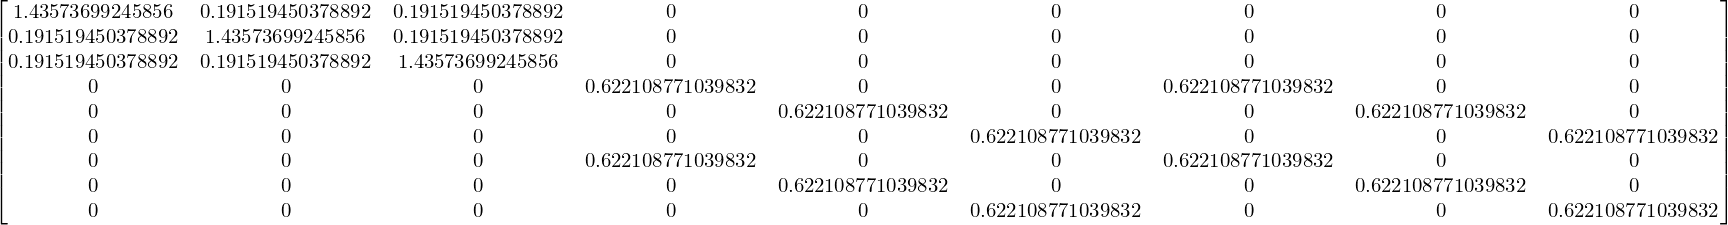

In [165]:
A_num

In [166]:
dPK2dRCG_num = np.zeros([3,3,3,3])

T1 = np.zeros([3,3])

for J in range(3):
    for Q in range(3):
        
        for R in range(3):
            T1[J,Q] += RCGinvtest[J,R]*(etest[R,Q] + np.eye(3)[R,Q])
        
T2 = np.zeros([3,3])
for I in range(3):
    for Q in range(3):
        
        for K in range(3):
            for L in range(3):
                T2[I,Q] += Btest[I,Q,K,L]*etest[K,L] + Dtest[I,Q,K,L]*Etest[K,L]

dRCGinvdCtest = np.zeros([3,3,3,3])        
for I in range(3):
    for J in range(3):
        for K in range(3):
            for L in range(3):
                dRCGinvdCtest[I,J,K,L] = -RCGinvtest[I,K]*RCGinvtest[L,J]
                
print("dRCGinvdCtest")
print(map_fot_to_voigt(dRCGinvdCtest))
                
T3 = np.zeros([3,3,3,3])
for J in range(3):
    for Q in range(3):
        for O in range(3):
            for P in range(3):
                
                for R in range(3):
                    T3[J,Q,O,P] += (etest[R,Q] + np.eye(3)[R,Q])*dRCGinvdCtest[J,R,O,P]

term2_num = np.zeros([3,3,3,3])
for I in range(3):
    for J in range(3):
        for O in range(3):
            for P in range(3):
                
                for Q in range(3):
                    term2_num[I,J,O,P] += 0.5*Dtest[I,Q,O,P]*T1[J,Q]
                    
print('term2_num')
print(map_fot_to_voigt(term2_num))

term3_num = np.zeros([3,3,3,3])
for I in range(3):
    for J in range(3):
        for O in range(3):
            for P in range(3):
                
                for Q in range(3):
                    term3_num[I,J,O,P] += T2[I,Q]*T3[J,Q,O,P]
                    
print('term3_num')
print(map_fot_to_voigt(term3_num))
          
T4 = np.zeros([3,3])
for I in range(3):
    for S in range(3):
        
        for Q in range(3):
            for R in range(3):
                for L in range(3):
                    for M in range(3):
                        for N in range(3):
                            T4[I,S] += Ctest[I,Q,R,L,M,N]*Gammatest[L,M,N]*Gammatest[S,Q,R]
print("T4")
print(T4)

term4_num = np.zeros([3,3,3,3])

for I in range(3):
    for J in range(3):
        for O in range(3):
            for P in range(3):
                
                for S in range(3):
                    term4_num[I,J,O,P] += T4[I,S]*dRCGinvdCtest[S,J,O,P];
print("term4") 
print(map_fot_to_voigt(term4_num))
    
for I in range(3):
    for J in range(3):
        for O in range(3):
            for P in range(3):
                dPK2dRCG_num[I,J,O,P] = 0.5*Atest[I,J,O,P]
                
                for Q in range(3):
                    dPK2dRCG_num[I,J,O,P] += 0.5*Dtest[I,Q,O,P]*T1[J,Q] + T2[I,Q]*T3[J,Q,O,P]
map_fot_to_voigt(dPK2dRCG_num)

dRCGinvdCtest
[[-0.050835934590693528, -0.022991556150624985, -0.04817444772130957, -0.033280707922305933, 0.04948730214209781, 0.034187676794591192, -0.033280707922305933, 0.04948730214209781, 0.034187676794591192], [-0.022991556150624985, -0.31546724659547215, -0.016633965017618636, -0.072439430865196303, 0.019556092163571702, 0.085165033398589454, -0.072439430865196303, 0.019556092163571702, 0.085165033398589454], [-0.04817444772130957, -0.016633965017618636, -2.8910944771748071, -0.2192951536079997, 0.37319817757864865, 0.02830780949030428, -0.2192951536079997, 0.37319817757864865, 0.02830780949030428], [-0.033280707922305933, -0.072439430865196303, -0.2192951536079997, -0.95501079279854872, 0.2578192409590998, 0.019556092163571702, -0.016633965017618636, 0.02830780949030428, 0.12327798010552836], [0.04948730214209781, 0.019556092163571702, 0.37319817757864865, 0.2578192409590998, -0.38336860817909152, -0.029079256483265616, 0.02830780949030428, -0.04817444772130957, -0.03328070792

In [167]:
term1_num = np.zeros([3,3,3,3])
term2_num = np.zeros([3,3,3,3])
term3_num = np.zeros([3,3,3,3])

T1 = np.zeros([3,3])
for I in range(3):
    for P in range(3):
        
        for K in range(3):
            for L in range(3):
                T1[I,P] += Btest[I,P,K,L]*etest[K,L] + Dtest[I,P,K,L]*Etest[K,L]
                
for I in range(3):
    for J in range(3):
        for O in range(3):
            for P in range(3):
                term1_num[I,J,O,P] = Dtest[I,J,O,P]
                
T2 = np.zeros([3,3])

for J in range(3):
    for Q in range(3):
        
        for R in range(3):
            T2[J,Q] += (etest[R,Q]+np.eye(3)[R,Q])*RCGinvtest[J,R]
            
for I in range(3):
    for J in range(3):
        for O in range(3):
            for P in range(3):
                
                for Q in range(3):
                    term2_num[I,J,O,P] += Btest[I,Q,O,P]*T2[J,Q]
                
for I in range(3):
    for J in range(3):
        for O in range(3):
            for P in range(3):
                term3_num[I,J,O,P] = T1[I,P]*RCGinvtest[J,O]
                
map_fot_to_voigt(term1_num + term2_num + term3_num)

Compute the jacobian of the cauchy stress

In [346]:
A    = form_tensor('A',[3,3]) #The stress measure in the reference configuration
a    = form_tensor('a',[3,3]) #The stress measure in the current configuration
F    = form_tensor('F',[3,3]) #The deformation gradient
Finv = form_tensor('Finv',[3,3]) #The inverse of F
Jac  = sympy.symbols('J')     #The determinant of F

dJdF = form_tensor('dJdF',[3,3]) #The derivative of J w.r.t. F

dAdF = form_tensor('dAdF',[3,3,3,3]) #The jacobian of the stress measure in the reference configuration

term1 = form_tensor('_',[3,3,3,3])

for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                
                term1[i][j][k][K] = -dJdF[k][K]*a[i][j]
                
term2 = form_tensor('_',[3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                term2[i][j][k][K] = zero
                
                for I in range(3):
                    for J in range(3):
                        term2[i][j][k][K] += eye[i,k]*eye[I,K]*F[j][J]*A[I][J]
                        
term3 = form_tensor('_',[3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                term3[i][j][k][K] = zero
                
                for I in range(3):
                    for J in range(3):
                        term3[i][j][k][K] += F[i][I]*eye[j,k]*eye[J,K]*A[I][J]
                        
term4 = form_tensor('_',[3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                term4[i][j][k][K] = zero
                
                for I in range(3):
                    for J in range(3):
                        term4[i][j][k][K] += F[i][I]*F[j][J]*dAdF[I][J][k][K]
                    
dadF = form_tensor('_',[3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                dadF[i][j][k][K] = term1[i][j][k][K] + term2[i][j][k][K] + term3[i][j][k][K] + term4[i][j][k][K]

In [350]:
def replace_powers(string,expected_powers):
    for ep in expected_powers:
        string = string.replace("{0}**2".format(ep),r"{0}*{0}".format(ep))
    return string
        
def get_sot_voigt_indices():
    """
    ===============================
    |    get_sot_voigt_indices    |
    ===============================
    
    Get the ordering of a second order tensor in voigt notation.
    """
    
    A = [[0, 1, 2],\
         [3, 4, 5],\
         [6, 7, 8]]
    
    coords = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
    
    Avoigt = tensor_to_voigt_2(A)
    
    return [coords[v] for v in Avoigt]

def get_tot_voigt_indices():
    """
    ===============================
    |    get_tot_voigt_indices    |
    ===============================
    
    Get the indices of a third order tensor in voigt notation.
    """
    
    A = [[[ 0, 1, 2],
          [ 3, 4, 5],
          [ 6, 7, 8]],
        
         [[ 9,10,11],
          [12,13,14],
          [15,16,17]],
         
         [[18,19,20],
          [21,22,23],
          [24,25,26]]]
    
    coords = [(0,0,0),(0,0,1),(0,0,2),(0,1,0),(0,1,1),(0,1,2),(0,2,0),(0,2,1),(0,2,2),
              (1,0,0),(1,0,1),(1,0,2),(1,1,0),(1,1,1),(1,1,2),(1,2,0),(1,2,1),(1,2,2),
              (2,0,0),(2,0,1),(2,0,2),(2,1,0),(2,1,1),(2,1,2),(2,2,0),(2,2,1),(2,2,2)]
    
    Avoigt = tensor_to_voigt_3(A)
    
    return [coords[v] for v in Avoigt]
    
def map_shape_to_indices(a):
    """
    ==============================
    |    map_shape_to_indices    |
    ==============================
    
    Map a shape to the indices present
    """
    
    if(a==1):
        I = [(0,)]
    elif(a==3):
        I = [(v,) for v in range(3)]
    elif(a==9):
        I = get_sot_voigt_indices()
    elif(a==27):
        I = get_tot_voigt_indices()
    else:
        print("Error: value of {0} not recognized as expected tensor shape\n")
        raise ValueError
    return I
    
def extract_voigt_matrix(M,symbol,nspaces=8,string=""):
    """
    ==============================
    |    extract_voigt_matrix    |
    ==============================
    
    Extract the values of a voigt matrix for computing tensor operations.
    """
    
    string += " "*nspaces+"//Extracting {0}\n".format(symbol)
    
    #Extract the matrix shape (every row is assumed to have the same length)
    a = len(M)
    b = len(M[0])
    
    #Map the matrix shape to voigt indices
    Ihat = map_shape_to_indices(a)
    Jhat = map_shape_to_indices(b)
    
    for i,I in enumerate(Ihat):
        
        for j,J in enumerate(Jhat):
            
            if(a==1):
                indices = []
            else:
                indices = [str(v+1) for v in I]
            [indices.append(str(v+1)) for v in J]
            
            if(a==1):
                string += ' '*nspaces + "double {0}".format(symbol) + "".join(indices) + "= {0}({1});\n".format(symbol,j)
            else:
                string += ' '*nspaces + "double {0}".format(symbol) + "".join(indices) + "= {0}({1},{2});\n".format(symbol,i,j)
                
    string += "\n"
    return string

def set_voigt_matrix(M,symbol,nspaces=8,string="",mode=1):
    """
    ==========================
    |    set_voigt_matrix    |
    ==========================
    
    Set the values of a voigt matrix where the indices are sympy expressions.
    """
    
    a = len(M)
    b = len(M[0])
    
    if(mode==2):
        string += " "*nspaces+r" << "
    
    for i in range(a):
        for j in range(b):
            if(mode==1):
                if(not M[i][j]==zero):
                    string += " "*nspaces + "{0}({1},{2}) = {3};\n".format(symbol,i,j,M[i][j])
            elif(mode==2):
                string += "{0}".format(M[i][j])
                if(j<(b-1)):
                    string += ", "
        if(mode==2):
            if(i<(a-1)):
                string += ",\n" + " "*nspaces + "    "
            else:
                string += ";\n"
    string += "\n"
    return string
    
def write_code_matrix(M,symbol,nspaces=8,subterms=[],submatrices={}):
    
    string = ""
    
    for name,m in zip(submatrices.keys(),submatrices.values()):
        string  = extract_voigt_matrix(m,name,nspaces=nspaces,string=string)
    
    string = set_voigt_matrix(M,symbol,nspaces=nspaces,string=string)
            
    terms = []
    for t in subterms:
        dim = len(find_dimension(t,store=[]))
        indices = itertools.product(range(3),repeat=dim)
    
        for indx in indices:
        
            temp = t
        
            for i in indx:
                temp = temp[i]
            
            terms.append(temp)
            
    string = replace_powers(string,terms)
    print(string)

In [351]:
nspaces=8
dAdFvoigt = map_fot_to_voigt(dAdF)
Avoigt    = tensor_to_voigt_2(A)
avoigt    = tensor_to_voigt_2(a)
write_code_matrix(map_fot_to_voigt(dadF),'dadF',nspaces=nspaces,subterms=[F,A,dAdF],submatrices={"dJdF":dJdF,"F":F,"a":[avoigt],"A":[Avoigt],"dAdF":dAdFvoigt})
print' '*nspaces+'dadF /= J;'

        //Extracting dJdF
        double dJdF11= dJdF(0,0);
        double dJdF12= dJdF(0,1);
        double dJdF13= dJdF(0,2);
        double dJdF21= dJdF(1,0);
        double dJdF22= dJdF(1,1);
        double dJdF23= dJdF(1,2);
        double dJdF31= dJdF(2,0);
        double dJdF32= dJdF(2,1);
        double dJdF33= dJdF(2,2);

        //Extracting a
        double a11= a(0);
        double a22= a(1);
        double a33= a(2);
        double a23= a(3);
        double a13= a(4);
        double a12= a(5);
        double a32= a(6);
        double a31= a(7);
        double a21= a(8);

        //Extracting dAdF
        double dAdF1111= dAdF(0,0);
        double dAdF1122= dAdF(0,1);
        double dAdF1133= dAdF(0,2);
        double dAdF1123= dAdF(0,3);
        double dAdF1113= dAdF(0,4);
        double dAdF1112= dAdF(0,5);
        double dAdF1132= dAdF(0,6);
        double dAdF1131= dAdF(0,7);
        double dAdF1121= dAdF(0,8);
        double dAdF2211= dAdF(1,0);
        double dAdF2222

In [356]:
A    = form_tensor('A',[3,3]) #The stress measure in the reference configuration
F    = form_tensor('F',[3,3]) #The deformation gradient
Finv = form_tensor('Finv',[3,3]) #The inverse of F
Jac  = sympy.symbols('J')     #The determinant of F

dAdchi = form_tensor('dAdchi',[3,3,3,3]) #The jacobian of the stress measure in the reference configuration

dadchi = form_tensor('_',[3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                dadchi[i][j][k][K] = zero
                
                for I in range(3):
                    for J in range(3):
                        dadchi[i][j][k][K] += F[i][I]*F[j][J]*dAdchi[I][J][k][K]

In [357]:
nspaces=8
print(F)
dAdchivoigt = map_fot_to_voigt(dAdchi)
write_code_matrix(map_fot_to_voigt(dadchi),'dadchi',nspaces=nspaces,subterms=[F,dAdchi],submatrices={"F":F,"dAdchi":dAdchivoigt})
print' '*nspaces+'dadchi /= J;'

[[F11, F12, F13], [F21, F22, F23], [F31, F32, F33]]
        //Extracting dAdchi
        double dAdchi1111= dAdchi(0,0);
        double dAdchi1122= dAdchi(0,1);
        double dAdchi1133= dAdchi(0,2);
        double dAdchi1123= dAdchi(0,3);
        double dAdchi1113= dAdchi(0,4);
        double dAdchi1112= dAdchi(0,5);
        double dAdchi1132= dAdchi(0,6);
        double dAdchi1131= dAdchi(0,7);
        double dAdchi1121= dAdchi(0,8);
        double dAdchi2211= dAdchi(1,0);
        double dAdchi2222= dAdchi(1,1);
        double dAdchi2233= dAdchi(1,2);
        double dAdchi2223= dAdchi(1,3);
        double dAdchi2213= dAdchi(1,4);
        double dAdchi2212= dAdchi(1,5);
        double dAdchi2232= dAdchi(1,6);
        double dAdchi2231= dAdchi(1,7);
        double dAdchi2221= dAdchi(1,8);
        double dAdchi3311= dAdchi(2,0);
        double dAdchi3322= dAdchi(2,1);
        double dAdchi3333= dAdchi(2,2);
        double dAdchi3323= dAdchi(2,3);
        double dAdchi3313= dAdchi(2,4);


In [358]:
A    = form_tensor('A',[3,3]) #The stress measure in the reference configuration
F    = form_tensor('F',[3,3]) #The deformation gradient
Finv = form_tensor('Finv',[3,3]) #The inverse of F
Jac  = sympy.symbols('J')     #The determinant of F

dAdgrad_chi = form_tensor('dAdgrad_chi',[3,3,3,3,3]) #The jacobian of the stress measure in the reference configuration

dadgrad_chi = form_tensor('_',[3,3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for K in range(3):
                for L in range(3):
                    dadgrad_chi[i][j][k][K][L] = zero
                
                    for I in range(3):
                        for J in range(3):
                            dadgrad_chi[i][j][k][K][L] += F[i][I]*F[j][J]*dAdgrad_chi[I][J][k][K][L]

In [360]:
nspaces=8
dAdgrad_chivoigt = map_5ot_to_voigt(dAdgrad_chi)
write_code_matrix(map_5ot_to_voigt(dadgrad_chi),'dadgrad_chi',nspaces=nspaces,subterms=[F,A,dAdgrad_chi],submatrices={"F":F,"dAdgrad_chi":dAdgrad_chivoigt})
print' '*nspaces+'dadgrad_chi /= J;'

        //Extracting dAdgrad_chi
        double dAdgrad_chi11111= dAdgrad_chi(0,0);
        double dAdgrad_chi11122= dAdgrad_chi(0,1);
        double dAdgrad_chi11133= dAdgrad_chi(0,2);
        double dAdgrad_chi11123= dAdgrad_chi(0,3);
        double dAdgrad_chi11113= dAdgrad_chi(0,4);
        double dAdgrad_chi11112= dAdgrad_chi(0,5);
        double dAdgrad_chi11132= dAdgrad_chi(0,6);
        double dAdgrad_chi11131= dAdgrad_chi(0,7);
        double dAdgrad_chi11121= dAdgrad_chi(0,8);
        double dAdgrad_chi11211= dAdgrad_chi(0,9);
        double dAdgrad_chi11222= dAdgrad_chi(0,10);
        double dAdgrad_chi11233= dAdgrad_chi(0,11);
        double dAdgrad_chi11223= dAdgrad_chi(0,12);
        double dAdgrad_chi11213= dAdgrad_chi(0,13);
        double dAdgrad_chi11212= dAdgrad_chi(0,14);
        double dAdgrad_chi11232= dAdgrad_chi(0,15);
        double dAdgrad_chi11231= dAdgrad_chi(0,16);
        double dAdgrad_chi11221= dAdgrad_chi(0,17);
        double dAdgrad_chi11311= dAdgrad_

Gradients for the higher-order stress tensor.

In [361]:
A    = form_tensor('A',[3,3,3])  #The stress measure in the reference configuration
a    = form_tensor('a',[3,3,3])  #The stress measure in the current configuration
F    = form_tensor('F',[3,3])    #The deformation gradient
chi  = form_tensor('chi',[3,3])  #The micro-displacement tensor
Finv = form_tensor('Finv',[3,3]) #The inverse of F
Jac  = sympy.symbols('J')        #The determinant of F

dJdF = form_tensor('dJdF',[3,3]) #The derivative of J w.r.t. F

dAdF = form_tensor('dAdF',[3,3,3,3,3]) #The jacobian of the stress measure in the reference configuration

term1 = form_tensor('_',[3,3,3,3,3])

#F_iI F_jJ chi_kK M_IJK

for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for L in range(3):
                
                    term1[i][j][k][l][L] = -dJdF[l][L]*a[i][j][k] #Note: Multiplying by jac to give correct value later
                
term2 = form_tensor('_',[3,3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for L in range(3):
                    term2[i][j][k][l][L] = zero
                    
                    for I in range(3):
                        for J in range(3):
                            for K in range(3):
                                term2[i][j][k][l][L] += eye[i,l] * eye[I,L] * F[j][J] * chi[k][K] * A[I][J][K]
                
term3 = form_tensor('_',[3,3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for L in range(3):
                    term3[i][j][k][l][L] = zero
                    
                    for I in range(3):
                        for J in range(3):
                            for K in range(3):
                                term3[i][j][k][l][L] += F[i][I] * eye[j,l] * eye[J,L] * chi[k][K] * A[I][J][K]
                        
term4 = form_tensor('_',[3,3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for L in range(3):
                    term4[i][j][k][l][L] = zero
                    
                    for I in range(3):
                        for J in range(3):
                            for K in range(3):
                                term4[i][j][k][l][L] += F[i][I] * F[j][J] * chi[k][K] * dAdF[I][J][K][l][L]
                    
dadF = form_tensor('_',[3,3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for L in range(3):
                    dadF[i][j][k][l][L] = term1[i][j][k][l][L] + term2[i][j][k][l][L]\
                                        + term3[i][j][k][l][L] + term4[i][j][k][l][L]

In [362]:
nspaces=8
Avoigt    = tensor_to_voigt_3(A)
avoigt    = tensor_to_voigt_3(a)
dAdFvoigt = map_5ot_to_voigt(dAdF,mode=2)
write_code_matrix(map_5ot_to_voigt(dadF,mode=2),'dadF',nspaces=nspaces,subterms=[F,A,dAdF],submatrices={"dJdF":dJdF,"a":[avoigt],"F":F,"chi":chi,"A":[Avoigt],"dAdF":dAdFvoigt})
print' '*nspaces+'dadF /= J;'

        //Extracting dJdF
        double dJdF11= dJdF(0,0);
        double dJdF12= dJdF(0,1);
        double dJdF13= dJdF(0,2);
        double dJdF21= dJdF(1,0);
        double dJdF22= dJdF(1,1);
        double dJdF23= dJdF(1,2);
        double dJdF31= dJdF(2,0);
        double dJdF32= dJdF(2,1);
        double dJdF33= dJdF(2,2);

        //Extracting a
        double a111= a(0);
        double a122= a(1);
        double a133= a(2);
        double a123= a(3);
        double a113= a(4);
        double a112= a(5);
        double a132= a(6);
        double a131= a(7);
        double a121= a(8);
        double a211= a(9);
        double a222= a(10);
        double a233= a(11);
        double a223= a(12);
        double a213= a(13);
        double a212= a(14);
        double a232= a(15);
        double a231= a(16);
        double a221= a(17);
        double a311= a(18);
        double a322= a(19);
        double a333= a(20);
        double a323= a(21);
        double a313= a(22);
        do

In [367]:
A    = form_tensor('A',[3,3,3])  #The stress measure in the reference configuration
a    = form_tensor('a',[3,3,3])  #The stress measure in the current configuration
F    = form_tensor('F',[3,3])    #The deformation gradient
chi  = form_tensor('chi',[3,3])  #The micro-displacement tensor
Finv = form_tensor('Finv',[3,3]) #The inverse of F
Jac  = sympy.symbols('J')        #The determinant of F

dJdF = form_tensor('dJdF',[3,3]) #The derivative of J w.r.t. F

dAdchi = form_tensor('dAdchi',[3,3,3,3,3]) #The jacobian of the stress measure in the reference configuration

dadchi = form_tensor('_',[3,3,3,3,3])

term1 = form_tensor("_",[3,3,3,3,3])
term2 = form_tensor("_",[3,3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for L in range(3):
                    term1[i][j][k][l][L] = zero
                    term2[i][j][k][l][L] = zero
                    
                    for I in range(3):
                        for J in range(3):
                            for K in range(3):
                                term1[i][j][k][l][L] += F[i][I] * F[j][J] * eye[k,l] * eye[K,l] * A[I][J][K]
                                term2[i][j][k][l][L] += F[i][I] * F[j][J] * chi[k][K] * dAdchi[I][J][K][l][L]
                                
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for L in range(3):
                    dadchi[i][j][k][l][L] = term1[i][j][k][l][L] + term2[i][j][k][l][L]

In [368]:
nspaces=8
dAdchivoigt = map_5ot_to_voigt(dAdchi,mode=2)
Avoigt      = tensor_to_voigt_3(A)
write_code_matrix(map_5ot_to_voigt(dadchi,mode=2),'dadchi',nspaces=nspaces,subterms=[F,A,dAdchi],submatrices={"F":F,"chi":chi,"A":[Avoigt],"dAdchi":dAdchivoigt})
print' '*nspaces+'dadchi /= J;'

        //Extracting A
        double A111= A(0);
        double A122= A(1);
        double A133= A(2);
        double A123= A(3);
        double A113= A(4);
        double A112= A(5);
        double A132= A(6);
        double A131= A(7);
        double A121= A(8);
        double A211= A(9);
        double A222= A(10);
        double A233= A(11);
        double A223= A(12);
        double A213= A(13);
        double A212= A(14);
        double A232= A(15);
        double A231= A(16);
        double A221= A(17);
        double A311= A(18);
        double A322= A(19);
        double A333= A(20);
        double A323= A(21);
        double A313= A(22);
        double A312= A(23);
        double A332= A(24);
        double A331= A(25);
        double A321= A(26);

        //Extracting chi
        double chi11= chi(0,0);
        double chi12= chi(0,1);
        double chi13= chi(0,2);
        double chi21= chi(1,0);
        double chi22= chi(1,1);
        double chi23= chi(1,2);
        doubl

In [339]:
A    = form_tensor('A',[3,3,3])  #The stress measure in the reference configuration
a    = form_tensor('a',[3,3,3])  #The stress measure in the current configuration
F    = form_tensor('F',[3,3])    #The deformation gradient
chi  = form_tensor('chi',[3,3])  #The micro-displacement tensor
Finv = form_tensor('Finv',[3,3]) #The inverse of F
Jac  = sympy.symbols('J')        #The determinant of F

dJdF = form_tensor('dJdF',[3,3]) #The derivative of J w.r.t. F

dAdgrad_chi = form_tensor('dAdgrad_chi',[3,3,3,3,3,3]) #The jacobian of the stress measure in the reference configuration

dadgrad_chi = form_tensor('_',[3,3,3,3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for L in range(3):
                    for M in range(3):
                        dadgrad_chi[i][j][k][l][L][M] = zero
                    
                        for I in range(3):
                            for J in range(3):
                                for K in range(3):
                                    dadgrad_chi[i][j][k][l][L][M] += F[i][I] * F[j][J] * chi[k][K] * dAdgrad_chi[I][J][K][l][L][M]

In [340]:
nspaces=8
dAdgrad_chivoigt = map_6ot_to_voigt(dAdgrad_chi)
Avoigt      = tensor_to_voigt_3(A)
write_code_matrix(map_6ot_to_voigt(dadgrad_chi),'dadgrad_chi',nspaces=nspaces,subterms=[F,A,dAdgrad_chi],submatrices={"F":F,"chi":chi,"A":[Avoigt],"dAdgrad_chi":dAdgrad_chivoigt})
print' '*nspaces+'dadgrad_chi /= J;'

        //Extracting A
        double A111= A(0);
        double A122= A(1);
        double A133= A(2);
        double A123= A(3);
        double A113= A(4);
        double A112= A(5);
        double A132= A(6);
        double A131= A(7);
        double A121= A(8);
        double A211= A(9);
        double A222= A(10);
        double A233= A(11);
        double A223= A(12);
        double A213= A(13);
        double A212= A(14);
        double A232= A(15);
        double A231= A(16);
        double A221= A(17);
        double A311= A(18);
        double A322= A(19);
        double A333= A(20);
        double A323= A(21);
        double A313= A(22);
        double A312= A(23);
        double A332= A(24);
        double A331= A(25);
        double A321= A(26);

        //Extracting chi
        double chi11= chi(0,0);
        double chi12= chi(0,1);
        double chi13= chi(0,2);
        double chi21= chi(1,0);
        double chi22= chi(1,1);
        double chi23= chi(1,2);
        doubl